In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from datetime import datetime, timedelta
import datetime

pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Read Data

In [2]:
bus_data = pd.read_csv('BusData1.csv', low_memory=False)
pd.options.display.max_columns = None
bus_data.head()

LineRef LocationCode          LocationName ScheduledArrivalTime  \
0       3  39028140001  Station Road Stop SA  2018-01-02 05:50:00   
1       3  39026630001          Market Place  2018-01-02 05:52:00   
2       3  39025920003            Kings Road  2018-01-02 05:53:00   
3       3  39026410003   Huntley and Palmers  2018-01-02 05:54:00   
4       3  39025980003     Eldon Road adj 11  2018-01-02 05:55:00   

  ScheduledDepartureTime          ArrivalTime        DepartureTime  \
0    2018-01-02 05:50:00  2018-01-02 05:47:42  2018-01-02 05:50:25   
1    2018-01-02 05:52:00  2018-01-02 05:52:13  2018-01-02 05:52:37   
2    2018-01-02 05:53:00  2018-01-02 05:52:49  2018-01-02 05:53:17   
3    2018-01-02 05:54:00  2018-01-02 05:53:39  2018-01-02 05:53:40   
4    2018-01-02 05:55:00  2018-01-02 05:55:11  2018-01-02 05:55:12   

  ServiceGroup  NumberStops            StartPoint              EndPoint  \
0      Leopard           56  Station Road Stop SA  Broad Street E-bound   
1      Leopard           56  Station Road Stop SA  Broad Street E-bound   
2      Leopard           56  Station Road Stop SA  Broad Street E-bound   
3      Leopard           56  Station Road Stop SA  Broad Street E-bound   
4      Leopard           56  Station Road Stop SA  Broad Street E-bound   

   Latitude  Longitude  
0   51.4581    -0.9723  
1   51.4560    -0.9694  
2   51.4550    -0.9683  
3   51.4550    -0.9635  
4   51.4526    -0.9586

In [3]:
bus_data.tail()

LineRef LocationCode       LocationName ScheduledArrivalTime  \
2895855      26  30053640002      Ledbury Drive  2018-06-01 00:09:00   
2895856      26  30054700001  Pemberton Gardens  2018-06-01 00:09:30   
2895857      26  30050400001   Beansheaf Stores  2018-06-01 00:10:00   
2895858      26  30056320002     Torcross Grove  2018-06-01 00:10:30   
2895859      26  30053940001    Mayfield Avenue  2018-06-01 00:11:00   

        ScheduledDepartureTime          ArrivalTime        DepartureTime  \
2895855    2018-06-01 00:09:00  2018-06-01 00:11:43  2018-06-01 00:11:43   
2895856    2018-06-01 00:09:30  2018-06-01 00:12:06  2018-06-01 00:12:06   
2895857    2018-06-01 00:10:00  2018-06-01 00:12:36  2018-06-01 00:12:36   
2895858    2018-06-01 00:10:30  2018-06-01 00:13:13  2018-06-01 00:13:13   
2895859    2018-06-01 00:11:00  2018-06-01 00:13:33  2018-06-01 00:13:33   

        ServiceGroup  NumberStops               StartPoint  \
2895855       Yellow           30  Blagrave Street stop EK   
2895856       Yellow           30  Blagrave Street stop EK   
2895857       Yellow           30  Blagrave Street stop EK   
2895858       Yellow           30  Blagrave Street stop EK   
2895859       Yellow           30  Blagrave Street stop EK   

                    EndPoint  Latitude  Longitude  
2895855  Calcot, Sainsbury's   51.4403    -1.0419  
2895856  Calcot, Sainsbury's   51.4407    -1.0446  
2895857  Calcot, Sainsbury's   51.4404    -1.0477  
2895858  Calcot, Sainsbury's   51.4394    -1.0529  
2895859  Calcot, Sainsbury's   51.4409    -1.0574

# Modify DataType and Columns

In [5]:
# Convert dates from object to datetime
bus_data['ScheduledArrivalTime'] = pd.to_datetime(bus_data['ScheduledArrivalTime'], infer_datetime_format=True)
bus_data['ScheduledDepartureTime'] = pd.to_datetime(bus_data['ScheduledDepartureTime'], infer_datetime_format=True)
bus_data['ArrivalTime'] = pd.to_datetime(bus_data['ArrivalTime'], infer_datetime_format=True)
bus_data['DepartureTime'] = pd.to_datetime(bus_data['DepartureTime'], infer_datetime_format=True)

In [6]:
bus_data.dtypes

LineRef                           object
LocationCode                      object
LocationName                      object
ScheduledArrivalTime      datetime64[ns]
ScheduledDepartureTime    datetime64[ns]
ArrivalTime               datetime64[ns]
DepartureTime             datetime64[ns]
ServiceGroup                      object
NumberStops                        int64
StartPoint                        object
EndPoint                          object
Latitude                         float64
Longitude                        float64
dtype: object

In [7]:
def format_timedelta(x):
    ts = x.total_seconds()
    if ts >= 0:
        hours, remainder = divmod(ts, 3600)
        minutes, seconds = divmod(remainder, 60)
        return ('{}:{:02d}:{:02d}').format(int(hours), int(minutes), int(seconds)) 
    else:
        hours, remainder = divmod(-ts, 3600)
        minutes, seconds = divmod(remainder, 60)
        return ('-{}:{:02d}:{:02d}').format(int(hours), int(minutes), int(seconds)) 

# Getting Arrival Wait Time
bus_data['ArrivalWaitTime'] = bus_data['ArrivalTime'] - bus_data['ScheduledArrivalTime'] 
#bus_data['ArrivalWaitTime'] = bus_data['ArrivalWaitTime'].apply(format_timedelta)

# Getting Departure Wait Time
bus_data['DepartureWaitTime'] = bus_data['DepartureTime'] - bus_data['ScheduledDepartureTime'] 
#bus_data['DepartureWaitTime'] = bus_data['DepartureWaitTime'].apply(format_timedelta)
bus_data.head()

LineRef LocationCode          LocationName ScheduledArrivalTime  \
0       3  39028140001  Station Road Stop SA  2018-01-02 05:50:00   
1       3  39026630001          Market Place  2018-01-02 05:52:00   
2       3  39025920003            Kings Road  2018-01-02 05:53:00   
3       3  39026410003   Huntley and Palmers  2018-01-02 05:54:00   
4       3  39025980003     Eldon Road adj 11  2018-01-02 05:55:00   

  ScheduledDepartureTime         ArrivalTime       DepartureTime ServiceGroup  \
0    2018-01-02 05:50:00 2018-01-02 05:47:42 2018-01-02 05:50:25      Leopard   
1    2018-01-02 05:52:00 2018-01-02 05:52:13 2018-01-02 05:52:37      Leopard   
2    2018-01-02 05:53:00 2018-01-02 05:52:49 2018-01-02 05:53:17      Leopard   
3    2018-01-02 05:54:00 2018-01-02 05:53:39 2018-01-02 05:53:40      Leopard   
4    2018-01-02 05:55:00 2018-01-02 05:55:11 2018-01-02 05:55:12      Leopard   

   NumberStops            StartPoint              EndPoint  Latitude  \
0           56  Station Road Stop SA  Broad Street E-bound   51.4581   
1           56  Station Road Stop SA  Broad Street E-bound   51.4560   
2           56  Station Road Stop SA  Broad Street E-bound   51.4550   
3           56  Station Road Stop SA  Broad Street E-bound   51.4550   
4           56  Station Road Stop SA  Broad Street E-bound   51.4526   

   Longitude   ArrivalWaitTime DepartureWaitTime  
0    -0.9723 -1 days +23:57:42          00:00:25  
1    -0.9694          00:00:13          00:00:37  
2    -0.9683 -1 days +23:59:49          00:00:17  
3    -0.9635 -1 days +23:59:39 -1 days +23:59:40  
4    -0.9586          00:00:11          00:00:12

In [8]:
len(bus_data)

2895860

In [8]:
#bus_data.to_csv('BusDataSet.csv')

# Plot Buses

## Bus 21

### Dataset Months

In [27]:
bus_21 = bus_data.loc[bus_data['LineRef'] == '21']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [28]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [29]:
bus_21 = bus_21.loc[bus_21['ScheduledArrivalTime'] < date_after]

In [30]:
#bus_21 = bus_21.loc[(bus_21['ScheduledArrivalTime'] > '2018-04-01 00:00:00') & (bus_21['ScheduledArrivalTime'] <= '2018-05-01 12:00:00')]

In [31]:
bus_21.head()

LineRef LocationCode                 LocationName ScheduledArrivalTime  \
266718      21  39028150004              Reading Station  2018-01-01 04:00:00   
266719      21  39026630001                 Market Place  2018-01-01 04:01:00   
266720      21  39026580002           London Street foot  2018-01-01 04:02:00   
266721      21  39025810004  Crown Street, London Street  2018-01-01 04:03:00   
266722      21  39026610001     Kendrick Student Village  2018-01-01 04:04:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
266718    2018-01-01 04:00:00 2018-01-01 03:59:55 2018-01-01 04:03:52   
266719    2018-01-01 04:01:00 2018-01-01 04:04:34 2018-01-01 04:06:15   
266720    2018-01-01 04:02:00 2018-01-01 04:07:06 2018-01-01 04:07:16   
266721    2018-01-01 04:03:00 2018-01-01 04:07:27 2018-01-01 04:07:36   
266722    2018-01-01 04:04:00 2018-01-01 04:08:50 2018-01-01 04:09:00   

       ServiceGroup  NumberStops       StartPoint       EndPoint  Latitude  \
266718       Claret           22  Reading Station  Chilcombe Way   51.4580   
266719       Claret           22  Reading Station  Chilcombe Way   51.4560   
266720       Claret           22  Reading Station  Chilcombe Way   51.4528   
266721       Claret           22  Reading Station  Chilcombe Way   51.4510   
266722       Claret           22  Reading Station  Chilcombe Way   51.4503   

        Longitude   ArrivalWaitTime DepartureWaitTime  
266718    -0.9713 -1 days +23:59:55          00:03:52  
266719    -0.9694          00:03:34          00:05:15  
266720    -0.9682          00:05:06          00:05:16  
266721    -0.9673          00:04:27          00:04:36  
266722    -0.9645          00:04:50          00:05:00

In [32]:
bus_21.tail()

LineRef LocationCode            LocationName ScheduledArrivalTime  \
2719560      21  39025810003       London Street Top  2018-06-01 00:14:30   
2719561      21  39026580001      London Street Foot  2018-06-01 00:15:00   
2719562      21  39026690003          Minster Street  2018-06-01 00:17:00   
2719563      21  39027320003  St Marys Butts stop CR  2018-06-01 00:18:00   
2719564      21  39027760001     West Street stop CU  2018-06-01 00:19:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2719560    2018-06-01 00:14:30 2018-06-01 00:14:51 2018-06-01 00:15:02   
2719561    2018-06-01 00:15:00 2018-06-01 00:15:15 2018-06-01 00:15:26   
2719562    2018-06-01 00:17:00 2018-06-01 00:16:30 2018-06-01 00:17:02   
2719563    2018-06-01 00:18:00 2018-06-01 00:17:56 2018-06-01 00:18:30   
2719564    2018-06-01 00:19:00 2018-06-01 00:18:52 2018-06-01 00:19:21   

        ServiceGroup  NumberStops     StartPoint                 EndPoint  \
2719560       Claret           31  Chilcombe Way  Blagrave Street stop EK   
2719561       Claret           31  Chilcombe Way  Blagrave Street stop EK   
2719562       Claret           31  Chilcombe Way  Blagrave Street stop EK   
2719563       Claret           31  Chilcombe Way  Blagrave Street stop EK   
2719564       Claret           31  Chilcombe Way  Blagrave Street stop EK   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime  
2719560   51.4509    -0.9674          00:00:21          00:00:32  
2719561   51.4527    -0.9684          00:00:15          00:00:26  
2719562   51.4546    -0.9717 -1 days +23:59:30          00:00:02  
2719563   51.4548    -0.9748 -1 days +23:59:56          00:00:30  
2719564   51.4562    -0.9760 -1 days +23:59:52          00:00:21

In [33]:
len(bus_21)

535413

In [34]:
LineRef = pd.DataFrame()
LineRef = bus_21
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [35]:
LineRef.head()

LineRef LocationCode                 LocationName ScheduledArrivalTime  \
266718      21  39028150004              Reading Station  2018-01-01 04:00:00   
266719      21  39026630001                 Market Place  2018-01-01 04:01:00   
266720      21  39026580002           London Street foot  2018-01-01 04:02:00   
266721      21  39025810004  Crown Street, London Street  2018-01-01 04:03:00   
266722      21  39026610001     Kendrick Student Village  2018-01-01 04:04:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
266718    2018-01-01 04:00:00 2018-01-01 03:59:55 2018-01-01 04:03:52   
266719    2018-01-01 04:01:00 2018-01-01 04:04:34 2018-01-01 04:06:15   
266720    2018-01-01 04:02:00 2018-01-01 04:07:06 2018-01-01 04:07:16   
266721    2018-01-01 04:03:00 2018-01-01 04:07:27 2018-01-01 04:07:36   
266722    2018-01-01 04:04:00 2018-01-01 04:08:50 2018-01-01 04:09:00   

       ServiceGroup  NumberStops       StartPoint       EndPoint  Latitude  \
266718       Claret           22  Reading Station  Chilcombe Way   51.4580   
266719       Claret           22  Reading Station  Chilcombe Way   51.4560   
266720       Claret           22  Reading Station  Chilcombe Way   51.4528   
266721       Claret           22  Reading Station  Chilcombe Way   51.4510   
266722       Claret           22  Reading Station  Chilcombe Way   51.4503   

        Longitude   ArrivalWaitTime DepartureWaitTime    delay  
266718    -0.9713 -1 days +23:59:55          00:03:52  -5.0000  
266719    -0.9694          00:03:34          00:05:15 214.0000  
266720    -0.9682          00:05:06          00:05:16 306.0000  
266721    -0.9673          00:04:27          00:04:36 267.0000  
266722    -0.9645          00:04:50          00:05:00 290.0000

In [36]:
LineRef = LineRef.groupby(['LocationName']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

48

In [37]:
#LineRef.to_csv('bus_21_apr18.csv')

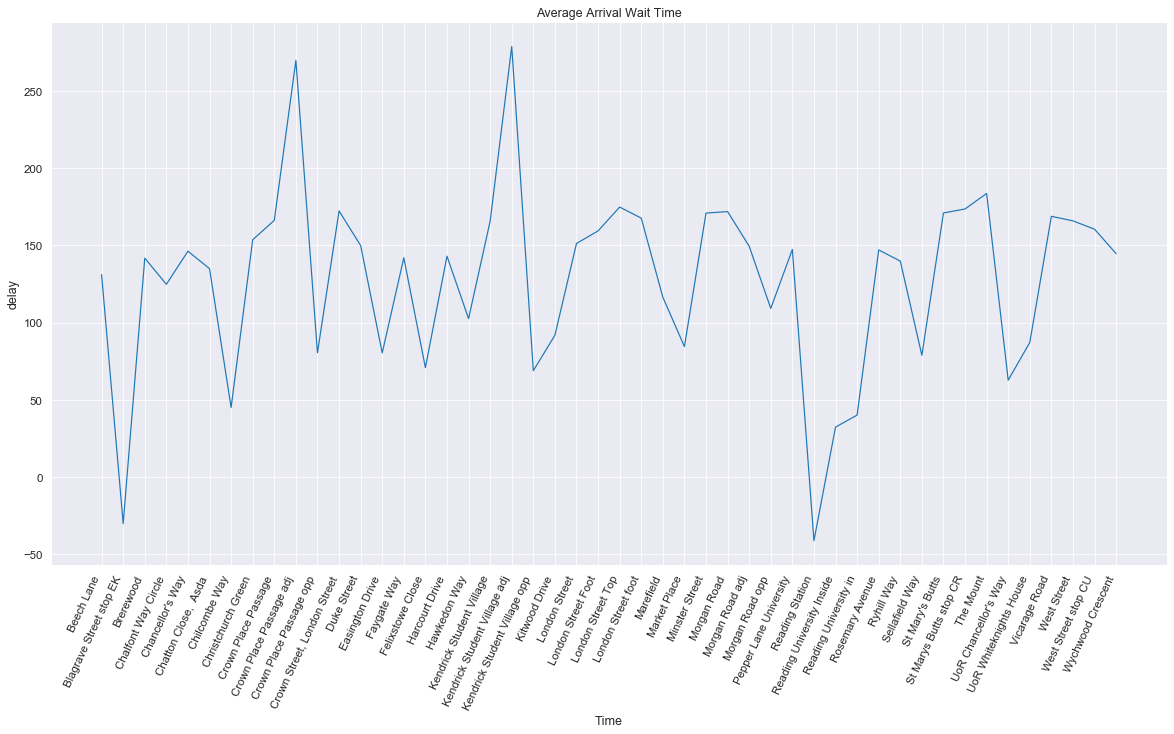

In [38]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show() 

In [26]:
LineRef.head()

NumberStops  Latitude  Longitude    delay
LocationName                                                      
Beech Lane                   26.4647   51.4282    -0.9248 131.1113
Blagrave Street stop EK      24.2924   51.4580    -0.9713 -30.2351
Brerewood                    26.4633   51.4305    -0.9388 141.7941
Chalfont Way Circle          26.4607   51.4276    -0.9357 124.8437
Chancellor's Way             29.1910   51.4407    -0.9526 146.2985

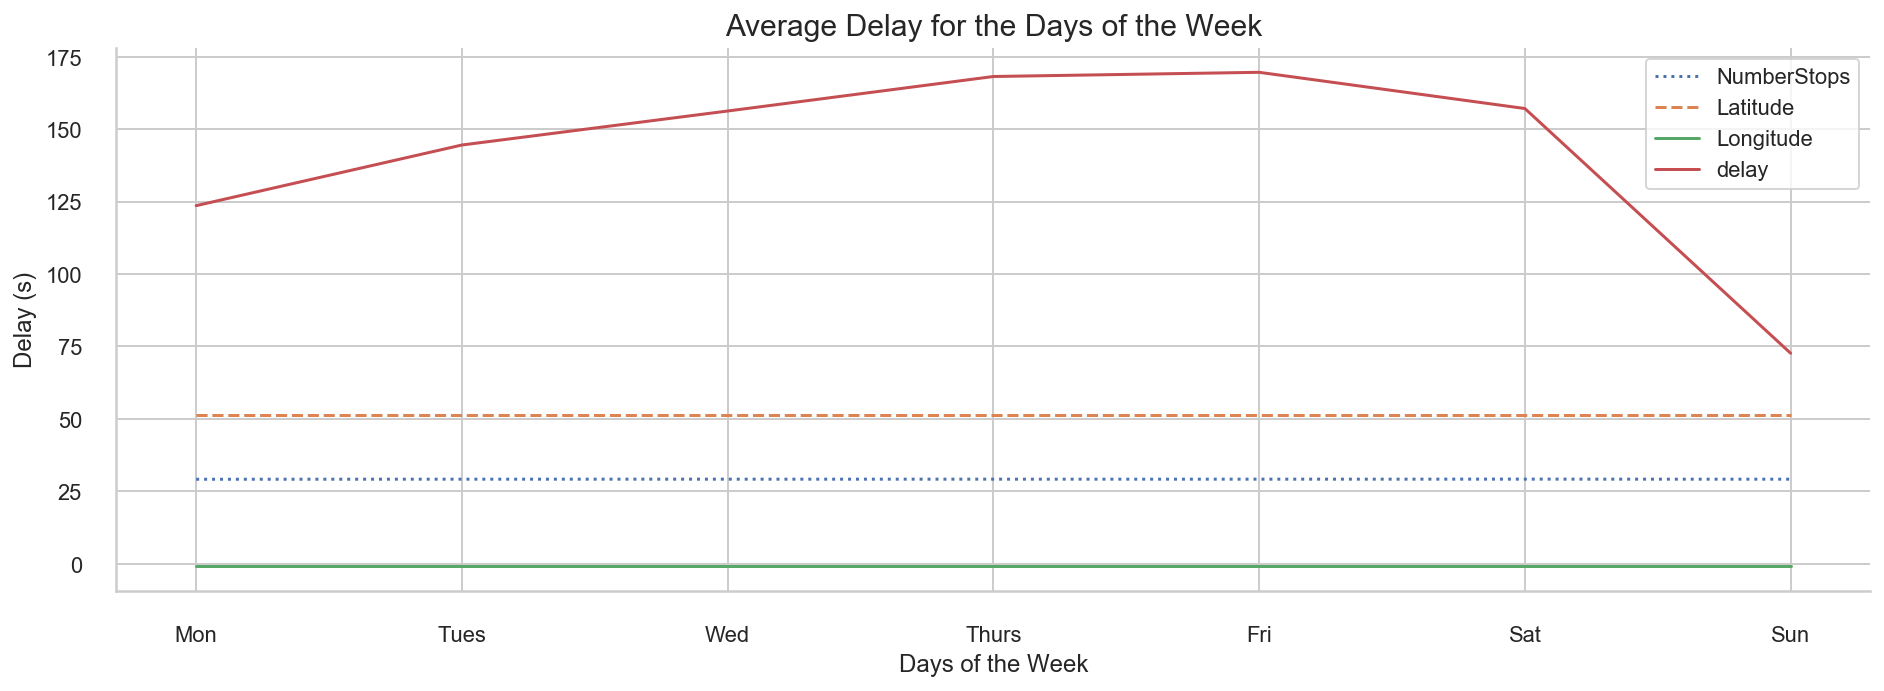

In [378]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus21_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [344]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

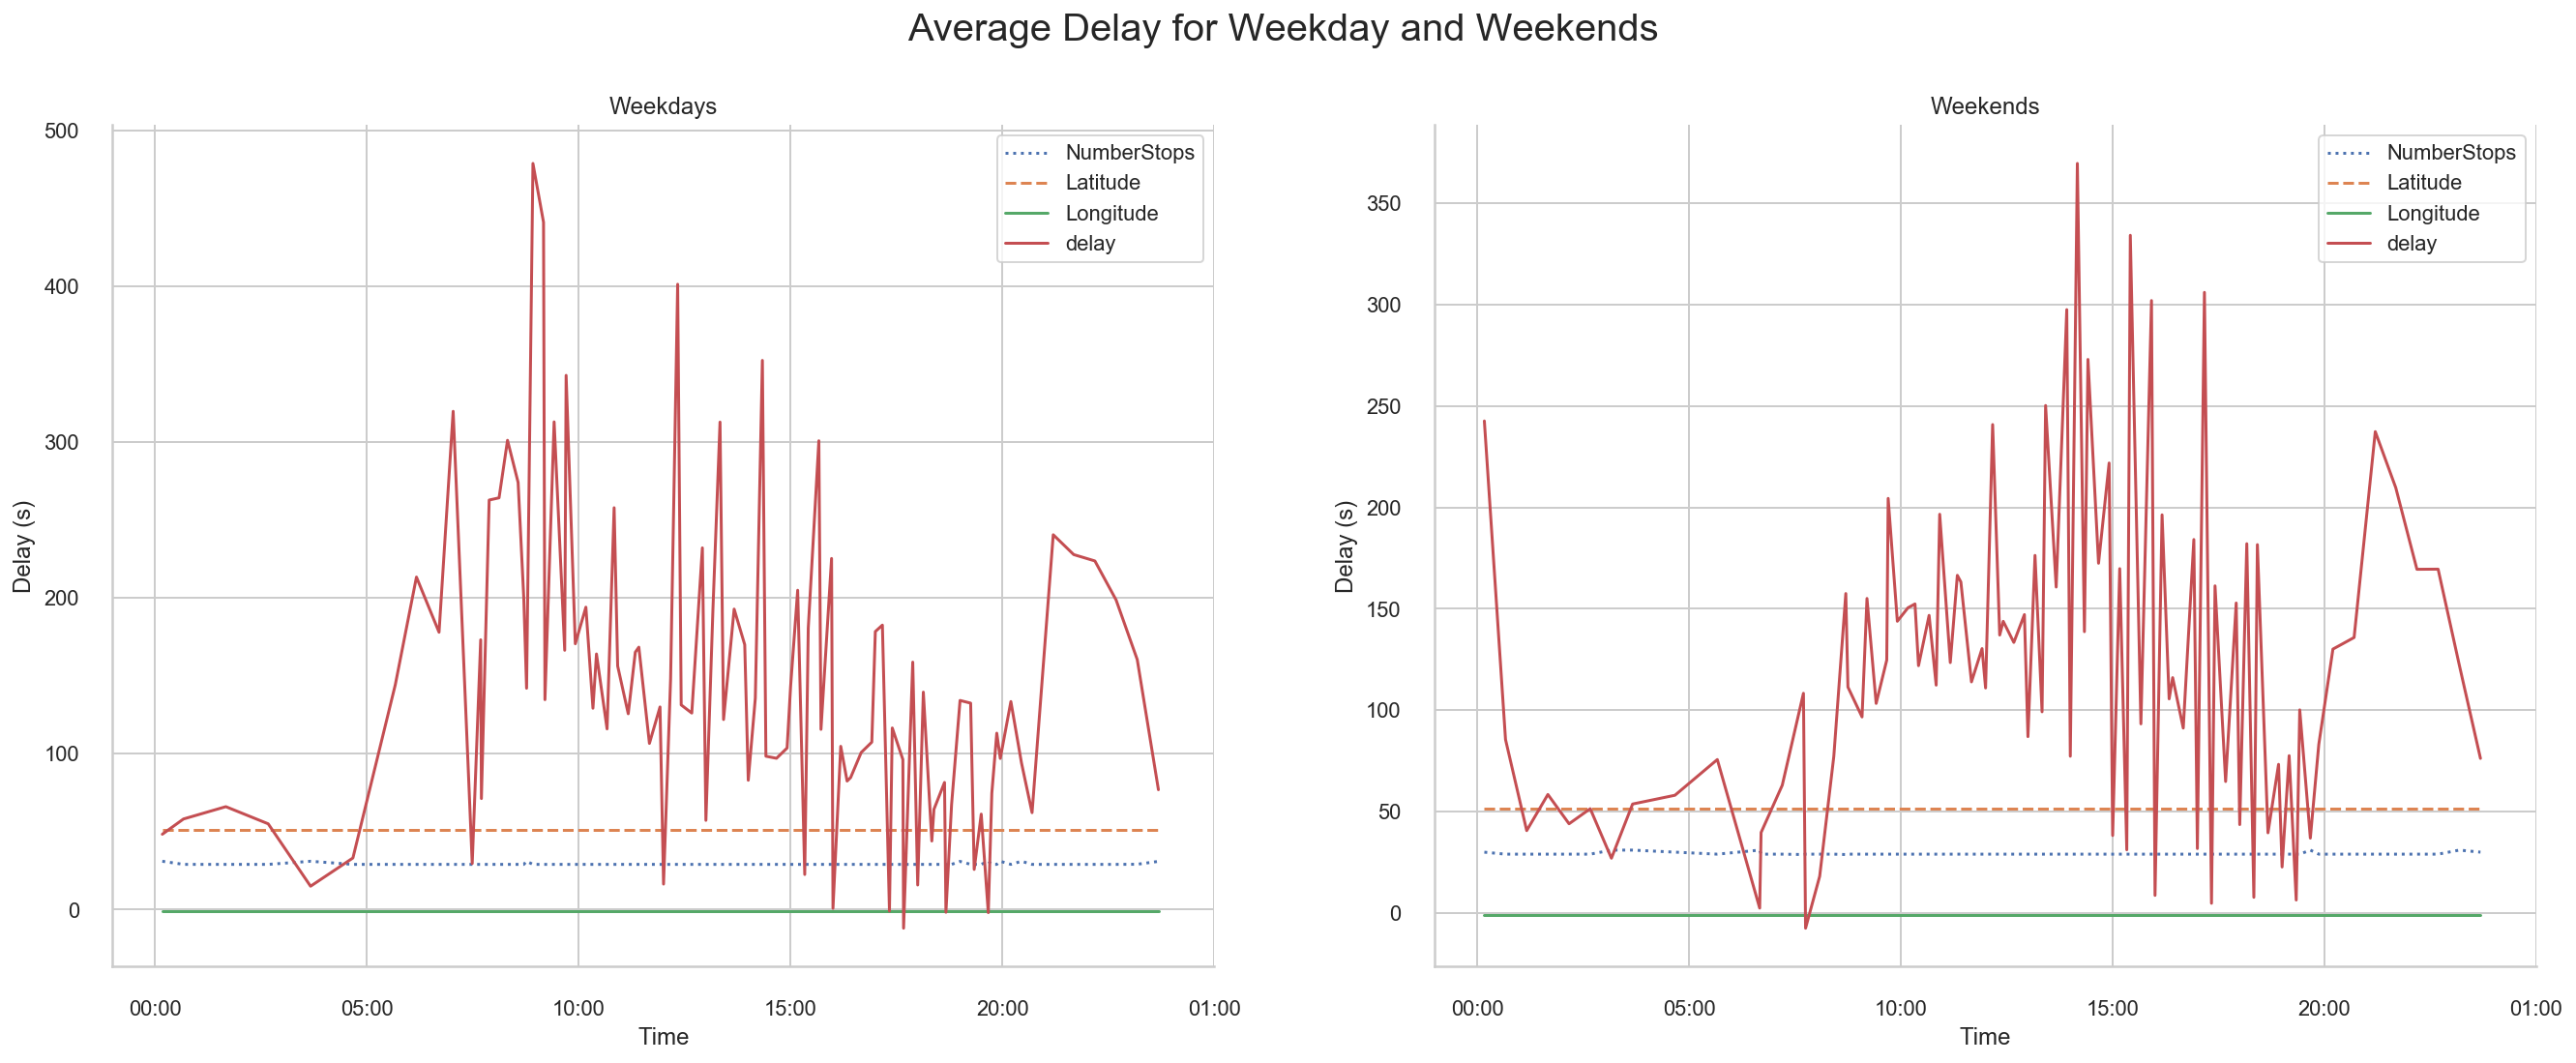

In [379]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus21_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Chancellors Way Bus Stop

In [85]:
bus_21 = bus_data.loc[(bus_data['LocationName'] == "Chancellor's Way") & (bus_data['LineRef'] == '21')]

In [86]:
date_after = pd.Timestamp(2018, 6, 1, 0)
date_after

Timestamp('2018-06-01 00:00:00')

In [87]:
bus_21 = bus_21.loc[bus_21['ScheduledArrivalTime'] < date_after]

In [56]:
bus_21 = bus_21.loc[(bus_21['ScheduledArrivalTime'] > '2018-05-31 00:00:00') & (bus_21['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [88]:
bus_21.head()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
266758      21  39025500001  Chancellor's Way  2018-01-01 04:40:00   
266811      21  39025500001  Chancellor's Way  2018-01-01 05:40:00   
266864      21  39025500001  Chancellor's Way  2018-01-01 06:42:00   
266917      21  39025500001  Chancellor's Way  2018-01-01 07:42:00   
266970      21  39025500001  Chancellor's Way  2018-01-01 08:42:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
266758    2018-01-01 04:40:00 2018-01-01 04:39:45 2018-01-01 04:39:55   
266811    2018-01-01 05:40:00 2018-01-01 05:41:10 2018-01-01 05:41:22   
266864    2018-01-01 06:42:00 2018-01-01 06:42:34 2018-01-01 06:42:45   
266917    2018-01-01 07:42:00 2018-01-01 07:42:34 2018-01-01 07:43:17   
266970    2018-01-01 08:42:00 2018-01-01 08:42:04 2018-01-01 08:42:43   

       ServiceGroup  NumberStops     StartPoint         EndPoint  Latitude  \
266758       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266811       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266864       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266917       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266970       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   

        Longitude   ArrivalWaitTime DepartureWaitTime  
266758    -0.9526 -1 days +23:59:45 -1 days +23:59:55  
266811    -0.9526          00:01:10          00:01:22  
266864    -0.9526          00:00:34          00:00:45  
266917    -0.9526          00:00:34          00:01:17  
266970    -0.9526          00:00:04          00:00:43

In [89]:
bus_21.tail()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
2719002      21  39025500001  Chancellor's Way  2018-05-31 19:45:00   
2719103      21  39025500001  Chancellor's Way  2018-05-31 20:12:00   
2719153      21  39025500001  Chancellor's Way  2018-05-31 20:27:00   
2719257      21  39025500001  Chancellor's Way  2018-05-31 21:12:00   
2719404      21  39025500001  Chancellor's Way  2018-05-31 22:41:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2719002    2018-05-31 19:45:00 2018-05-31 19:51:39 2018-05-31 19:51:40   
2719103    2018-05-31 20:12:00 2018-05-31 20:14:22 2018-05-31 20:14:22   
2719153    2018-05-31 20:27:00 2018-05-31 20:30:00 2018-05-31 20:30:00   
2719257    2018-05-31 21:12:00 2018-05-31 21:18:04 2018-05-31 21:18:04   
2719404    2018-05-31 22:41:00 2018-05-31 22:49:13 2018-05-31 22:49:13   

        ServiceGroup  NumberStops     StartPoint                 EndPoint  \
2719002       Claret           29  Chilcombe Way   St Marys Butts stop CR   
2719103       Claret           29  Chilcombe Way   St Marys Butts stop CR   
2719153       Claret           31  Chilcombe Way  Blagrave Street stop EK   
2719257       Claret           29  Chilcombe Way   St Marys Butts stop CR   
2719404       Claret           29  Chilcombe Way   St Marys Butts stop CR   

         Latitude  Longitude ArrivalWaitTime DepartureWaitTime  
2719002   51.4407    -0.9526        00:06:39          00:06:40  
2719103   51.4407    -0.9526        00:02:22          00:02:22  
2719153   51.4407    -0.9526        00:03:00          00:03:00  
2719257   51.4407    -0.9526        00:06:04          00:06:04  
2719404   51.4407    -0.9526        00:08:13          00:08:13

In [90]:
LineRef = pd.DataFrame()
LineRef = bus_21
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [91]:
LineRef.head()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
266758      21  39025500001  Chancellor's Way  2018-01-01 04:40:00   
266811      21  39025500001  Chancellor's Way  2018-01-01 05:40:00   
266864      21  39025500001  Chancellor's Way  2018-01-01 06:42:00   
266917      21  39025500001  Chancellor's Way  2018-01-01 07:42:00   
266970      21  39025500001  Chancellor's Way  2018-01-01 08:42:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
266758    2018-01-01 04:40:00 2018-01-01 04:39:45 2018-01-01 04:39:55   
266811    2018-01-01 05:40:00 2018-01-01 05:41:10 2018-01-01 05:41:22   
266864    2018-01-01 06:42:00 2018-01-01 06:42:34 2018-01-01 06:42:45   
266917    2018-01-01 07:42:00 2018-01-01 07:42:34 2018-01-01 07:43:17   
266970    2018-01-01 08:42:00 2018-01-01 08:42:04 2018-01-01 08:42:43   

       ServiceGroup  NumberStops     StartPoint         EndPoint  Latitude  \
266758       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266811       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266864       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266917       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266970       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   

        Longitude   ArrivalWaitTime DepartureWaitTime    delay  
266758    -0.9526 -1 days +23:59:45 -1 days +23:59:55 -15.0000  
266811    -0.9526          00:01:10          00:01:22  70.0000  
266864    -0.9526          00:00:34          00:00:45  34.0000  
266917    -0.9526          00:00:34          00:01:17  34.0000  
266970    -0.9526          00:00:04          00:00:43   4.0000

In [92]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

9878

In [93]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

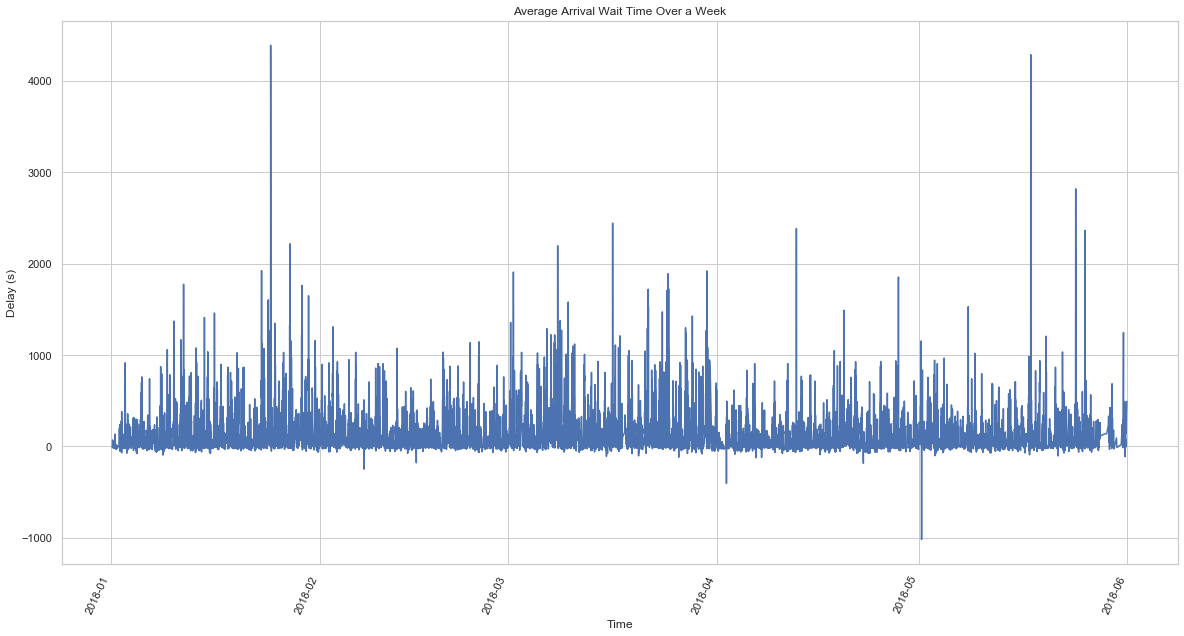

In [94]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [77]:
plt.savefig('output.png')

<Figure size 432x288 with 0 Axes>

In [78]:
#LineRef.to_csv('LSTM_test.csv')

In [79]:
#%config InlineBackend.figure_format = 'retina'

#import matplotlib as mpl
#import matplotlib.pyplot as plt

#plt.ion()

#mpl.rcParams['axes.labelsize'] = 20
#mpl.rcParams['axes.titlesize'] = 24
#mpl.rcParams['figure.figsize'] = (10, 5)
#mpl.rcParams['xtick.labelsize'] = 12
#mpl.rcParams['ytick.labelsize'] = 12
#mpl.rcParams['legend.fontsize'] = 12

In [85]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [81]:
bus_21.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_21.sort_index(inplace=True)
bus_21.head()

LineRef LocationCode      LocationName  \
ScheduledArrivalTime                                          
2018-01-01 04:40:00       21  39025500001  Chancellor's Way   
2018-01-01 05:40:00       21  39025500001  Chancellor's Way   
2018-01-01 06:42:00       21  39025500001  Chancellor's Way   
2018-01-01 07:42:00       21  39025500001  Chancellor's Way   
2018-01-01 08:42:00       21  39025500001  Chancellor's Way   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-01 04:40:00     2018-01-01 04:40:00 2018-01-01 04:39:45   
2018-01-01 05:40:00     2018-01-01 05:40:00 2018-01-01 05:41:10   
2018-01-01 06:42:00     2018-01-01 06:42:00 2018-01-01 06:42:34   
2018-01-01 07:42:00     2018-01-01 07:42:00 2018-01-01 07:42:34   
2018-01-01 08:42:00     2018-01-01 08:42:00 2018-01-01 08:42:04   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-01 04:40:00  2018-01-01 04:39:55       Claret           29   
2018-01-01 05:40:00  2018-01-01 05:41:22       Claret           29   
2018-01-01 06:42:00  2018-01-01 06:42:45       Claret           29   
2018-01-01 07:42:00  2018-01-01 07:43:17       Claret           29   
2018-01-01 08:42:00  2018-01-01 08:42:43       Claret           29   

                         StartPoint         EndPoint  Latitude  Longitude  \
ScheduledArrivalTime                                                        
2018-01-01 04:40:00   Chilcombe Way  St Mary's Butts   51.4407    -0.9526   
2018-01-01 05:40:00   Chilcombe Way  St Mary's Butts   51.4407    -0.9526   
2018-01-01 06:42:00   Chilcombe Way  St Mary's Butts   51.4407    -0.9526   
2018-01-01 07:42:00   Chilcombe Way  St Mary's Butts   51.4407    -0.9526   
2018-01-01 08:42:00   Chilcombe Way  St Mary's Butts   51.4407    -0.9526   

                       ArrivalWaitTime DepartureWaitTime    delay  
ScheduledArrivalTime                                               
2018-01-01 04:40:00  -1 days +23:59:45 -1 days +23:59:55 -15.0000  
2018-01-01 05:40:00           00:01:10          00:01:22  70.0000  
2018-01-01 06:42:00           00:00:34          00:00:45  34.0000  
2018-01-01 07:42:00           00:00:34          00:01:17  34.0000  
2018-01-01 08:42:00           00:00:04          00:00:43   4.0000

In [82]:
y = bus_21.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-01 04:00:00   -15.0000
2018-01-01 05:00:00    70.0000
2018-01-01 06:00:00    34.0000
2018-01-01 07:00:00    34.0000
2018-01-01 08:00:00     4.0000
Freq: H, Name: delay, dtype: float64

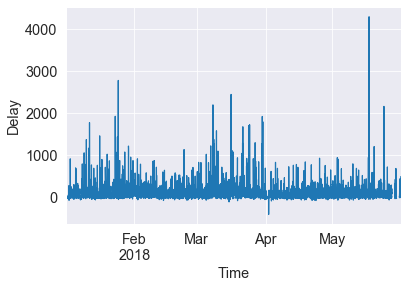

In [83]:
ax = y.plot();
ax.set_ylabel('Delay');

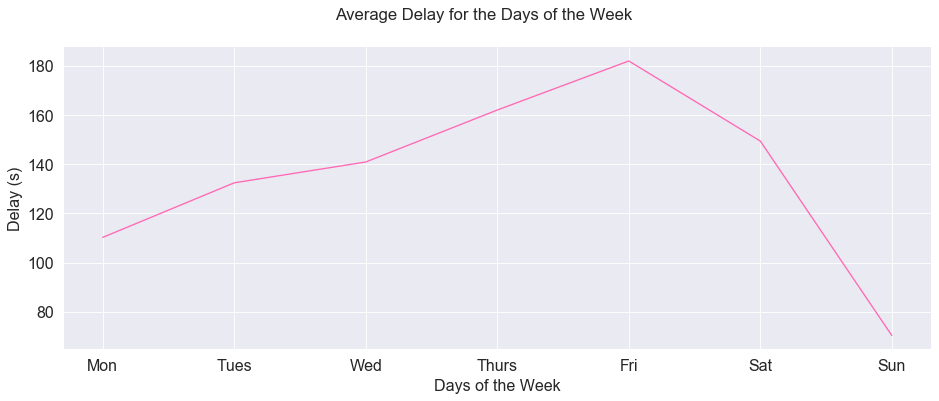

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus21_chancelor_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [85]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

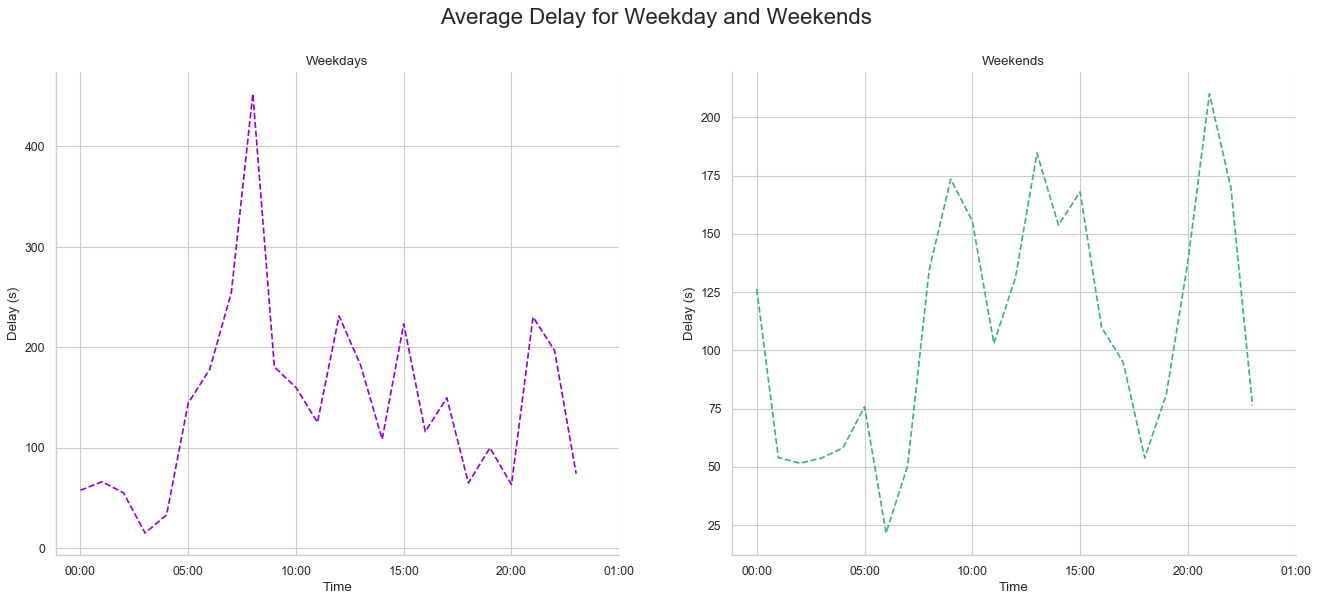

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus21_chancelor_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

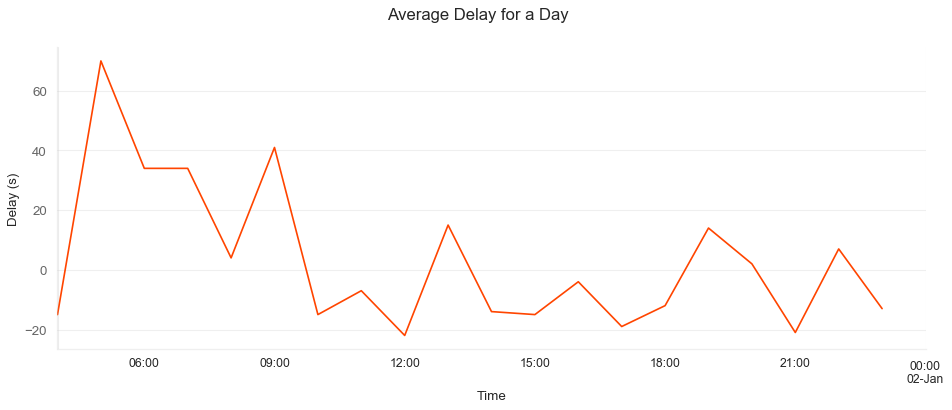

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-01-01 00:00:00':'2018-01-02 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus21_chancelor_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

In [95]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [96]:
bus_21p = bus_21

In [97]:
bus_21p.describe()

NumberStops   Latitude  Longitude         ArrivalWaitTime  \
count   10128.0000 10128.0000 10128.0000                   10128   
mean       29.1910    51.4407    -0.9526  0 days 00:02:26.298479   
std         0.5915     0.0000     0.0000  0 days 00:04:04.070966   
min        25.0000    51.4407    -0.9526       -1 days +23:43:02   
25%        29.0000    51.4407    -0.9526         0 days 00:00:06   
50%        29.0000    51.4407    -0.9526         0 days 00:01:14   
75%        29.0000    51.4407    -0.9526         0 days 00:03:17   
max        31.0000    51.4407    -0.9526         0 days 01:13:08   

            DepartureWaitTime      delay  
count                   10128 10128.0000  
mean   0 days 00:02:44.287124   146.2985  
std    0 days 00:04:05.891324   244.0710  
min         -1 days +23:43:39 -1018.0000  
25%           0 days 00:00:23     6.0000  
50%           0 days 00:01:31    74.0000  
75%           0 days 00:03:37   197.0000  
max           0 days 01:13:20  4388.0000

In [98]:
bus_21p.dtypes

LineRef                            object
LocationCode                       object
LocationName                       object
ScheduledArrivalTime       datetime64[ns]
ScheduledDepartureTime     datetime64[ns]
ArrivalTime                datetime64[ns]
DepartureTime              datetime64[ns]
ServiceGroup                       object
NumberStops                         int64
StartPoint                         object
EndPoint                           object
Latitude                          float64
Longitude                         float64
ArrivalWaitTime           timedelta64[ns]
DepartureWaitTime         timedelta64[ns]
delay                             float64
dtype: object

In [99]:
bus_21p.head()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
266758      21  39025500001  Chancellor's Way  2018-01-01 04:40:00   
266811      21  39025500001  Chancellor's Way  2018-01-01 05:40:00   
266864      21  39025500001  Chancellor's Way  2018-01-01 06:42:00   
266917      21  39025500001  Chancellor's Way  2018-01-01 07:42:00   
266970      21  39025500001  Chancellor's Way  2018-01-01 08:42:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
266758    2018-01-01 04:40:00 2018-01-01 04:39:45 2018-01-01 04:39:55   
266811    2018-01-01 05:40:00 2018-01-01 05:41:10 2018-01-01 05:41:22   
266864    2018-01-01 06:42:00 2018-01-01 06:42:34 2018-01-01 06:42:45   
266917    2018-01-01 07:42:00 2018-01-01 07:42:34 2018-01-01 07:43:17   
266970    2018-01-01 08:42:00 2018-01-01 08:42:04 2018-01-01 08:42:43   

       ServiceGroup  NumberStops     StartPoint         EndPoint  Latitude  \
266758       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266811       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266864       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266917       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   
266970       Claret           29  Chilcombe Way  St Mary's Butts   51.4407   

        Longitude   ArrivalWaitTime DepartureWaitTime    delay  
266758    -0.9526 -1 days +23:59:45 -1 days +23:59:55 -15.0000  
266811    -0.9526          00:01:10          00:01:22  70.0000  
266864    -0.9526          00:00:34          00:00:45  34.0000  
266917    -0.9526          00:00:34          00:01:17  34.0000  
266970    -0.9526          00:00:04          00:00:43   4.0000

In [69]:
# extracting time from timestamp
#bus_21p['Time'] = [datetime.datetime.time(d) for d in bus_21p['ScheduledArrivalTime']] 

In [70]:
#bus_21p.head(10)

LineRef LocationCode      LocationName ScheduledArrivalTime  \
2716080      21  39025500001  Chancellor's Way  2018-05-31 02:40:00   
2716300      21  39025500001  Chancellor's Way  2018-05-31 06:10:00   
2716371      21  39025500001  Chancellor's Way  2018-05-31 06:42:00   
2716540      21  39025500001  Chancellor's Way  2018-05-31 07:41:00   
2716568      21  39025500001  Chancellor's Way  2018-05-31 07:53:00   
2716666      21  39025500001  Chancellor's Way  2018-05-31 08:19:00   
2716738      21  39025500001  Chancellor's Way  2018-05-31 08:34:00   
2716915      21  39025500001  Chancellor's Way  2018-05-31 09:25:00   
2716966      21  39025500001  Chancellor's Way  2018-05-31 09:40:00   
2717186      21  39025500001  Chancellor's Way  2018-05-31 10:40:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2716080    2018-05-31 02:40:00 2018-05-31 02:40:21 2018-05-31 02:40:21   
2716300    2018-05-31 06:10:00 2018-05-31 06:13:59 2018-05-31 06:13:59   
2716371    2018-05-31 06:42:00 2018-05-31 06:42:14 2018-05-31 06:42:14   
2716540    2018-05-31 07:41:00 2018-05-31 07:42:03 2018-05-31 07:42:15   
2716568    2018-05-31 07:53:00 2018-05-31 07:52:55 2018-05-31 07:53:05   
2716666    2018-05-31 08:19:00 2018-05-31 08:18:45 2018-05-31 08:18:45   
2716738    2018-05-31 08:34:00 2018-05-31 08:35:04 2018-05-31 08:35:04   
2716915    2018-05-31 09:25:00 2018-05-31 09:29:50 2018-05-31 09:29:51   
2716966    2018-05-31 09:40:00 2018-05-31 09:41:24 2018-05-31 09:41:24   
2717186    2018-05-31 10:40:00 2018-05-31 11:00:45 2018-05-31 11:00:45   

        ServiceGroup  NumberStops     StartPoint                EndPoint  \
2716080       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716300       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716371       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716540       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716568       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716666       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716738       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716915       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2716966       Claret           29  Chilcombe Way  St Marys Butts stop CR   
2717186       Claret           29  Chilcombe Way  St Marys Butts stop CR   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime     delay  \
2716080   51.4407    -0.9526          00:00:21          00:00:21   21.0000   
2716300   51.4407    -0.9526          00:03:59          00:03:59  239.0000   
2716371   51.4407    -0.9526          00:00:14          00:00:14   14.0000   
2716540   51.4407    -0.9526          00:01:03          00:01:15   63.0000   
2716568   51.4407    -0.9526 -1 days +23:59:55          00:00:05   -5.0000   
2716666   51.4407    -0.9526 -1 days +23:59:45 -1 days +23:59:45  -15.0000   
2716738   51.4407    -0.9526          00:01:04          00:01:04   64.0000   
2716915   51.4407    -0.9526          00:04:50          00:04:51  290.0000   
2716966   51.4407    -0.9526          00:01:24          00:01:24   84.0000   
2717186   51.4407    -0.9526          00:20:45          00:20:45 1245.0000   

             Time  
2716080  02:40:00  
2716300  06:10:00  
2716371  06:42:00  
2716540  07:41:00  
2716568  07:53:00  
2716666  08:19:00  
2716738  08:34:00  
2716915  09:25:00  
2716966  09:40:00  
2717186  10:40:00

<Figure size 576x288 with 0 Axes>

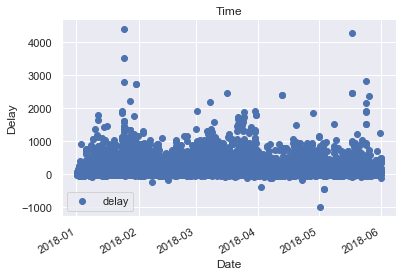

In [100]:
plt.figure(figsize=(8,4))
bus_21p.plot(x='ArrivalTime', y='delay', style='o')  
#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Time')  
plt.xlabel('Date')  
plt.ylabel('Delay')  

plt.show()

Text(0.5, 0, 'Delay (s)')

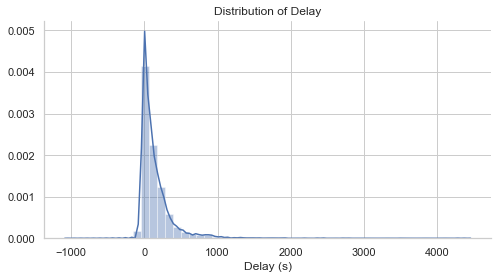

In [101]:
plt.figure(figsize=(8,4))
plt.tight_layout()
seabornInstance.distplot(bus_21p['delay'])

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Distribution of Delay')  
plt.xlabel('Delay (s)')  
#plt.savefig('1day_dist.pdf', bbox_inches='tight', transparent='true')

In [103]:
bus_21p['ScheduledArrivalTime'] = pd.to_datetime(bus_21p['ScheduledArrivalTime']).astype(np.int64)
#bus_21p['Time'] = pd.to_datetime(bus_21p['Time'], format='%H:%M:%S').dt.hour
#bus_21p['delay'] = bus_21p['delay'].apply(np.int64)

In [107]:
x = bus_21p['ScheduledArrivalTime'].values.reshape(-1, 1)
y = bus_21p['delay'].values.reshape(-1, 1)

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(7089, 1) (7089, 1)
(3039, 1) (3039, 1)


In [109]:
x_train

array([[1516255800000000000],
       [1519315080000000000],
       [1527256500000000000],
       ...,
       [1518811920000000000],
       [1527196320000000000],
       [1518161340000000000]], dtype=int64)

In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x) 
x = scaler.transform(x) 

In [111]:
scaler.fit(y) 
y = scaler.transform(y)
y

array([[-0.66089976],
       [-0.3126232 ],
       [-0.46012857],
       ...,
       [ 0.13808764],
       [ 0.89200396],
       [ 1.42056486]])

In [119]:
#training the algorithm
regressor = LinearRegression()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [126]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Square Error:', metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 172.20977295162882
Mean Squared Error: 90116.51816204161
Root Mean Square Error: 90116.51816204161


In [120]:
#To retrieve the intercept:
print('Intercept: \n', regressor.intercept_)
#For retrieving the slope:
print('Coefficients: \n', regressor.coef_)

Intercept: 
 [4950.10453968]
Coefficients: 
 [[-3.1593152e-15]]


In [121]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test) 

In [122]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-0.4645430447435246

In [123]:
bus_21pc = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
bus_21pc.head(15)

Actual  Predicted
0   297.0000   111.0000
1    76.0000     6.0000
2    21.0000   239.0000
3   149.0000   241.0000
4    66.0000   151.0000
5    -7.0000    30.0000
6  1424.0000   731.0000
7    12.0000    55.0000
8    30.0000    96.0000
9   292.0000    65.0000
10   45.0000   190.0000
11   27.0000   326.0000
12   78.0000    -7.0000
13   40.0000    46.6667
14  328.0000   120.0000

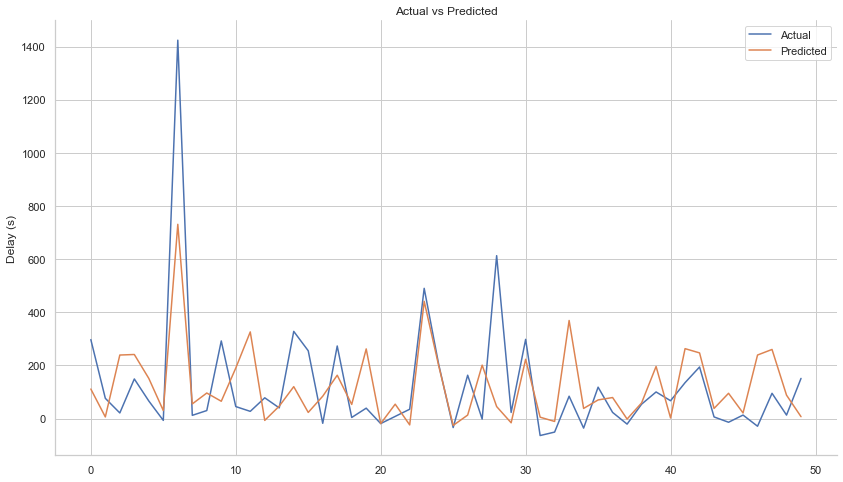

In [124]:
bus_21pc1 = bus_21pc.head(50)
bus_21pc1.plot(kind='line',figsize=(14,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Actual vs Predicted')  
plt.ylabel('Delay (s)')  
#plt.savefig('linpred1day.pdf', bbox_inches='tight', transparent='true')
plt.show()

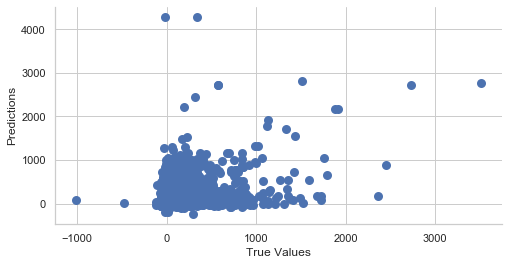

In [146]:
plt.figure(figsize=(8,4))

plt.scatter(y_test, y_pred, label='Linear fit', lw=3)
#plt.plot(y_pred, color='red', linewidth=2)

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

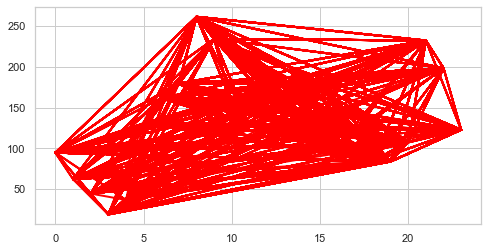

In [52]:
plt.figure(figsize=(8,4))
plt.plot(x_test, y_pred, color='red', linewidth=2)

####  LSTM

In [612]:
df_21 = pd.read_csv('LSTM.csv')

In [613]:
df_21.ScheduledArrivalTime = pd.to_datetime(df_21.ScheduledArrivalTime)
#df_21 = df_21.set_index("ScheduledArrivalTime")

In [614]:
df_21.dtypes

ScheduledArrivalTime    datetime64[ns]
delay                          float64
dtype: object

In [615]:
date_after = pd.Timestamp(2018, 1, 15, 0)
date_after

Timestamp('2018-06-01 00:00:00')

In [616]:
df_21 = df_21.loc[df_21['ScheduledArrivalTime'] < date_after]

In [476]:
df_21 = df_21.loc[(df_21['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (df_21['ScheduledArrivalTime'] <= '2018-06-01 00:00:00')]

In [617]:
df_21.head()

ScheduledArrivalTime    delay
0  2018-01-01 04:40:00 -15.0000
1  2018-01-01 05:40:00  70.0000
2  2018-01-01 06:42:00  34.0000
3  2018-01-01 07:42:00  34.0000
4  2018-01-01 08:42:00   4.0000

In [618]:
df_21.tail()

ScheduledArrivalTime    delay
10123  2018-05-31 19:45:00 399.0000
10124  2018-05-31 20:12:00 142.0000
10125  2018-05-31 20:27:00 180.0000
10126  2018-05-31 21:12:00 364.0000
10127  2018-05-31 22:41:00 493.0000

In [634]:
dataset = df_21.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

8102 2026


In [635]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [636]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [637]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [638]:
X_train.shape

(8071, 1, 30)

In [640]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
#model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [641]:
history = model.fit(X_train, Y_train, epochs=25, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 8071 samples, validate on 1995 samples
Epoch 1/25
8071/8071 [==============================] - 1s 178us/step - loss: 0.0034 - val_loss: 0.0019
Epoch 2/25
8071/8071 [==============================] - 1s 92us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/25
8071/8071 [==============================] - 1s 96us/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/25
8071/8071 [==============================] - 1s 95us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/25
8071/8071 [==============================] - 1s 90us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/25
8071/8071 [==============================] - 1s 94us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/25
8071/8071 [==============================] - 1s 95us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/25
8071/8071 [==============================] - 1s 96us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/25
8071/8071 [==============================] - 1s 98us/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/25
8071/8071 [=

In [642]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 50)                16200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 16,251
Trainable params: 16,251
Non-trainable params: 0
_________________________________________________________________


In [643]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [644]:
print('Train MSE:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test MSE:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train MSE: 229.07696869755102
Test MSE: 222.2191627390639


In [650]:
dataset = pd.DataFrame({'Actual': Y_test.flatten(), 'Predicted': test_predict.flatten()})
dataset.head(10)

Actual  Predicted
0 259.0000   172.6654
1 252.0000   177.6209
2  31.0000   182.6344
3 247.0000   136.8380
4  28.0000   140.8625
5  83.0000   125.3573
6 121.0000   115.6377
7  95.0000    90.5413
8 206.0000    97.0324
9  77.0000   114.9278

<IPython.core.display.Javascript object>


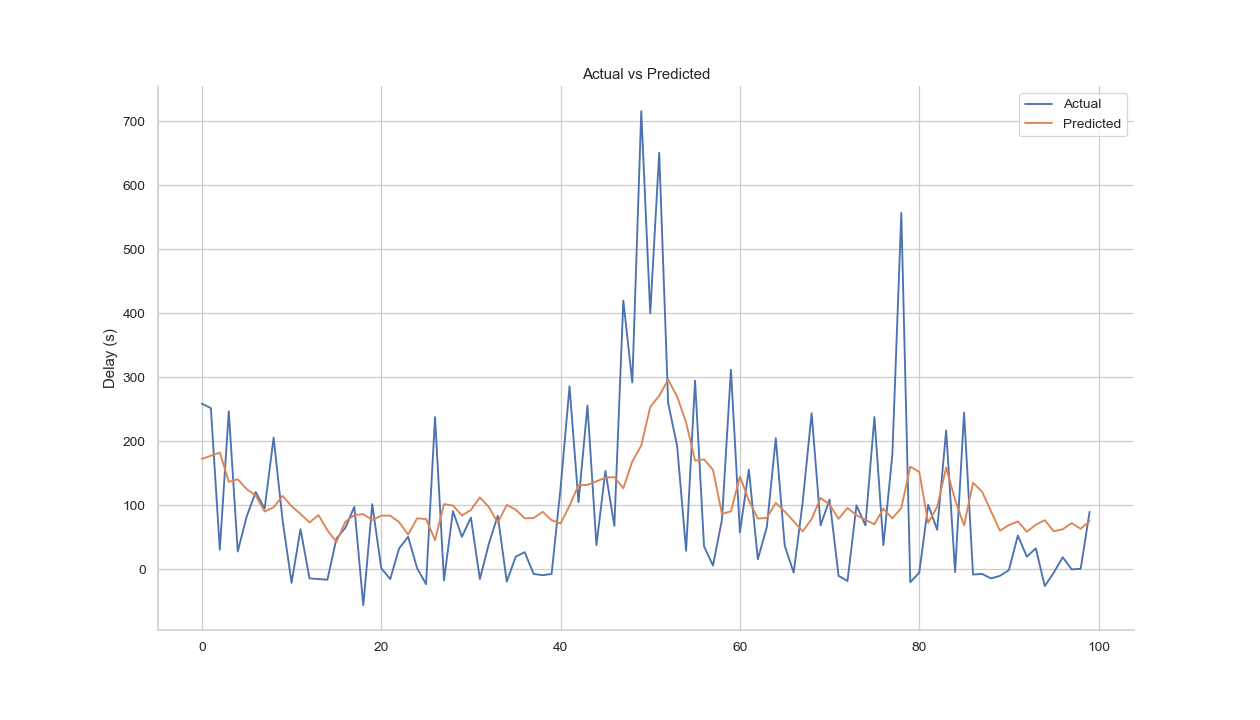

In [649]:
dataset1 = dataset.head(100)
dataset1.plot(kind='line',figsize=(14,8))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Actual vs Predicted')  
plt.ylabel('Delay (s)')  
#plt.savefig('linpred1day.pdf', bbox_inches='tight', transparent='true')
plt.show()

<IPython.core.display.Javascript object>


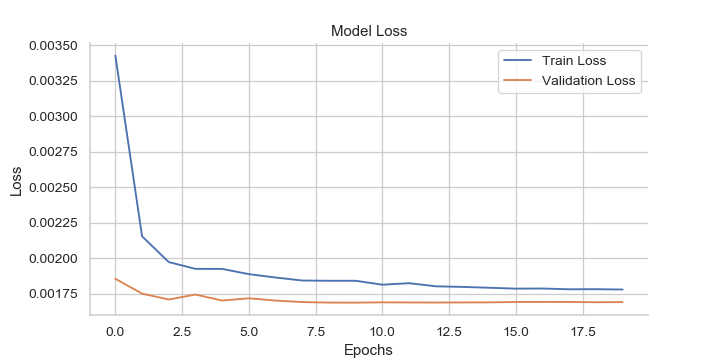

In [647]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
#plt.savefig('losscomsig01.pdf', bbox_inches='tight', transparent='true')
plt.show();

<IPython.core.display.Javascript object>


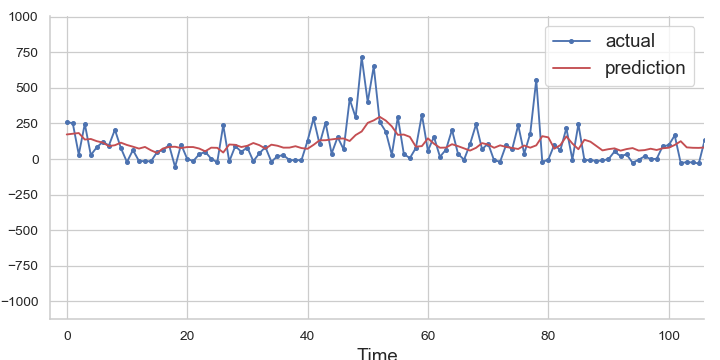

In [648]:
%matplotlib notebook
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
#plt.savefig('predcomsig01.pdf', bbox_inches='tight', transparent='true')
plt.show();

#### Test of LSTM

In [81]:
dataframe = pd.read_csv('LSTM.csv')

In [82]:
dataframe.ScheduledArrivalTime = pd.to_datetime(dataframe.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [83]:
date_after = pd.Timestamp(2018, 2, 1, 0)
date_after

Timestamp('2018-02-01 00:00:00')

In [84]:
dataframe = dataframe.loc[dataframe['ScheduledArrivalTime'] < date_after]

#### LSTM 2

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [82]:
df = pd.read_csv('LSTM.csv')

In [83]:
df.head()

ScheduledArrivalTime  delay
0  2018-01-01 04:40:00  -15.0
1  2018-01-01 05:40:00   70.0
2  2018-01-01 06:42:00   34.0
3  2018-01-01 07:42:00   34.0
4  2018-01-01 08:42:00    4.0

In [84]:
def transport_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [94]:
TRAIN_SPLIT = 5000

In [95]:
tf.random.set_seed(13)

In [96]:
trans_data = df
trans_data = trans_data.set_index("ScheduledArrivalTime")
trans_data.head()

delay
ScheduledArrivalTime       
2018-01-01 04:40:00   -15.0
2018-01-01 05:40:00    70.0
2018-01-01 06:42:00    34.0
2018-01-01 07:42:00    34.0
2018-01-01 08:42:00     4.0

In [97]:
len(trans_data)

10128

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000219AF8F2948>],
      dtype=object)

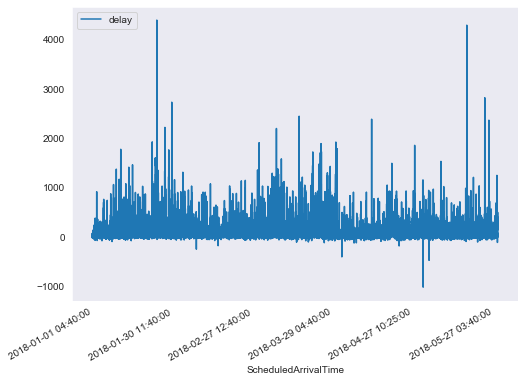

In [98]:
trans_data.plot(subplots=True)

In [99]:
trans_data = trans_data.values

In [100]:
trans_train_mean = trans_data[:TRAIN_SPLIT].mean()
trans_train_std = trans_data[:TRAIN_SPLIT].std()

In [101]:
trans_data = (trans_data-trans_train_mean)/trans_train_std

In [102]:
transport_past_history = 20
transport_future_target = 0

x_train_trans, y_train_trans = transport_data(trans_data, 0, TRAIN_SPLIT,
                                           transport_past_history,
                                           transport_future_target)
x_val_trans, y_val_trans = transport_data(trans_data, TRAIN_SPLIT, None,
                                       transport_past_history,
                                       transport_future_target)

In [104]:
print ('Single window of past history')
print (x_train_trans[0])
print ('\n Target delay to predict')
print (y_train_trans[0])

Single window of past history
[[-0.70296009]
 [-0.36238059]
 [-0.50662602]
 [-0.50662602]
 [-0.62683055]
 [-0.61080328]
 [-0.4785783 ]
 [-0.72700099]
 [-0.70296009]
 [-0.41446922]
 [-0.67090555]
 [-0.67491236]
 [-0.50261921]
 [-0.73100781]
 [-0.61080328]
 [-0.50261921]
 [-0.58275556]
 [-0.10594426]
 [-0.67491236]
 [-0.69895327]]

 Target delay to predict
[-0.61881692]


In [105]:
def create_time_steps(length):
    return list(range(-length, 0))

In [112]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\JxdeF\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

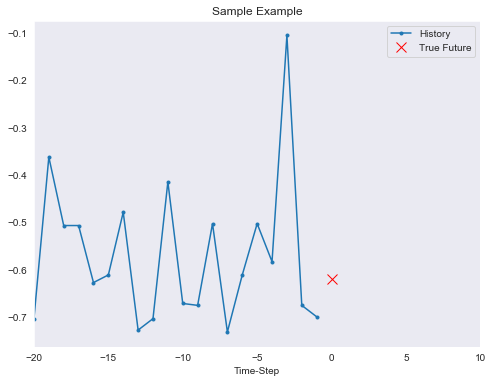

In [113]:
show_plot([x_train_trans[0], y_train_trans[0]], 0, 'Sample Example')

In [114]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\JxdeF\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

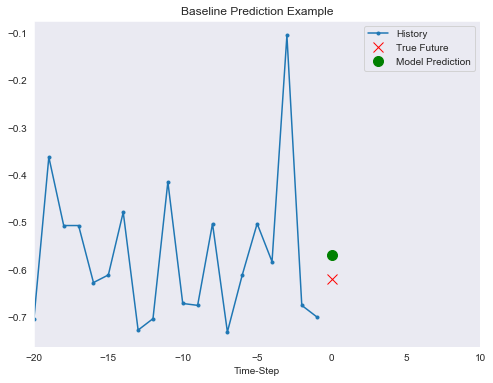

In [115]:
show_plot([x_train_trans[0], y_train_trans[0], baseline(x_train_trans[0])], 0,
           'Baseline Prediction Example')

In [117]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_transport = tf.data.Dataset.from_tensor_slices((x_train_trans, y_train_trans))
train_transport = train_transport.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_transport = tf.data.Dataset.from_tensor_slices((x_val_trans, y_val_trans))
val_transport = val_transport.batch(BATCH_SIZE).repeat()

In [118]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trans.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [119]:
for x, y in val_transport.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [124]:
EVALUATION_INTERVAL = 200
EPOCHS = 30

simple_lstm_model.fit(train_transport, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_transport, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5270 - val_loss: 0.4974
Epoch 2/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5270 - val_loss: 0.4975
Epoch 3/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5271 - val_loss: 0.4973
Epoch 4/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5253 - val_loss: 0.4972
Epoch 5/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5257 - val_loss: 0.4978
Epoch 6/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5258 - val_loss: 0.4980
Epoch 7/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5249 - val_loss: 0.4977
Epoch 8/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5257 - val_loss: 0.4979
Epoch 9/30
200/200 [==============================] - 2s 8ms/step - loss: 0.5246 - val_loss: 0.4980
Epoch 10/30
200/200 [==============================] - 2s

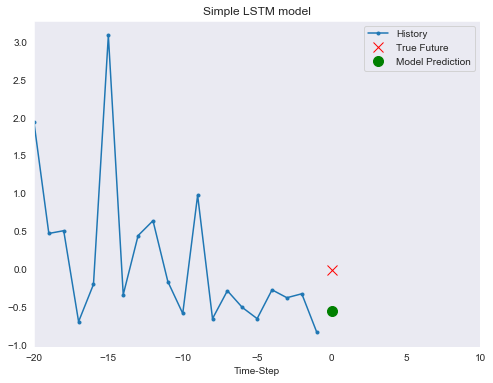

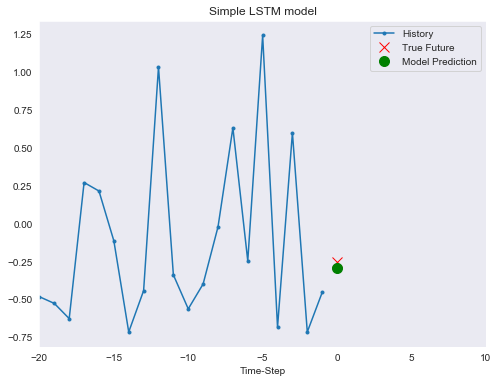

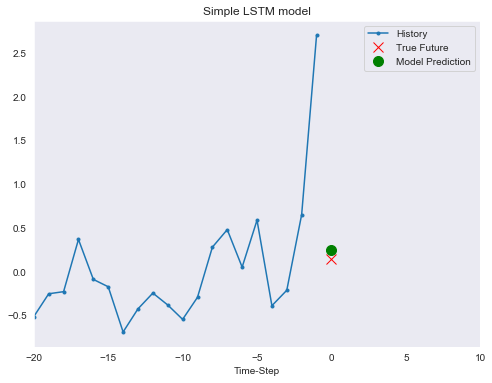

In [127]:
for x, y in val_transport.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Bus 21a

### Dataset Months

In [163]:
bus_21a = bus_data.loc[bus_data['LineRef'] == '21a']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [164]:
# For all dates and first month
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [165]:
bus_21a = bus_21a.loc[bus_21a['ScheduledArrivalTime'] < date_after]

In [166]:
# Between dates
#bus_21a = bus_21a.loc[(bus_21a['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_21a['ScheduledArrivalTime'] <= '2018-06-01 12:00:00')]

In [167]:
bus_21a.head()

LineRef LocationCode                  LocationName  \
1656085     21a  39028150004       Blagrave Street stop EK   
1656086     21a  39026630001          Market Place stop MA   
1656087     21a  39026580002            London Street foot   
1656088     21a  39025810004   Crown Street, London Street   
1656089     21a  39026610001  Kendrick Student Village adj   

        ScheduledArrivalTime ScheduledDepartureTime         ArrivalTime  \
1656085  2018-01-08 08:27:00    2018-01-08 08:27:00 2018-01-08 08:29:58   
1656086  2018-01-08 08:29:00    2018-01-08 08:29:00 2018-01-08 08:39:32   
1656087  2018-01-08 08:30:00    2018-01-08 08:30:00 2018-01-08 08:42:01   
1656088  2018-01-08 08:31:00    2018-01-08 08:31:00 2018-01-08 08:44:09   
1656089  2018-01-08 08:33:00    2018-01-08 08:33:00 2018-01-08 08:46:25   

              DepartureTime ServiceGroup  NumberStops  \
1656085 2018-01-08 08:38:12       Claret           10   
1656086 2018-01-08 08:39:49       Claret           10   
1656087 2018-01-08 08:43:48       Claret           10   
1656088 2018-01-08 08:45:41       Claret           10   
1656089 2018-01-08 08:48:25       Claret           10   

                      StartPoint                   EndPoint  Latitude  \
1656085  Blagrave Street stop EK  Reading University Inside   51.4580   
1656086  Blagrave Street stop EK  Reading University Inside   51.4560   
1656087  Blagrave Street stop EK  Reading University Inside   51.4528   
1656088  Blagrave Street stop EK  Reading University Inside   51.4510   
1656089  Blagrave Street stop EK  Reading University Inside   51.4503   

         Longitude ArrivalWaitTime DepartureWaitTime  
1656085    -0.9713        00:02:58          00:11:12  
1656086    -0.9694        00:10:32          00:10:49  
1656087    -0.9682        00:12:01          00:13:48  
1656088    -0.9673        00:13:09          00:14:41  
1656089    -0.9645        00:13:25          00:15:25

In [168]:
bus_21a.tail()

LineRef LocationCode            LocationName ScheduledArrivalTime  \
2736159     21a  39025810003       London Street Top  2018-05-31 18:39:00   
2736160     21a  39026580001      London Street Foot  2018-05-31 18:40:00   
2736161     21a  39026690003          Minster Street  2018-05-31 18:42:00   
2736162     21a  39027320003  St Marys Butts stop CR  2018-05-31 18:44:00   
2736163     21a  39027760001     West Street stop CU  2018-05-31 18:46:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2736159    2018-05-31 18:39:00 2018-05-31 18:44:04 2018-05-31 18:44:04   
2736160    2018-05-31 18:40:00 2018-05-31 18:44:53 2018-05-31 18:45:06   
2736161    2018-05-31 18:42:00 2018-05-31 18:46:05 2018-05-31 18:46:05   
2736162    2018-05-31 18:44:00 2018-05-31 18:46:51 2018-05-31 18:46:51   
2736163    2018-05-31 18:46:00 2018-05-31 18:48:21 2018-05-31 18:49:33   

        ServiceGroup  NumberStops             StartPoint  \
2736159       Claret           14  Reading University in   
2736160       Claret           14  Reading University in   
2736161       Claret           14  Reading University in   
2736162       Claret           14  Reading University in   
2736163       Claret           14  Reading University in   

                        EndPoint  Latitude  Longitude ArrivalWaitTime  \
2736159  Blagrave Street stop EK   51.4509    -0.9674        00:05:04   
2736160  Blagrave Street stop EK   51.4527    -0.9684        00:04:53   
2736161  Blagrave Street stop EK   51.4546    -0.9717        00:04:05   
2736162  Blagrave Street stop EK   51.4548    -0.9748        00:02:51   
2736163  Blagrave Street stop EK   51.4562    -0.9760        00:02:21   

        DepartureWaitTime  
2736159          00:05:04  
2736160          00:05:06  
2736161          00:04:05  
2736162          00:02:51  
2736163          00:03:33

In [169]:
len(bus_21a)

81208

In [170]:
LineRef = pd.DataFrame()
LineRef = bus_21a
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [171]:
LineRef.head()

LineRef LocationCode                  LocationName  \
1656085     21a  39028150004       Blagrave Street stop EK   
1656086     21a  39026630001          Market Place stop MA   
1656087     21a  39026580002            London Street foot   
1656088     21a  39025810004   Crown Street, London Street   
1656089     21a  39026610001  Kendrick Student Village adj   

        ScheduledArrivalTime ScheduledDepartureTime         ArrivalTime  \
1656085  2018-01-08 08:27:00    2018-01-08 08:27:00 2018-01-08 08:29:58   
1656086  2018-01-08 08:29:00    2018-01-08 08:29:00 2018-01-08 08:39:32   
1656087  2018-01-08 08:30:00    2018-01-08 08:30:00 2018-01-08 08:42:01   
1656088  2018-01-08 08:31:00    2018-01-08 08:31:00 2018-01-08 08:44:09   
1656089  2018-01-08 08:33:00    2018-01-08 08:33:00 2018-01-08 08:46:25   

              DepartureTime ServiceGroup  NumberStops  \
1656085 2018-01-08 08:38:12       Claret           10   
1656086 2018-01-08 08:39:49       Claret           10   
1656087 2018-01-08 08:43:48       Claret           10   
1656088 2018-01-08 08:45:41       Claret           10   
1656089 2018-01-08 08:48:25       Claret           10   

                      StartPoint                   EndPoint  Latitude  \
1656085  Blagrave Street stop EK  Reading University Inside   51.4580   
1656086  Blagrave Street stop EK  Reading University Inside   51.4560   
1656087  Blagrave Street stop EK  Reading University Inside   51.4528   
1656088  Blagrave Street stop EK  Reading University Inside   51.4510   
1656089  Blagrave Street stop EK  Reading University Inside   51.4503   

         Longitude ArrivalWaitTime DepartureWaitTime    delay  
1656085    -0.9713        00:02:58          00:11:12 178.0000  
1656086    -0.9694        00:10:32          00:10:49 632.0000  
1656087    -0.9682        00:12:01          00:13:48 721.0000  
1656088    -0.9673        00:13:09          00:14:41 789.0000  
1656089    -0.9645        00:13:25          00:15:25 805.0000

In [181]:
LineRef = LineRef.groupby(['LocationName']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

KeyError: 'LocationName'

In [44]:
#LineRef.to_csv('bus_21a_may18.csv')

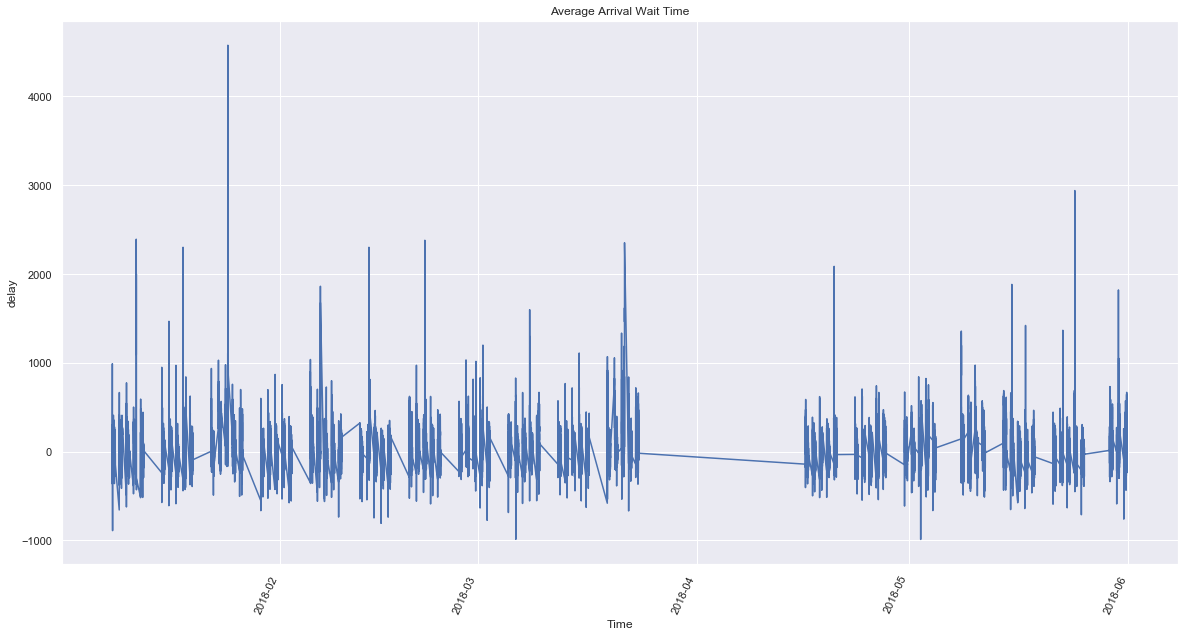

In [173]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show() 

In [174]:
LineRef.head()

NumberStops  Latitude  Longitude    delay
ScheduledArrivalTime                                           
2018-01-08 08:27:00       10.0000   51.4580    -0.9713 178.0000
2018-01-08 08:29:00       10.0000   51.4560    -0.9694 632.0000
2018-01-08 08:30:00       10.0000   51.4528    -0.9682 721.0000
2018-01-08 08:31:00       10.0000   51.4510    -0.9673 789.0000
2018-01-08 08:33:00       10.0000   51.4503    -0.9645 805.0000

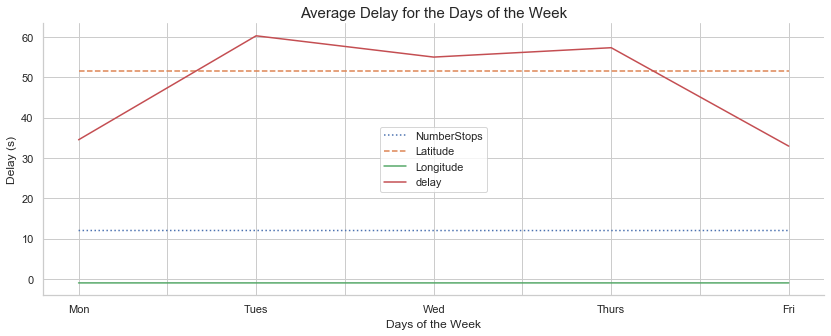

In [180]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus21a_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [177]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

KeyError: 'Weekend'

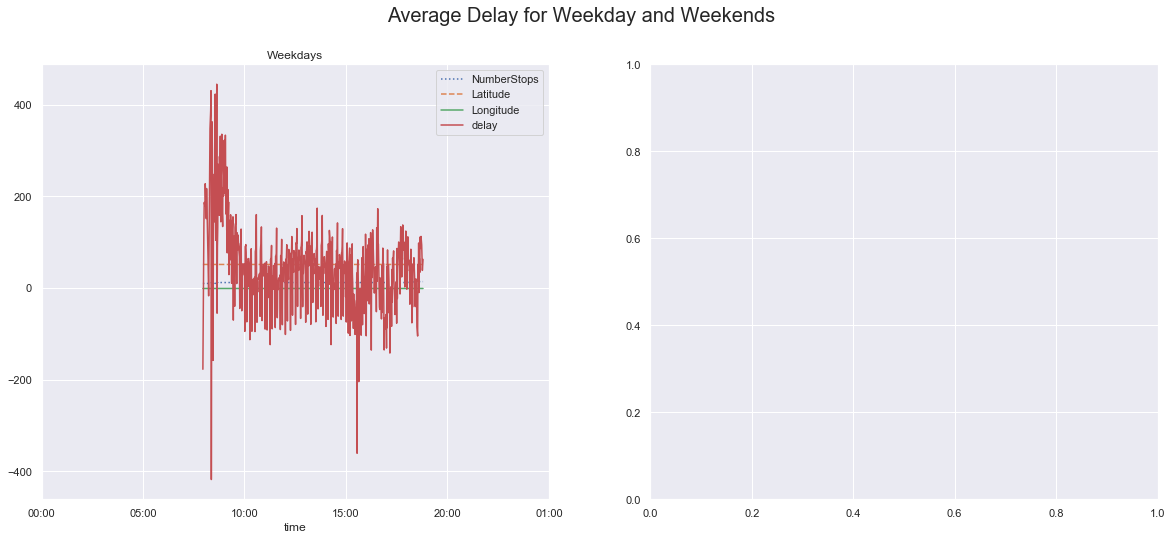

In [178]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus21a_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Chancellors Way Bus Stop

In [106]:
bus_21a = bus_data.loc[(bus_data['LocationName'] == "Chancellor's Way") & (bus_data['LineRef'] == '21a')]

In [107]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [108]:
bus_21a = bus_21a.loc[bus_21a['ScheduledArrivalTime'] < date_after]

In [109]:
#bus_21a = bus_21a.loc[(bus_21a['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_21a['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [110]:
bus_21a.head()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
1656119     21a  39025500001  Chancellor's Way  2018-01-08 09:02:00   
1656155     21a  39025500001  Chancellor's Way  2018-01-08 09:32:00   
1656179     21a  39025500001  Chancellor's Way  2018-01-08 09:47:00   
1656203     21a  39025500001  Chancellor's Way  2018-01-08 10:02:00   
1656227     21a  39025500001  Chancellor's Way  2018-01-08 10:17:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1656119    2018-01-08 09:02:00 2018-01-08 09:03:26 2018-01-08 09:03:34   
1656155    2018-01-08 09:32:00 2018-01-08 09:35:43 2018-01-08 09:36:19   
1656179    2018-01-08 09:47:00 2018-01-08 09:46:58 2018-01-08 09:47:29   
1656203    2018-01-08 10:02:00 2018-01-08 10:02:49 2018-01-08 10:03:06   
1656227    2018-01-08 10:17:00 2018-01-08 10:17:24 2018-01-08 10:17:36   

        ServiceGroup  NumberStops             StartPoint  \
1656119       Claret           12  Reading University in   
1656155       Claret           12  Reading University in   
1656179       Claret           12  Reading University in   
1656203       Claret           12  Reading University in   
1656227       Claret           12  Reading University in   

                       EndPoint  Latitude  Longitude   ArrivalWaitTime  \
1656119  St Marys Butts stop CR   51.4407    -0.9526          00:01:26   
1656155  St Marys Butts stop CR   51.4407    -0.9526          00:03:43   
1656179  St Marys Butts stop CR   51.4407    -0.9526 -1 days +23:59:58   
1656203  St Marys Butts stop CR   51.4407    -0.9526          00:00:49   
1656227  St Marys Butts stop CR   51.4407    -0.9526          00:00:24   

        DepartureWaitTime  
1656119          00:01:34  
1656155          00:04:19  
1656179          00:00:29  
1656203          00:01:06  
1656227          00:00:36

In [111]:
bus_21a.tail()

LineRef LocationCode      LocationName ScheduledArrivalTime  \
2736034     21a  39025500001  Chancellor's Way  2018-05-31 17:03:00   
2736077     21a  39025500001  Chancellor's Way  2018-05-31 17:33:00   
2736110     21a  39025500001  Chancellor's Way  2018-05-31 17:48:00   
2736121     21a  39025500001  Chancellor's Way  2018-05-31 18:03:00   
2736155     21a  39025500001  Chancellor's Way  2018-05-31 18:33:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2736034    2018-05-31 17:03:00 2018-05-31 17:06:31 2018-05-31 17:06:31   
2736077    2018-05-31 17:33:00 2018-05-31 17:36:28 2018-05-31 17:36:28   
2736110    2018-05-31 17:48:00 2018-05-31 17:58:03 2018-05-31 17:58:03   
2736121    2018-05-31 18:03:00 2018-05-31 18:03:45 2018-05-31 18:03:45   
2736155    2018-05-31 18:33:00 2018-05-31 18:39:49 2018-05-31 18:39:49   

        ServiceGroup  NumberStops             StartPoint  \
2736034       Claret           12  Reading University in   
2736077       Claret           12  Reading University in   
2736110       Claret           12  Reading University in   
2736121       Claret           14  Reading University in   
2736155       Claret           14  Reading University in   

                        EndPoint  Latitude  Longitude ArrivalWaitTime  \
2736034   St Marys Butts stop CR   51.4407    -0.9526        00:03:31   
2736077   St Marys Butts stop CR   51.4407    -0.9526        00:03:28   
2736110   St Marys Butts stop CR   51.4407    -0.9526        00:10:03   
2736121  Blagrave Street stop EK   51.4407    -0.9526        00:00:45   
2736155  Blagrave Street stop EK   51.4407    -0.9526        00:06:49   

        DepartureWaitTime  
2736034          00:03:31  
2736077          00:03:28  
2736110          00:10:03  
2736121          00:00:45  
2736155          00:06:49

In [112]:
LineRef = pd.DataFrame()
LineRef = bus_21a
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [135]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

3448

In [136]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

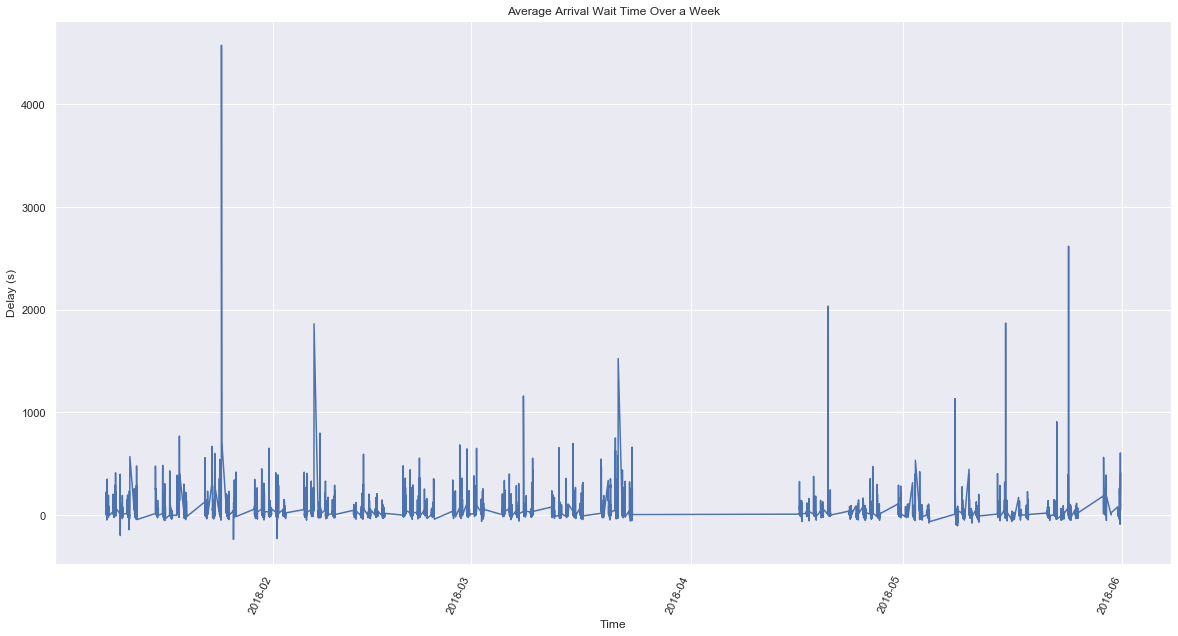

In [137]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [ ]:
#plt.savefig('output.png')

In [117]:
LineRef.to_csv('LSTM_21a.csv')

In [138]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [139]:
bus_21a.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_21a.sort_index(inplace=True)
bus_21a.head()

LineRef LocationCode      LocationName  \
ScheduledArrivalTime                                          
2018-01-08 09:02:00      21a  39025500001  Chancellor's Way   
2018-01-08 09:32:00      21a  39025500001  Chancellor's Way   
2018-01-08 09:47:00      21a  39025500001  Chancellor's Way   
2018-01-08 10:02:00      21a  39025500001  Chancellor's Way   
2018-01-08 10:17:00      21a  39025500001  Chancellor's Way   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-08 09:02:00     2018-01-08 09:02:00 2018-01-08 09:03:26   
2018-01-08 09:32:00     2018-01-08 09:32:00 2018-01-08 09:35:43   
2018-01-08 09:47:00     2018-01-08 09:47:00 2018-01-08 09:46:58   
2018-01-08 10:02:00     2018-01-08 10:02:00 2018-01-08 10:02:49   
2018-01-08 10:17:00     2018-01-08 10:17:00 2018-01-08 10:17:24   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-08 09:02:00  2018-01-08 09:03:34       Claret           12   
2018-01-08 09:32:00  2018-01-08 09:36:19       Claret           12   
2018-01-08 09:47:00  2018-01-08 09:47:29       Claret           12   
2018-01-08 10:02:00  2018-01-08 10:03:06       Claret           12   
2018-01-08 10:17:00  2018-01-08 10:17:36       Claret           12   

                                 StartPoint                EndPoint  Latitude  \
ScheduledArrivalTime                                                            
2018-01-08 09:02:00   Reading University in  St Marys Butts stop CR   51.4407   
2018-01-08 09:32:00   Reading University in  St Marys Butts stop CR   51.4407   
2018-01-08 09:47:00   Reading University in  St Marys Butts stop CR   51.4407   
2018-01-08 10:02:00   Reading University in  St Marys Butts stop CR   51.4407   
2018-01-08 10:17:00   Reading University in  St Marys Butts stop CR   51.4407   

                      Longitude   ArrivalWaitTime DepartureWaitTime    delay  
ScheduledArrivalTime                                                          
2018-01-08 09:02:00     -0.9526          00:01:26          00:01:34  86.0000  
2018-01-08 09:32:00     -0.9526          00:03:43          00:04:19 223.0000  
2018-01-08 09:47:00     -0.9526 -1 days +23:59:58          00:00:29  -2.0000  
2018-01-08 10:02:00     -0.9526          00:00:49          00:01:06  49.0000  
2018-01-08 10:17:00     -0.9526          00:00:24          00:00:36  24.0000

In [140]:
y = bus_21a.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-08 09:00:00    -2.0000
2018-01-08 10:00:00   115.0000
2018-01-08 11:00:00    72.0000
2018-01-08 12:00:00    15.0000
2018-01-08 13:00:00    39.0000
Freq: H, Name: delay, dtype: float64

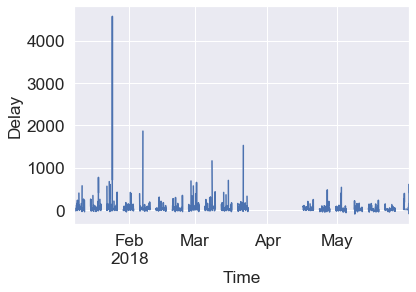

In [141]:
ax = y.plot();
ax.set_ylabel('Delay');

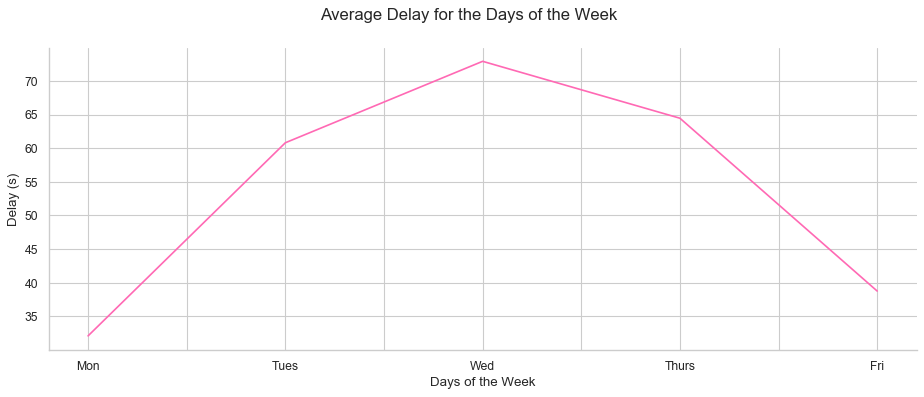

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus21a_chancelor_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [97]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

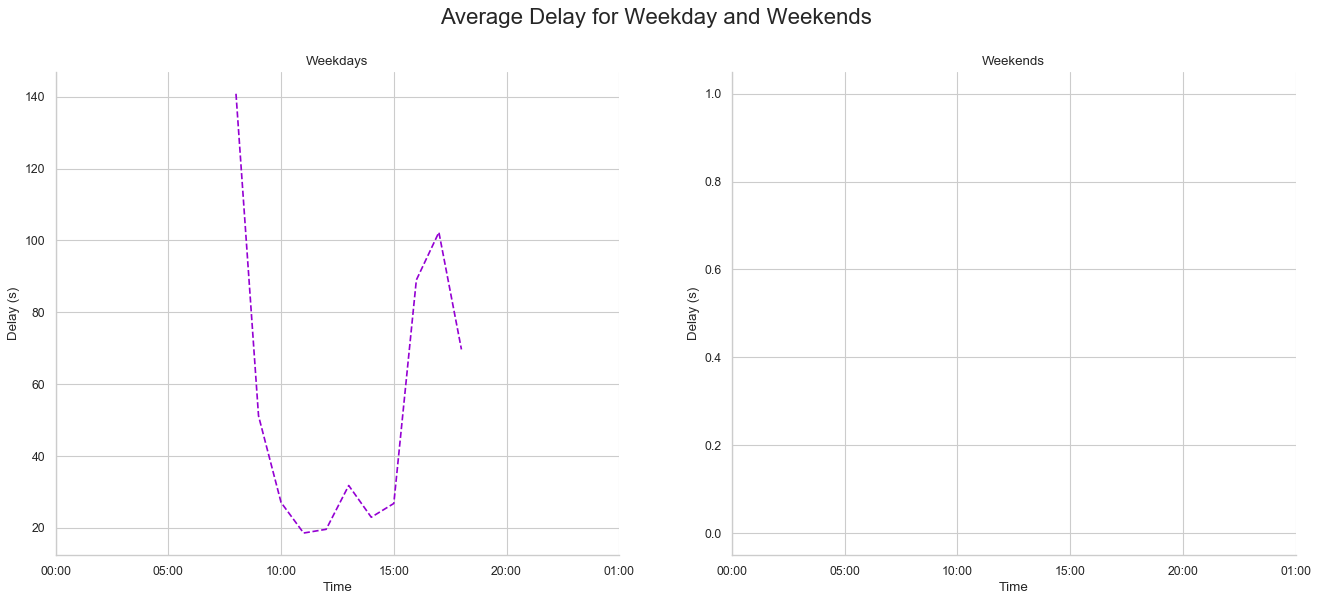

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus21a_chancelor_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

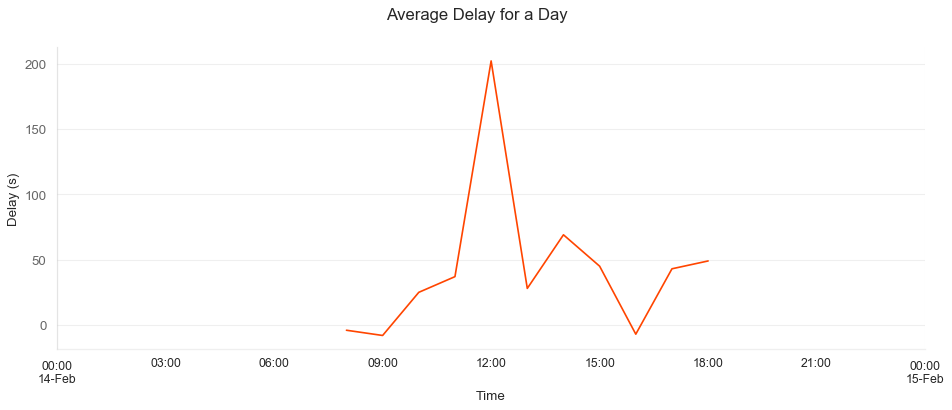

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-02-14 00:00:00':'2018-02-15 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus21a_chancelor_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

#### LSTM

In [50]:
df_21a = pd.read_csv('LSTM_21a.csv')

In [51]:
df_21a.dtypes

ScheduledArrivalTime     object
NumberStops               int64
Latitude                float64
Longitude               float64
delay                   float64
dtype: object

In [52]:
del df_21a['NumberStops']
del df_21a['Latitude']
del df_21a['Longitude']

In [53]:
df_21a.ScheduledArrivalTime = pd.to_datetime(df_21a.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [68]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [69]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [70]:
#df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [71]:
df.head()

ScheduledArrivalTime    delay
0  2018-01-08 09:02:00  86.0000
1  2018-01-08 09:32:00 223.0000
2  2018-01-08 09:47:00  -2.0000
3  2018-01-08 10:02:00  49.0000
4  2018-01-08 10:17:00  24.0000

In [72]:
df.tail()

ScheduledArrivalTime    delay
3443  2018-05-31 17:03:00 211.0000
3444  2018-05-31 17:33:00 208.0000
3445  2018-05-31 17:48:00 603.0000
3446  2018-05-31 18:03:00  45.0000
3447  2018-05-31 18:33:00 409.0000

In [73]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [74]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [75]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [76]:
#reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [77]:
X_train.shape

(2727, 1, 30)

In [78]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [82]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Train on 2727 samples, validate on 659 samples
Epoch 1/20
2727/2727 [==============================] - 0s 42us/step - loss: 9.1650e-04 - val_loss: 0.0010
Epoch 2/20
2727/2727 [==============================] - 0s 40us/step - loss: 9.0892e-04 - val_loss: 0.0010
Epoch 3/20
2727/2727 [==============================] - 0s 57us/step - loss: 9.1945e-04 - val_loss: 0.0010
Epoch 4/20
2727/2727 [==============================] - 0s 59us/step - loss: 9.1538e-04 - val_loss: 0.0010
Epoch 5/20
2727/2727 [==============================] - 0s 56us/step - loss: 9.0797e-04 - val_loss: 0.0010
Epoch 6/20
2727/2727 [==============================] - 0s 58us/step - loss: 9.1885e-04 - val_loss: 0.0010
Epoch 7/20
2727/2727 [==============================] - 0s 61us/step - loss: 9.1503e-04 - val_loss: 0.0010
Epoch 8/20
2727/2727 [==============================] - 0s 60us/step - loss: 9.0928e-04 - val_loss: 0.0010
Epoch 9/20
2727/2727 [==============================] - 0s 55us/step - loss: 9.1046e-04 - val_los

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [84]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 63.56742133680464
Train Root Mean Squared Error: 143.81935733295862
Test Mean Absolute Error: 59.75731878509471
Test Root Mean Squared Error: 155.12891422376367


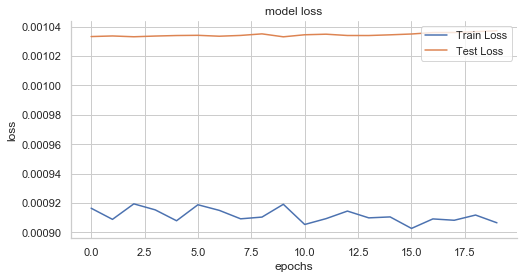

In [85]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

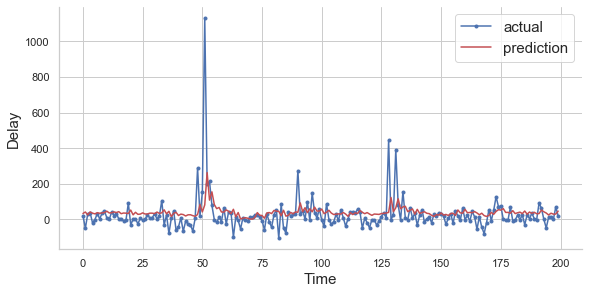

In [86]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
#sns.despine(top=True)

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();

## Bus 3

### Dataset Months

In [118]:
bus_3 = bus_data.loc[bus_data['LineRef'] == '3']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [119]:
# For all dates and first month
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [120]:
bus_3 = bus_3.loc[bus_3['ScheduledArrivalTime'] < date_after]

In [121]:
# Between dates
#bus_3 = bus_3.loc[(bus_3['ScheduledArrivalTime'] > '2018-04-01 00:00:00') & (bus_3['ScheduledArrivalTime'] <= '2018-05-01 12:00:00')]

In [122]:
bus_3.head()

LineRef LocationCode          LocationName ScheduledArrivalTime  \
0       3  39028140001  Station Road Stop SA  2018-01-02 05:50:00   
1       3  39026630001          Market Place  2018-01-02 05:52:00   
2       3  39025920003            Kings Road  2018-01-02 05:53:00   
3       3  39026410003   Huntley and Palmers  2018-01-02 05:54:00   
4       3  39025980003     Eldon Road adj 11  2018-01-02 05:55:00   

  ScheduledDepartureTime         ArrivalTime       DepartureTime ServiceGroup  \
0    2018-01-02 05:50:00 2018-01-02 05:47:42 2018-01-02 05:50:25      Leopard   
1    2018-01-02 05:52:00 2018-01-02 05:52:13 2018-01-02 05:52:37      Leopard   
2    2018-01-02 05:53:00 2018-01-02 05:52:49 2018-01-02 05:53:17      Leopard   
3    2018-01-02 05:54:00 2018-01-02 05:53:39 2018-01-02 05:53:40      Leopard   
4    2018-01-02 05:55:00 2018-01-02 05:55:11 2018-01-02 05:55:12      Leopard   

   NumberStops            StartPoint              EndPoint  Latitude  \
0           56  Station Road Stop SA  Broad Street E-bound   51.4581   
1           56  Station Road Stop SA  Broad Street E-bound   51.4560   
2           56  Station Road Stop SA  Broad Street E-bound   51.4550   
3           56  Station Road Stop SA  Broad Street E-bound   51.4550   
4           56  Station Road Stop SA  Broad Street E-bound   51.4526   

   Longitude   ArrivalWaitTime DepartureWaitTime  
0    -0.9723 -1 days +23:57:42          00:00:25  
1    -0.9694          00:00:13          00:00:37  
2    -0.9683 -1 days +23:59:49          00:00:17  
3    -0.9635 -1 days +23:59:39 -1 days +23:59:40  
4    -0.9586          00:00:11          00:00:12

In [123]:
bus_3.tail()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
2383138       3  35077260001  Ducks Nest Farm  2018-05-31 23:33:40   
2383139       3  35077280001    Rickman Close  2018-05-31 23:34:00   
2383140       3  35077300001        Hill Road  2018-05-31 23:35:00   
2383141       3  35077320001       Biggs Lane  2018-05-31 23:36:00   
2383142       3  35077340001  Sheerlands Road  2018-05-31 23:37:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2383138    2018-05-31 23:33:40 2018-05-31 23:34:09 2018-05-31 23:34:13   
2383139    2018-05-31 23:34:00 2018-05-31 23:34:31 2018-05-31 23:34:32   
2383140    2018-05-31 23:35:00 2018-05-31 23:35:23 2018-05-31 23:35:28   
2383141    2018-05-31 23:36:00 2018-05-31 23:35:00 2018-05-31 23:35:00   
2383142    2018-05-31 23:37:00 2018-05-31 23:36:31 2018-05-31 23:37:28   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
2383138      Leopard           35  St Mary's Butts  Sheerlands Road   51.3906   
2383139      Leopard           35  St Mary's Butts  Sheerlands Road   51.3890   
2383140      Leopard           35  St Mary's Butts  Sheerlands Road   51.3881   
2383141      Leopard           35  St Mary's Butts  Sheerlands Road   51.3868   
2383142      Leopard           35  St Mary's Butts  Sheerlands Road   51.3838   

         Longitude   ArrivalWaitTime DepartureWaitTime  
2383138    -0.9034          00:00:29          00:00:33  
2383139    -0.9019          00:00:31          00:00:32  
2383140    -0.8988          00:00:23          00:00:28  
2383141    -0.8961 -1 days +23:59:00 -1 days +23:59:00  
2383142    -0.8998 -1 days +23:59:31          00:00:28

In [124]:
len(bus_3)

329831

In [125]:
LineRef = pd.DataFrame()
LineRef = bus_3
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [126]:
LineRef.head()

LineRef LocationCode          LocationName ScheduledArrivalTime  \
0       3  39028140001  Station Road Stop SA  2018-01-02 05:50:00   
1       3  39026630001          Market Place  2018-01-02 05:52:00   
2       3  39025920003            Kings Road  2018-01-02 05:53:00   
3       3  39026410003   Huntley and Palmers  2018-01-02 05:54:00   
4       3  39025980003     Eldon Road adj 11  2018-01-02 05:55:00   

  ScheduledDepartureTime         ArrivalTime       DepartureTime ServiceGroup  \
0    2018-01-02 05:50:00 2018-01-02 05:47:42 2018-01-02 05:50:25      Leopard   
1    2018-01-02 05:52:00 2018-01-02 05:52:13 2018-01-02 05:52:37      Leopard   
2    2018-01-02 05:53:00 2018-01-02 05:52:49 2018-01-02 05:53:17      Leopard   
3    2018-01-02 05:54:00 2018-01-02 05:53:39 2018-01-02 05:53:40      Leopard   
4    2018-01-02 05:55:00 2018-01-02 05:55:11 2018-01-02 05:55:12      Leopard   

   NumberStops            StartPoint              EndPoint  Latitude  \
0           56  Station Road Stop SA  Broad Street E-bound   51.4581   
1           56  Station Road Stop SA  Broad Street E-bound   51.4560   
2           56  Station Road Stop SA  Broad Street E-bound   51.4550   
3           56  Station Road Stop SA  Broad Street E-bound   51.4550   
4           56  Station Road Stop SA  Broad Street E-bound   51.4526   

   Longitude   ArrivalWaitTime DepartureWaitTime     delay  
0    -0.9723 -1 days +23:57:42          00:00:25 -138.0000  
1    -0.9694          00:00:13          00:00:37   13.0000  
2    -0.9683 -1 days +23:59:49          00:00:17  -11.0000  
3    -0.9635 -1 days +23:59:39 -1 days +23:59:40  -21.0000  
4    -0.9586          00:00:11          00:00:12   11.0000

In [127]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

149153

In [18]:
#LineRef.to_csv('bus_3_apr18.csv')

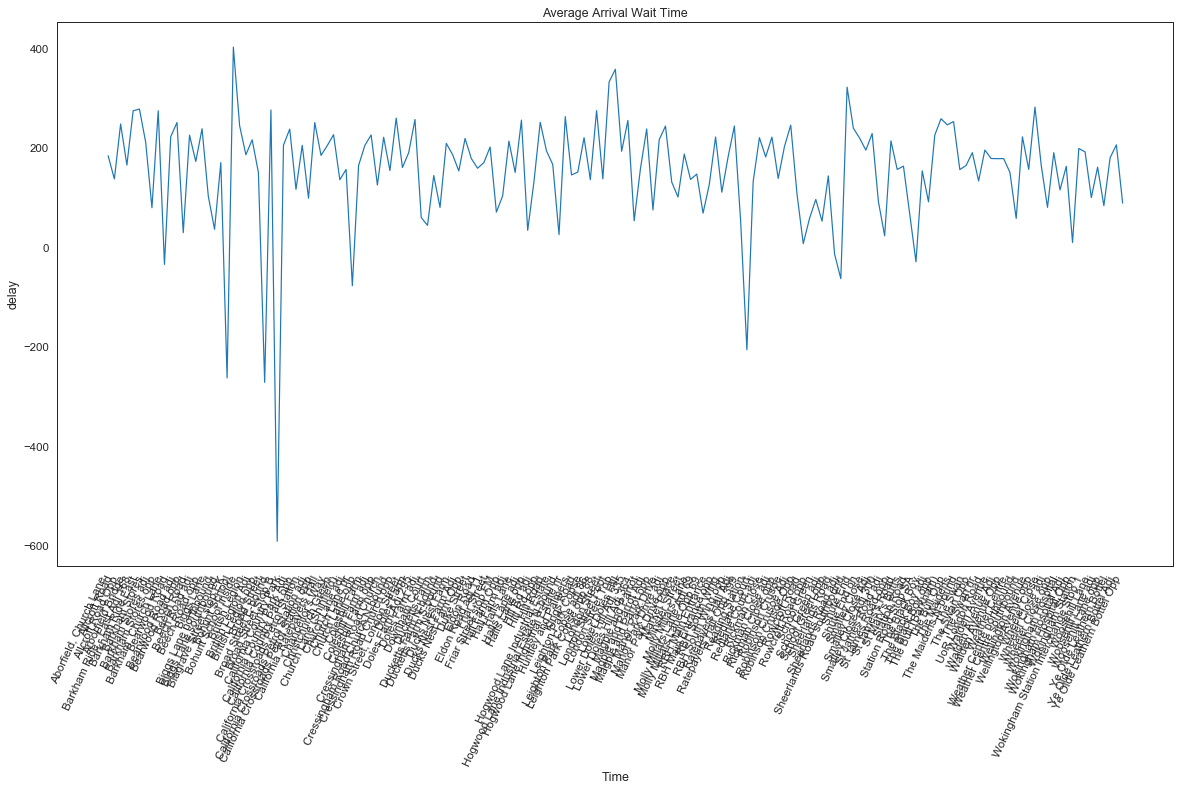

In [19]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show() 

In [128]:
LineRef.head()

NumberStops  Latitude  Longitude     delay
ScheduledArrivalTime                                            
2018-01-02 05:50:00       56.0000   51.4581    -0.9723 -138.0000
2018-01-02 05:52:00       56.0000   51.4560    -0.9694   13.0000
2018-01-02 05:53:00       56.0000   51.4550    -0.9683  -11.0000
2018-01-02 05:54:00       56.0000   51.4550    -0.9635  -21.0000
2018-01-02 05:55:00       45.5000   51.4182    -0.9292  -19.5000

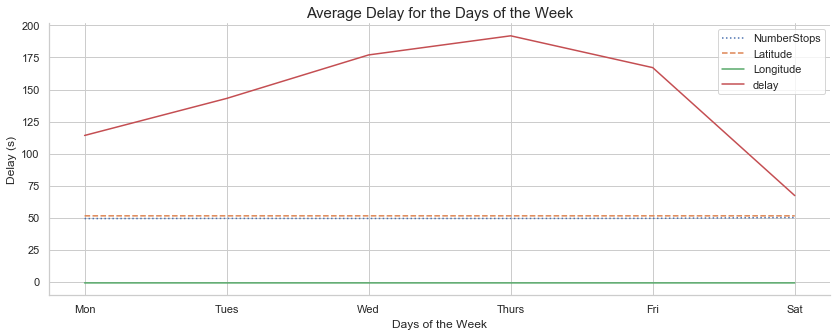

In [132]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus3_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [130]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

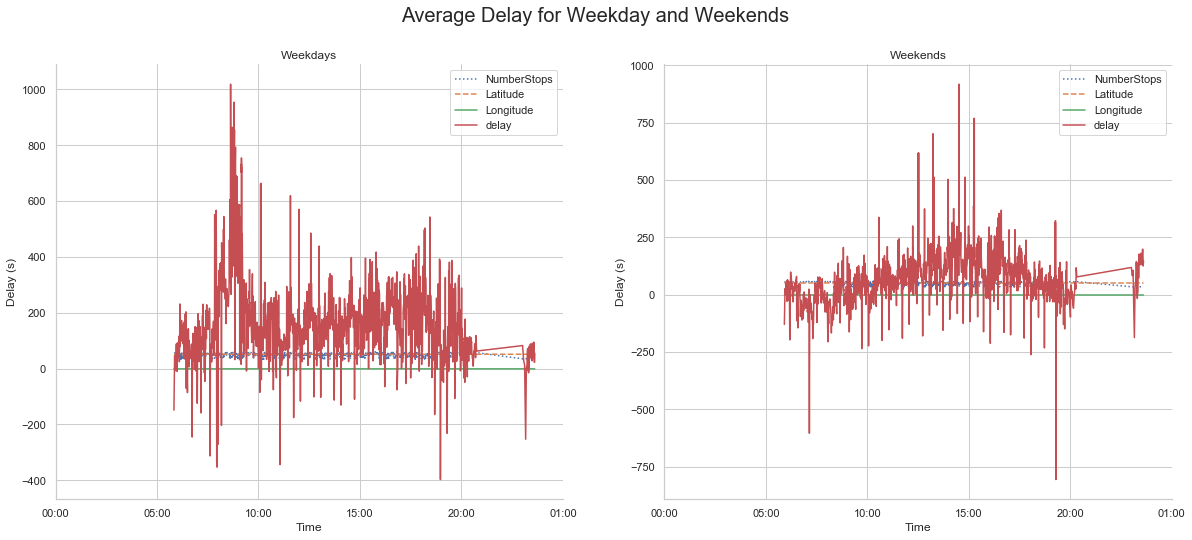

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus3_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Cressingham Road Church Bus Stop

In [93]:
bus_3 = bus_data.loc[(bus_data['LocationName'] == "Cressingham Road Church") & (bus_data['LineRef'] == '3')]

In [94]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [95]:
bus_3 = bus_3.loc[bus_3['ScheduledArrivalTime'] < date_after]

In [96]:
#bus_3 = bus_3.loc[(bus_3['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_3['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [97]:
bus_3.head()

LineRef LocationCode             LocationName ScheduledArrivalTime  \
2320043       3  39025790002  Cressingham Road Church  2018-05-01 06:02:00   
2320101       3  39025790001  Cressingham Road Church  2018-05-01 06:10:00   
2320126       3  39025790002  Cressingham Road Church  2018-05-01 06:12:00   
2320184       3  39025790001  Cressingham Road Church  2018-05-01 06:48:00   
2320212       3  39025790002  Cressingham Road Church  2018-05-01 06:49:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2320043    2018-05-01 06:02:00 2018-05-01 06:02:28 2018-05-01 06:02:29   
2320101    2018-05-01 06:10:00 2018-05-01 06:11:34 2018-05-01 06:11:36   
2320126    2018-05-01 06:12:00 2018-05-01 06:12:06 2018-05-01 06:12:12   
2320184    2018-05-01 06:48:00 2018-05-01 06:52:38 2018-05-01 06:53:32   
2320212    2018-05-01 06:49:00 2018-05-01 06:47:16 2018-05-01 06:47:16   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
2320043      Leopard           56     Station Road     Broad Street   51.4342   
2320101      Leopard           35  Sheerlands Road  St Mary's Butts   51.4342   
2320126      Leopard           33     Station Road  Sheerlands Road   51.4342   
2320184      Leopard           55     Broad Street  St Mary's Butts   51.4342   
2320212      Leopard           56     Station Road     Broad Street   51.4342   

         Longitude   ArrivalWaitTime DepartureWaitTime  
2320043    -0.9485          00:00:28          00:00:29  
2320101    -0.9486          00:01:34          00:01:36  
2320126    -0.9485          00:00:06          00:00:12  
2320184    -0.9486          00:04:38          00:05:32  
2320212    -0.9485 -1 days +23:58:16 -1 days +23:58:16

In [98]:
bus_3.tail()

LineRef LocationCode             LocationName ScheduledArrivalTime  \
2382935       3  39025790001  Cressingham Road Church  2018-05-31 19:18:00   
2382965       3  39025790002  Cressingham Road Church  2018-05-31 19:28:00   
2383046       3  39025790001  Cressingham Road Church  2018-05-31 20:03:00   
2383092       3  39025790001  Cressingham Road Church  2018-05-31 20:29:00   
2383123       3  39025790002  Cressingham Road Church  2018-05-31 23:22:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2382935    2018-05-31 19:18:00 2018-05-31 19:18:32 2018-05-31 19:18:57   
2382965    2018-05-31 19:28:00 2018-05-31 19:35:47 2018-05-31 19:35:48   
2383046    2018-05-31 20:03:00 2018-05-31 20:02:16 2018-05-31 20:02:22   
2383092    2018-05-31 20:29:00 2018-05-31 20:37:03 2018-05-31 20:37:09   
2383123    2018-05-31 23:22:00 2018-05-31 23:23:09 2018-05-31 23:23:15   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
2382935      Leopard           37  Sheerlands Road     Station Road   51.4342   
2382965      Leopard           58  St Mary's Butts     Broad Street   51.4342   
2383046      Leopard           55     Broad Street  St Mary's Butts   51.4342   
2383092      Leopard           57     Broad Street     Station Road   51.4342   
2383123      Leopard           35  St Mary's Butts  Sheerlands Road   51.4342   

         Longitude   ArrivalWaitTime DepartureWaitTime  
2382935    -0.9486          00:00:32          00:00:57  
2382965    -0.9485          00:07:47          00:07:48  
2383046    -0.9486 -1 days +23:59:16 -1 days +23:59:22  
2383092    -0.9486          00:08:03          00:08:09  
2383123    -0.9485          00:01:09          00:01:15

In [99]:
LineRef = pd.DataFrame()
LineRef = bus_3
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [100]:
LineRef.head()

LineRef LocationCode             LocationName ScheduledArrivalTime  \
2320043       3  39025790002  Cressingham Road Church  2018-05-01 06:02:00   
2320101       3  39025790001  Cressingham Road Church  2018-05-01 06:10:00   
2320126       3  39025790002  Cressingham Road Church  2018-05-01 06:12:00   
2320184       3  39025790001  Cressingham Road Church  2018-05-01 06:48:00   
2320212       3  39025790002  Cressingham Road Church  2018-05-01 06:49:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2320043    2018-05-01 06:02:00 2018-05-01 06:02:28 2018-05-01 06:02:29   
2320101    2018-05-01 06:10:00 2018-05-01 06:11:34 2018-05-01 06:11:36   
2320126    2018-05-01 06:12:00 2018-05-01 06:12:06 2018-05-01 06:12:12   
2320184    2018-05-01 06:48:00 2018-05-01 06:52:38 2018-05-01 06:53:32   
2320212    2018-05-01 06:49:00 2018-05-01 06:47:16 2018-05-01 06:47:16   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
2320043      Leopard           56     Station Road     Broad Street   51.4342   
2320101      Leopard           35  Sheerlands Road  St Mary's Butts   51.4342   
2320126      Leopard           33     Station Road  Sheerlands Road   51.4342   
2320184      Leopard           55     Broad Street  St Mary's Butts   51.4342   
2320212      Leopard           56     Station Road     Broad Street   51.4342   

         Longitude   ArrivalWaitTime DepartureWaitTime     delay  
2320043    -0.9485          00:00:28          00:00:29   28.0000  
2320101    -0.9486          00:01:34          00:01:36   94.0000  
2320126    -0.9485          00:00:06          00:00:12    6.0000  
2320184    -0.9486          00:04:38          00:05:32  278.0000  
2320212    -0.9485 -1 days +23:58:16 -1 days +23:58:16 -104.0000

In [101]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

1320

In [102]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

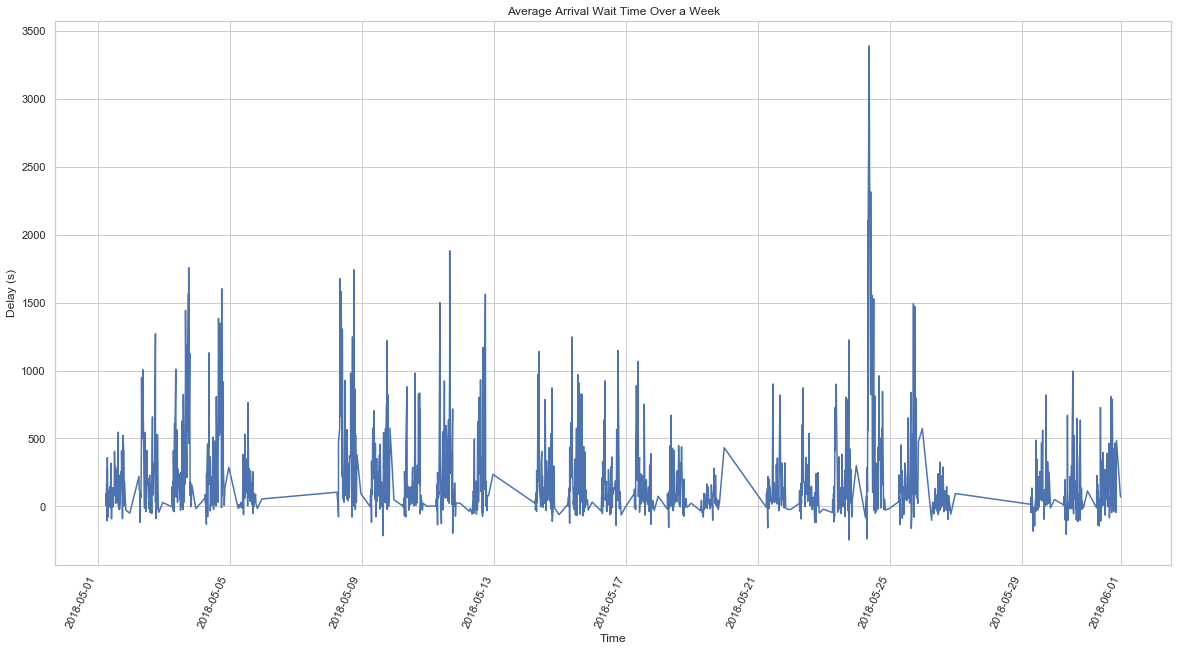

In [103]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [104]:
#LineRef.to_csv('LSTM_3.csv')

In [105]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [106]:
bus_3.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_3.sort_index(inplace=True)
bus_3.head()

LineRef LocationCode             LocationName  \
ScheduledArrivalTime                                                 
2018-05-01 06:02:00        3  39025790002  Cressingham Road Church   
2018-05-01 06:10:00        3  39025790001  Cressingham Road Church   
2018-05-01 06:12:00        3  39025790002  Cressingham Road Church   
2018-05-01 06:48:00        3  39025790001  Cressingham Road Church   
2018-05-01 06:49:00        3  39025790002  Cressingham Road Church   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-05-01 06:02:00     2018-05-01 06:02:00 2018-05-01 06:02:28   
2018-05-01 06:10:00     2018-05-01 06:10:00 2018-05-01 06:11:34   
2018-05-01 06:12:00     2018-05-01 06:12:00 2018-05-01 06:12:06   
2018-05-01 06:48:00     2018-05-01 06:48:00 2018-05-01 06:52:38   
2018-05-01 06:49:00     2018-05-01 06:49:00 2018-05-01 06:47:16   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-05-01 06:02:00  2018-05-01 06:02:29      Leopard           56   
2018-05-01 06:10:00  2018-05-01 06:11:36      Leopard           35   
2018-05-01 06:12:00  2018-05-01 06:12:12      Leopard           33   
2018-05-01 06:48:00  2018-05-01 06:53:32      Leopard           55   
2018-05-01 06:49:00  2018-05-01 06:47:16      Leopard           56   

                           StartPoint         EndPoint  Latitude  Longitude  \
ScheduledArrivalTime                                                          
2018-05-01 06:02:00      Station Road     Broad Street   51.4342    -0.9485   
2018-05-01 06:10:00   Sheerlands Road  St Mary's Butts   51.4342    -0.9486   
2018-05-01 06:12:00      Station Road  Sheerlands Road   51.4342    -0.9485   
2018-05-01 06:48:00      Broad Street  St Mary's Butts   51.4342    -0.9486   
2018-05-01 06:49:00      Station Road     Broad Street   51.4342    -0.9485   

                       ArrivalWaitTime DepartureWaitTime     delay  
ScheduledArrivalTime                                                
2018-05-01 06:02:00           00:00:28          00:00:29   28.0000  
2018-05-01 06:10:00           00:01:34          00:01:36   94.0000  
2018-05-01 06:12:00           00:00:06          00:00:12    6.0000  
2018-05-01 06:48:00           00:04:38          00:05:32  278.0000  
2018-05-01 06:49:00  -1 days +23:58:16 -1 days +23:58:16 -104.0000

In [107]:
y = bus_3.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-05-01 06:00:00   -104.0000
2018-05-01 07:00:00     77.0000
2018-05-01 08:00:00    148.0000
2018-05-01 09:00:00    318.0000
2018-05-01 10:00:00    135.0000
Freq: H, Name: delay, dtype: float64

In [108]:
#ax = y.plot();
#ax.set_ylabel('Delay');

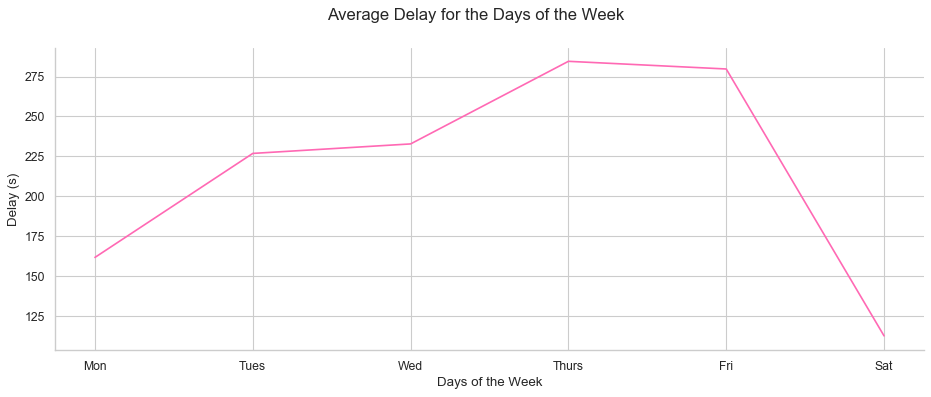

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus3_cressingham_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [112]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

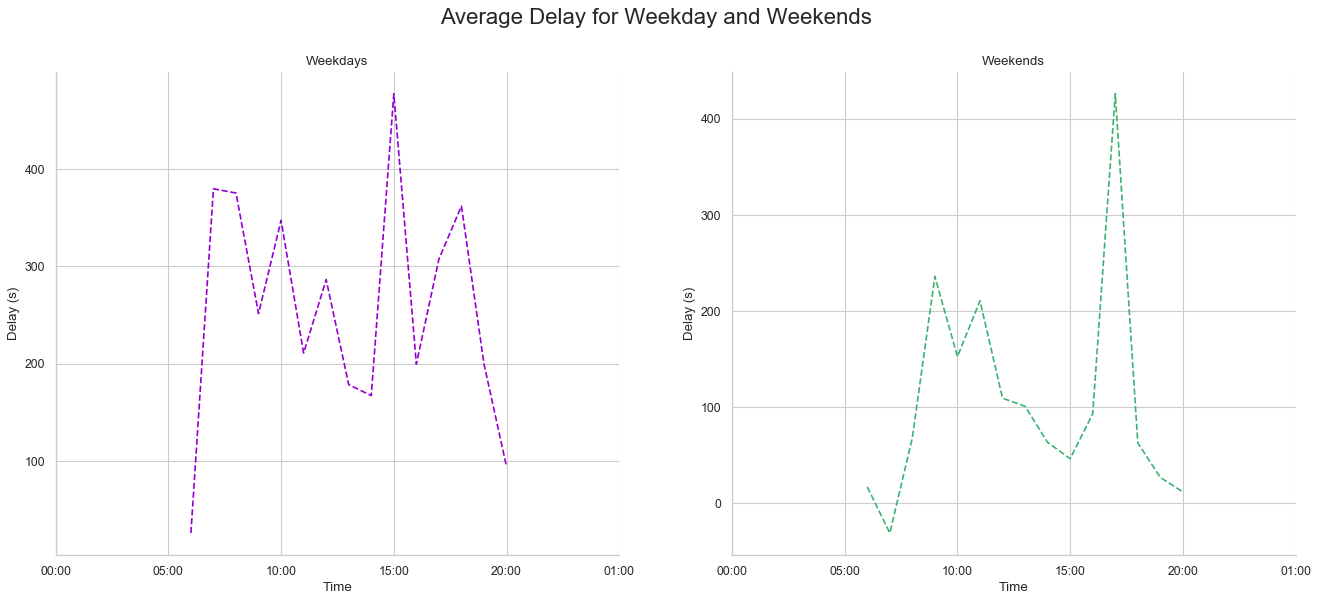

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus3_cressingham_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

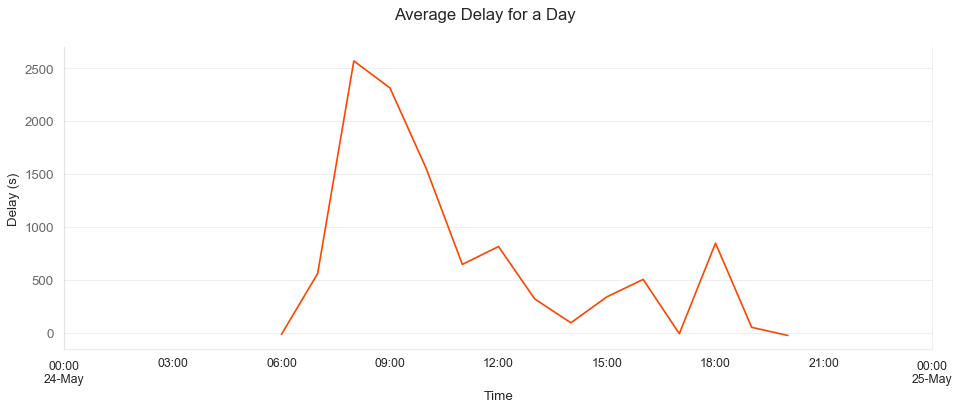

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-05-24 00:00:00':'2018-05-25 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus3_cressingham_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

In [ ]:
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
bus_21p = bus_21

In [ ]:
bus_21p.describe()

In [ ]:
bus_21p.head()

In [ ]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(bus_21p['delay'])

In [ ]:
bus_21p['ArrivalTime'] = pd.to_datetime(bus_21p['ArrivalTime']).astype(np.int64)

In [ ]:
x = bus_21p['ArrivalTime'].values.reshape(-1, 1)
y = bus_21p['delay'].values.reshape(-1, 1)

In [ ]:
scaler.fit(y) 
y = scaler.transform(y)
y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
x_train

In [ ]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train) #training the algorithm

In [ ]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

In [ ]:
y_pred = regressor.predict(x_test)

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test) 

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

In [ ]:
bus_21pc = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
bus_21pc.head(15)

In [ ]:
bus_21pc1 = bus_21pc.head(50)
bus_21pc1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
df_binary500 = df_binary[:][:500] 
  
# Selecting the 1st 500 rows of the data 
sns.lmplot(x ="Sal", y ="Temp", data = df_binary500, 
                               order = 2, ci = None) 

In [ ]:
plt.scatter(x_test, y_test,  color='gray')
plt.plot(x_test, y_pred, color='red', linewidth=2)
plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### LSTM

In [ ]:
df = pd.read_csv('LSTM.csv')

In [ ]:
df.ScheduledArrivalTime = pd.to_datetime(df.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [ ]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

In [ ]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [ ]:
df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [ ]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

In [ ]:
model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();

## Bus 5

### Dataset Months

In [274]:
bus_5 = bus_data.loc[bus_data['LineRef'] == '5']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [234]:
#For all dates and first month
date_after = pd.Timestamp(2018, 2, 1, 12)
date_after

Timestamp('2018-02-01 12:00:00')

In [235]:
bus_5 = bus_5.loc[bus_5['ScheduledArrivalTime'] < date_after]

In [275]:
#Specify dates
bus_5 = bus_5.loc[(bus_5['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_5['ScheduledArrivalTime'] <= '2018-06-01 12:00:00')]

In [276]:
bus_5.head()

LineRef LocationCode                            LocationName  \
2383143       5  39026010001                     Engineers Court opp   
2383144       5  39026010001                     Engineers Court opp   
2383145       5  39026820001  Northumberland Avenue Terminus N-bound   
2383146       5  39026820001  Northumberland Avenue Terminus N-bound   
2383147       5  39026140001                        Gratton Road opp   

        ScheduledArrivalTime ScheduledDepartureTime         ArrivalTime  \
2383143  2018-05-01 00:29:00    2018-05-01 00:29:00 2018-05-01 00:29:38   
2383144  2018-05-01 00:29:00    2018-05-01 00:29:00 2018-05-01 00:29:38   
2383145  2018-05-01 00:30:00    2018-05-01 00:30:00 2018-05-01 00:30:42   
2383146  2018-05-01 00:30:00    2018-05-01 00:30:00 2018-05-01 00:30:42   
2383147  2018-05-01 00:30:30    2018-05-01 00:30:30 2018-05-01 00:31:19   

              DepartureTime ServiceGroup  NumberStops           StartPoint  \
2383143 2018-05-01 00:30:06      Emerald           21  Engineers Court opp   
2383144 2018-05-01 00:30:06      Emerald           21  Engineers Court opp   
2383145 2018-05-01 00:30:54      Emerald           21  Engineers Court opp   
2383146 2018-05-01 00:30:54      Emerald           21  Engineers Court opp   
2383147 2018-05-01 00:31:57      Emerald           21  Engineers Court opp   

                     EndPoint   Latitude  Longitude ArrivalWaitTime  \
2383143  Station Road Stop SC  51.417205  -0.963320        00:00:38   
2383144  Station Road Stop SC  51.417205  -0.963320        00:00:38   
2383145  Station Road Stop SC  51.419632  -0.959108        00:00:42   
2383146  Station Road Stop SC  51.419632  -0.959108        00:00:42   
2383147  Station Road Stop SC  51.422495  -0.959562        00:00:49   

        DepartureWaitTime  
2383143          00:01:06  
2383144          00:01:06  
2383145          00:00:54  
2383146          00:00:54  
2383147          00:01:27

In [277]:
bus_5.tail()

LineRef LocationCode           LocationName ScheduledArrivalTime  \
2493452       5  39025810002   Crown Street N-bound  2018-05-31 23:53:00   
2493453       5  39025300001  Bridge Street stop MI  2018-05-31 23:54:00   
2493454       5  39027320006        St Mary's Butts  2018-05-31 23:55:00   
2493455       5  39027760001    West Street stop CU  2018-05-31 23:56:30   
2493456       5  39028140004   Station Road Stop SC  2018-05-31 23:58:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2493452    2018-05-31 23:53:00 2018-05-31 23:52:32 2018-05-31 23:52:41   
2493453    2018-05-31 23:54:00 2018-05-31 23:53:46 2018-05-31 23:53:56   
2493454    2018-05-31 23:55:00 2018-05-31 23:54:54 2018-05-31 23:55:26   
2493455    2018-05-31 23:56:30 2018-05-31 23:55:52 2018-05-31 23:56:04   
2493456    2018-05-31 23:58:00 2018-05-31 23:57:03 2018-05-31 23:59:20   

        ServiceGroup  NumberStops                      StartPoint  \
2493452      Emerald           20  Northumberland Avenue Terminus   
2493453      Emerald           20  Northumberland Avenue Terminus   
2493454      Emerald           20  Northumberland Avenue Terminus   
2493455      Emerald           20  Northumberland Avenue Terminus   
2493456      Emerald           20  Northumberland Avenue Terminus   

                     EndPoint   Latitude  Longitude   ArrivalWaitTime  \
2493452  Station Road Stop SC  51.450338  -0.970370 -1 days +23:59:32   
2493453  Station Road Stop SC  51.453113  -0.973085 -1 days +23:59:46   
2493454  Station Road Stop SC  51.454785  -0.974990 -1 days +23:59:54   
2493455  Station Road Stop SC  51.456152  -0.975995 -1 days +23:59:22   
2493456  Station Road Stop SC  51.457557  -0.972222 -1 days +23:59:03   

        DepartureWaitTime  
2493452 -1 days +23:59:41  
2493453 -1 days +23:59:56  
2493454          00:00:26  
2493455 -1 days +23:59:34  
2493456          00:01:20

In [278]:
len(bus_5)

110314

In [279]:
LineRef = pd.DataFrame()
LineRef = bus_5
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [280]:
LineRef.head()

LineRef LocationCode                            LocationName  \
2383143       5  39026010001                     Engineers Court opp   
2383144       5  39026010001                     Engineers Court opp   
2383145       5  39026820001  Northumberland Avenue Terminus N-bound   
2383146       5  39026820001  Northumberland Avenue Terminus N-bound   
2383147       5  39026140001                        Gratton Road opp   

        ScheduledArrivalTime ScheduledDepartureTime         ArrivalTime  \
2383143  2018-05-01 00:29:00    2018-05-01 00:29:00 2018-05-01 00:29:38   
2383144  2018-05-01 00:29:00    2018-05-01 00:29:00 2018-05-01 00:29:38   
2383145  2018-05-01 00:30:00    2018-05-01 00:30:00 2018-05-01 00:30:42   
2383146  2018-05-01 00:30:00    2018-05-01 00:30:00 2018-05-01 00:30:42   
2383147  2018-05-01 00:30:30    2018-05-01 00:30:30 2018-05-01 00:31:19   

              DepartureTime ServiceGroup  NumberStops           StartPoint  \
2383143 2018-05-01 00:30:06      Emerald           21  Engineers Court opp   
2383144 2018-05-01 00:30:06      Emerald           21  Engineers Court opp   
2383145 2018-05-01 00:30:54      Emerald           21  Engineers Court opp   
2383146 2018-05-01 00:30:54      Emerald           21  Engineers Court opp   
2383147 2018-05-01 00:31:57      Emerald           21  Engineers Court opp   

                     EndPoint   Latitude  Longitude ArrivalWaitTime  \
2383143  Station Road Stop SC  51.417205  -0.963320        00:00:38   
2383144  Station Road Stop SC  51.417205  -0.963320        00:00:38   
2383145  Station Road Stop SC  51.419632  -0.959108        00:00:42   
2383146  Station Road Stop SC  51.419632  -0.959108        00:00:42   
2383147  Station Road Stop SC  51.422495  -0.959562        00:00:49   

        DepartureWaitTime  delay  
2383143          00:01:06   38.0  
2383144          00:01:06   38.0  
2383145          00:00:54   42.0  
2383146          00:00:54   42.0  
2383147          00:01:27   49.0

In [281]:
LineRef = LineRef.groupby(['LocationName']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

43

In [282]:
LineRef.to_csv('bus_5_may18.csv')

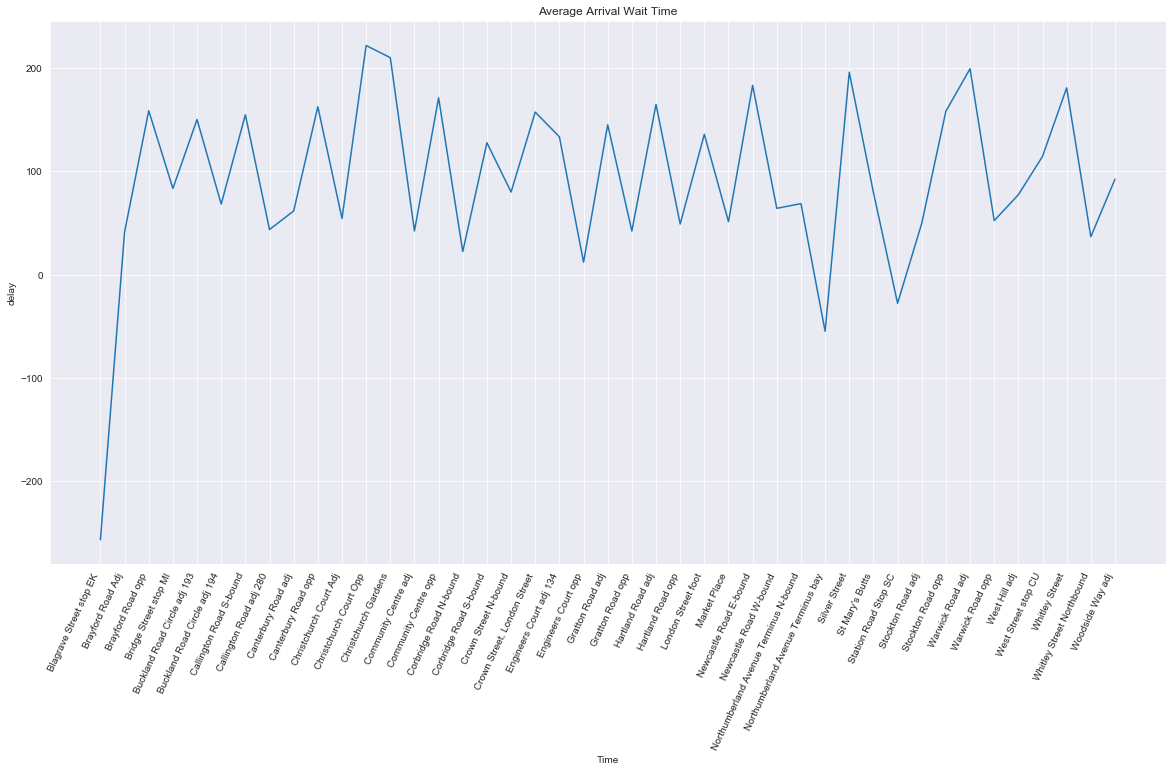

In [283]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show()

In [ ]:
LineRef.head()

In [ ]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus21_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [ ]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus21_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Whitley Street Bus Stop

In [133]:
bus_5 = bus_data.loc[(bus_data['LocationName'] == "Whitley Street") & (bus_data['LineRef'] == '5')]

In [134]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [135]:
bus_5 = bus_5.loc[bus_5['ScheduledArrivalTime'] < date_after]

In [136]:
#bus_5 = bus_5.loc[(bus_5['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_5['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [137]:
bus_5.head()

LineRef LocationCode    LocationName ScheduledArrivalTime  \
702803       5  39027800002  Whitley Street  2018-01-01 01:49:00   
702830       5  39027800001  Whitley Street  2018-01-01 02:37:00   
702840       5  39027800002  Whitley Street  2018-01-01 02:49:00   
702871       5  39027800001  Whitley Street  2018-01-01 04:37:00   
702883       5  39027800002  Whitley Street  2018-01-01 04:49:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
702803    2018-01-01 01:49:00 2018-01-01 01:58:02 2018-01-01 01:58:24   
702830    2018-01-01 02:37:00 2018-01-01 02:54:20 2018-01-01 02:54:20   
702840    2018-01-01 02:49:00 2018-01-01 03:05:06 2018-01-01 03:05:06   
702871    2018-01-01 04:37:00 2018-01-01 04:38:59 2018-01-01 04:39:21   
702883    2018-01-01 04:49:00 2018-01-01 04:49:58 2018-01-01 04:50:06   

       ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
702803      Emerald           24  St Mary's Butts  Engineers Court   51.4456   
702830      Emerald           19  Engineers Court  St Mary's Butts   51.4455   
702840      Emerald           24  St Mary's Butts  Engineers Court   51.4456   
702871      Emerald           19  Engineers Court  St Mary's Butts   51.4455   
702883      Emerald           24  St Mary's Butts  Engineers Court   51.4456   

        Longitude ArrivalWaitTime DepartureWaitTime  
702803    -0.9656        00:09:02          00:09:24  
702830    -0.9657        00:17:20          00:17:20  
702840    -0.9656        00:16:06          00:16:06  
702871    -0.9657        00:01:59          00:02:21  
702883    -0.9656        00:00:58          00:01:06

In [138]:
bus_5.tail()

LineRef LocationCode    LocationName ScheduledArrivalTime  \
2493285       5  39027800002  Whitley Street  2018-05-31 22:21:00   
2493305       5  39027800002  Whitley Street  2018-05-31 22:41:00   
2493344       5  39027800002  Whitley Street  2018-05-31 23:01:00   
2493383       5  39027800002  Whitley Street  2018-05-31 23:21:00   
2493420       5  39027800002  Whitley Street  2018-05-31 23:48:30   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2493285    2018-05-31 22:21:00 2018-05-31 22:24:54 2018-05-31 22:25:28   
2493305    2018-05-31 22:41:00 2018-05-31 22:42:28 2018-05-31 22:43:04   
2493344    2018-05-31 23:01:00 2018-05-31 23:03:32 2018-05-31 23:03:57   
2493383    2018-05-31 23:21:00 2018-05-31 23:24:00 2018-05-31 23:24:43   
2493420    2018-05-31 23:48:30 2018-05-31 23:52:31 2018-05-31 23:52:59   

        ServiceGroup  NumberStops       StartPoint  \
2493285      Emerald           22  St Mary's Butts   
2493305      Emerald           22  St Mary's Butts   
2493344      Emerald           22  St Mary's Butts   
2493383      Emerald           22  St Mary's Butts   
2493420      Emerald           24  St Mary's Butts   

                               EndPoint  Latitude  Longitude ArrivalWaitTime  \
2493285  Northumberland Avenue Terminus   51.4456    -0.9656        00:03:54   
2493305  Northumberland Avenue Terminus   51.4456    -0.9656        00:01:28   
2493344  Northumberland Avenue Terminus   51.4456    -0.9656        00:02:32   
2493383  Northumberland Avenue Terminus   51.4456    -0.9656        00:03:00   
2493420         Engineers Court adj 134   51.4456    -0.9656        00:04:01   

        DepartureWaitTime  
2493285          00:04:28  
2493305          00:02:04  
2493344          00:02:57  
2493383          00:03:43  
2493420          00:04:29

In [139]:
LineRef = pd.DataFrame()
LineRef = bus_5
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [140]:
LineRef.head()

LineRef LocationCode    LocationName ScheduledArrivalTime  \
702803       5  39027800002  Whitley Street  2018-01-01 01:49:00   
702830       5  39027800001  Whitley Street  2018-01-01 02:37:00   
702840       5  39027800002  Whitley Street  2018-01-01 02:49:00   
702871       5  39027800001  Whitley Street  2018-01-01 04:37:00   
702883       5  39027800002  Whitley Street  2018-01-01 04:49:00   

       ScheduledDepartureTime         ArrivalTime       DepartureTime  \
702803    2018-01-01 01:49:00 2018-01-01 01:58:02 2018-01-01 01:58:24   
702830    2018-01-01 02:37:00 2018-01-01 02:54:20 2018-01-01 02:54:20   
702840    2018-01-01 02:49:00 2018-01-01 03:05:06 2018-01-01 03:05:06   
702871    2018-01-01 04:37:00 2018-01-01 04:38:59 2018-01-01 04:39:21   
702883    2018-01-01 04:49:00 2018-01-01 04:49:58 2018-01-01 04:50:06   

       ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
702803      Emerald           24  St Mary's Butts  Engineers Court   51.4456   
702830      Emerald           19  Engineers Court  St Mary's Butts   51.4455   
702840      Emerald           24  St Mary's Butts  Engineers Court   51.4456   
702871      Emerald           19  Engineers Court  St Mary's Butts   51.4455   
702883      Emerald           24  St Mary's Butts  Engineers Court   51.4456   

        Longitude ArrivalWaitTime DepartureWaitTime     delay  
702803    -0.9656        00:09:02          00:09:24  542.0000  
702830    -0.9657        00:17:20          00:17:20 1040.0000  
702840    -0.9656        00:16:06          00:16:06  966.0000  
702871    -0.9657        00:01:59          00:02:21  119.0000  
702883    -0.9656        00:00:58          00:01:06   58.0000

In [141]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

24566

In [142]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

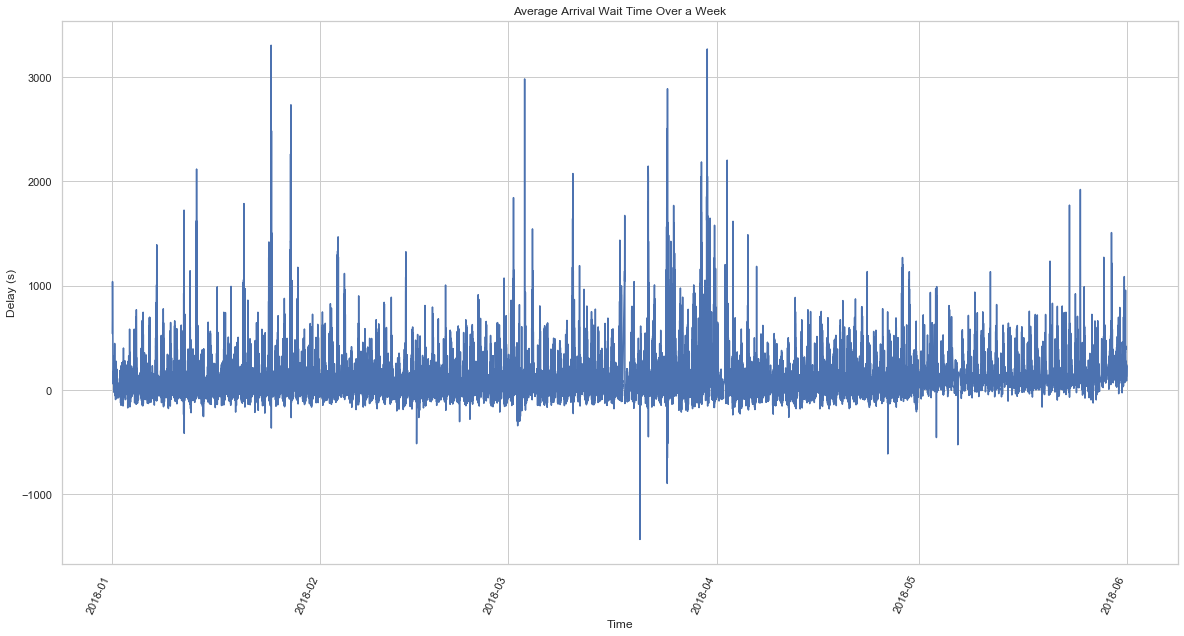

In [143]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [144]:
#LineRef.to_csv('LSTM_5.csv')

In [145]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [146]:
bus_5.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_5.sort_index(inplace=True)
bus_5.head()

LineRef LocationCode    LocationName  \
ScheduledArrivalTime                                        
2018-01-01 01:49:00        5  39027800002  Whitley Street   
2018-01-01 02:37:00        5  39027800001  Whitley Street   
2018-01-01 02:49:00        5  39027800002  Whitley Street   
2018-01-01 04:37:00        5  39027800001  Whitley Street   
2018-01-01 04:49:00        5  39027800002  Whitley Street   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-01 01:49:00     2018-01-01 01:49:00 2018-01-01 01:58:02   
2018-01-01 02:37:00     2018-01-01 02:37:00 2018-01-01 02:54:20   
2018-01-01 02:49:00     2018-01-01 02:49:00 2018-01-01 03:05:06   
2018-01-01 04:37:00     2018-01-01 04:37:00 2018-01-01 04:38:59   
2018-01-01 04:49:00     2018-01-01 04:49:00 2018-01-01 04:49:58   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-01 01:49:00  2018-01-01 01:58:24      Emerald           24   
2018-01-01 02:37:00  2018-01-01 02:54:20      Emerald           19   
2018-01-01 02:49:00  2018-01-01 03:05:06      Emerald           24   
2018-01-01 04:37:00  2018-01-01 04:39:21      Emerald           19   
2018-01-01 04:49:00  2018-01-01 04:50:06      Emerald           24   

                           StartPoint         EndPoint  Latitude  Longitude  \
ScheduledArrivalTime                                                          
2018-01-01 01:49:00   St Mary's Butts  Engineers Court   51.4456    -0.9656   
2018-01-01 02:37:00   Engineers Court  St Mary's Butts   51.4455    -0.9657   
2018-01-01 02:49:00   St Mary's Butts  Engineers Court   51.4456    -0.9656   
2018-01-01 04:37:00   Engineers Court  St Mary's Butts   51.4455    -0.9657   
2018-01-01 04:49:00   St Mary's Butts  Engineers Court   51.4456    -0.9656   

                     ArrivalWaitTime DepartureWaitTime     delay  
ScheduledArrivalTime                                              
2018-01-01 01:49:00         00:09:02          00:09:24  542.0000  
2018-01-01 02:37:00         00:17:20          00:17:20 1040.0000  
2018-01-01 02:49:00         00:16:06          00:16:06  966.0000  
2018-01-01 04:37:00         00:01:59          00:02:21  119.0000  
2018-01-01 04:49:00         00:00:58          00:01:06   58.0000

In [147]:
y = bus_5.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-01 01:00:00   542.0000
2018-01-01 02:00:00   966.0000
2018-01-01 03:00:00        nan
2018-01-01 04:00:00    58.0000
2018-01-01 05:00:00    64.0000
Freq: H, Name: delay, dtype: float64

In [148]:
#ax = y.plot();
#ax.set_ylabel('Delay');

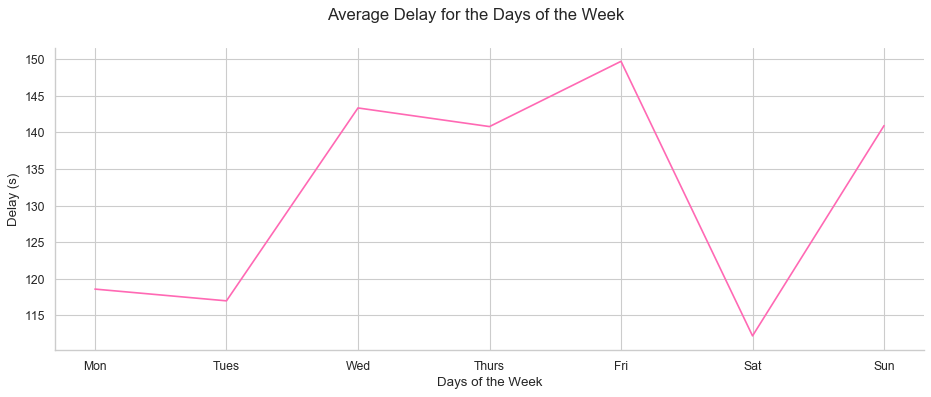

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus5_whitley_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [151]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

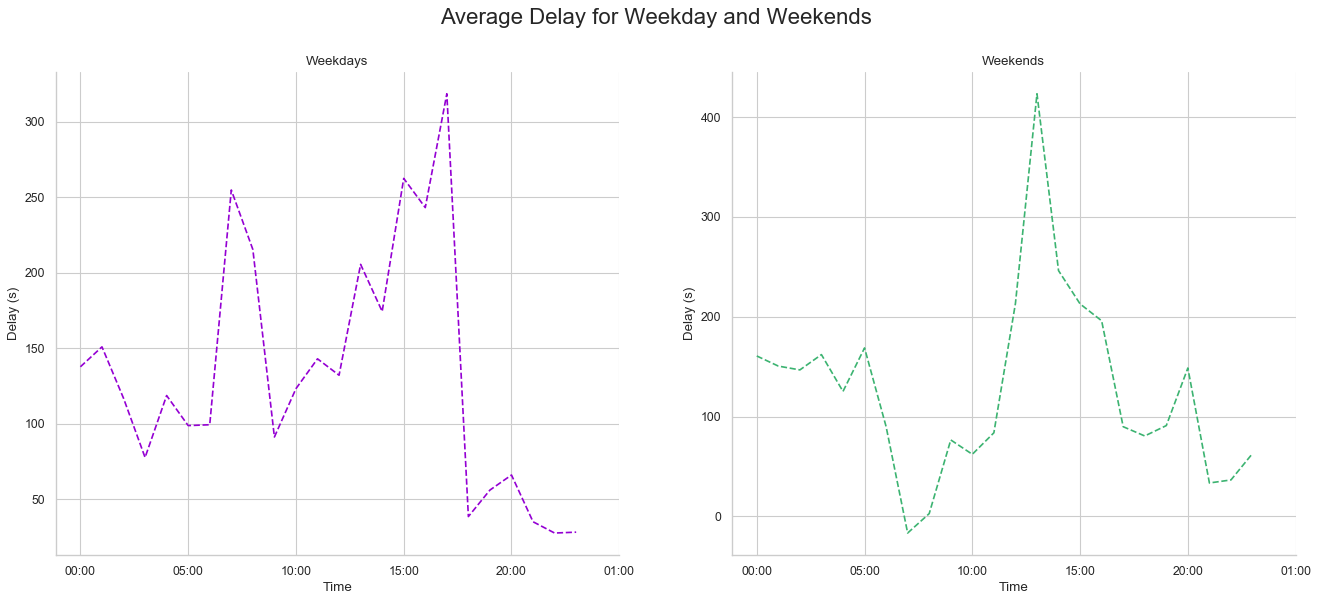

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus5_whitley_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

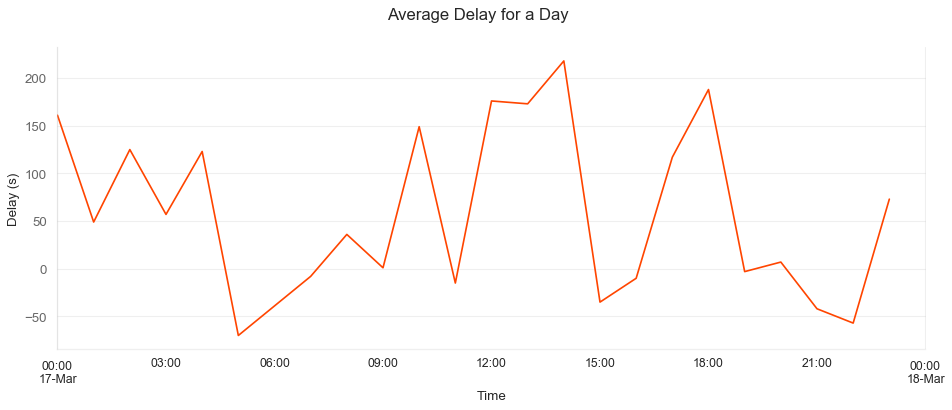

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-03-17 00:00:00':'2018-03-18 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus5_whitley_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

#### LSTM

In [ ]:
df = pd.read_csv('LSTM.csv')

In [ ]:
df.dtypes

In [ ]:
df.ScheduledArrivalTime = pd.to_datetime(df.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [ ]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

In [ ]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [ ]:
df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

In [ ]:
(8071, 1, 30)
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

In [ ]:
model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();

## Bus 6

### Dataset Months

In [244]:
bus_6 = bus_data.loc[bus_data['LineRef'] == '6']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [245]:
# For all dates and first month
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [246]:
bus_6 = bus_6.loc[bus_6['ScheduledArrivalTime'] < date_after]

In [247]:
# Between dates
#bus_6 = bus_6.loc[(bus_6['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_6['ScheduledArrivalTime'] <= '2018-06-01 12:00:00')]

In [248]:
bus_6.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1151767       6  39026010004  Engineers Court  2018-01-01 02:01:00   
1151768       6  39027260002     Spencer Road  2018-01-01 02:01:30   
1151769       6  39026970001      Holiday Inn  2018-01-01 02:02:00   
1151770       6  39025180001      Bennet Road  2018-01-01 02:03:20   
1151771       6  39025410002  Callington Road  2018-01-01 02:03:40   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1151767    2018-01-01 02:01:00 2018-01-01 02:12:01 2018-01-01 02:12:24   
1151768    2018-01-01 02:01:30 2018-01-01 02:12:55 2018-01-01 02:12:55   
1151769    2018-01-01 02:02:00 2018-01-01 02:13:35 2018-01-01 02:14:46   
1151770    2018-01-01 02:03:20 2018-01-01 02:16:01 2018-01-01 02:16:21   
1151771    2018-01-01 02:03:40 2018-01-01 02:16:34 2018-01-01 02:16:54   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1151767      Emerald           16  Engineers Court  St Mary's Butts   51.4171   
1151768      Emerald           16  Engineers Court  St Mary's Butts   51.4185   
1151769      Emerald           16  Engineers Court  St Mary's Butts   51.4215   
1151770      Emerald           16  Engineers Court  St Mary's Butts   51.4266   
1151771      Emerald           16  Engineers Court  St Mary's Butts   51.4286   

         Longitude ArrivalWaitTime DepartureWaitTime  
1151767    -0.9643        00:11:01          00:11:24  
1151768    -0.9671        00:11:25          00:11:25  
1151769    -0.9692        00:11:35          00:12:46  
1151770    -0.9704        00:12:41          00:13:01  
1151771    -0.9695        00:12:54          00:13:14

In [249]:
bus_6.tail()

LineRef LocationCode           LocationName ScheduledArrivalTime  \
2601117       6  39027750001          West Hill adj  2018-05-31 23:33:00   
2601118       6  39025810002   Crown Street N-bound  2018-05-31 23:34:00   
2601119       6  39025300001  Bridge Street stop MI  2018-05-31 23:35:00   
2601120       6  39027320006        St Mary's Butts  2018-05-31 23:36:00   
2601121       6  39027760001    West Street stop CU  2018-05-31 23:37:30   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2601117    2018-05-31 23:33:00 2018-05-31 23:34:05 2018-05-31 23:34:40   
2601118    2018-05-31 23:34:00 2018-05-31 23:35:02 2018-05-31 23:35:10   
2601119    2018-05-31 23:35:00 2018-05-31 23:35:45 2018-05-31 23:36:14   
2601120    2018-05-31 23:36:00 2018-05-31 23:36:43 2018-05-31 23:37:19   
2601121    2018-05-31 23:37:30 2018-05-31 23:37:44 2018-05-31 23:39:27   

        ServiceGroup  NumberStops                StartPoint  \
2601117      Emerald           22  Engineers Court SW-bound   
2601118      Emerald           22  Engineers Court SW-bound   
2601119      Emerald           22  Engineers Court SW-bound   
2601120      Emerald           22  Engineers Court SW-bound   
2601121      Emerald           22  Engineers Court SW-bound   

                     EndPoint  Latitude  Longitude ArrivalWaitTime  \
2601117  Station Road Stop SC   51.4487    -0.9688        00:01:05   
2601118  Station Road Stop SC   51.4503    -0.9704        00:01:02   
2601119  Station Road Stop SC   51.4531    -0.9731        00:00:45   
2601120  Station Road Stop SC   51.4548    -0.9750        00:00:43   
2601121  Station Road Stop SC   51.4562    -0.9760        00:00:14   

        DepartureWaitTime  
2601117          00:01:40  
2601118          00:01:10  
2601119          00:01:14  
2601120          00:01:19  
2601121          00:01:57

In [250]:
len(bus_6)

510515

In [251]:
LineRef = pd.DataFrame()
LineRef = bus_6
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [252]:
LineRef.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1151767       6  39026010004  Engineers Court  2018-01-01 02:01:00   
1151768       6  39027260002     Spencer Road  2018-01-01 02:01:30   
1151769       6  39026970001      Holiday Inn  2018-01-01 02:02:00   
1151770       6  39025180001      Bennet Road  2018-01-01 02:03:20   
1151771       6  39025410002  Callington Road  2018-01-01 02:03:40   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1151767    2018-01-01 02:01:00 2018-01-01 02:12:01 2018-01-01 02:12:24   
1151768    2018-01-01 02:01:30 2018-01-01 02:12:55 2018-01-01 02:12:55   
1151769    2018-01-01 02:02:00 2018-01-01 02:13:35 2018-01-01 02:14:46   
1151770    2018-01-01 02:03:20 2018-01-01 02:16:01 2018-01-01 02:16:21   
1151771    2018-01-01 02:03:40 2018-01-01 02:16:34 2018-01-01 02:16:54   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1151767      Emerald           16  Engineers Court  St Mary's Butts   51.4171   
1151768      Emerald           16  Engineers Court  St Mary's Butts   51.4185   
1151769      Emerald           16  Engineers Court  St Mary's Butts   51.4215   
1151770      Emerald           16  Engineers Court  St Mary's Butts   51.4266   
1151771      Emerald           16  Engineers Court  St Mary's Butts   51.4286   

         Longitude ArrivalWaitTime DepartureWaitTime    delay  
1151767    -0.9643        00:11:01          00:11:24 661.0000  
1151768    -0.9671        00:11:25          00:11:25 685.0000  
1151769    -0.9692        00:11:35          00:12:46 695.0000  
1151770    -0.9704        00:12:41          00:13:01 761.0000  
1151771    -0.9695        00:12:54          00:13:14 774.0000

In [253]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

213652

In [254]:
#LineRef.to_csv('bus_6_may18.csv')

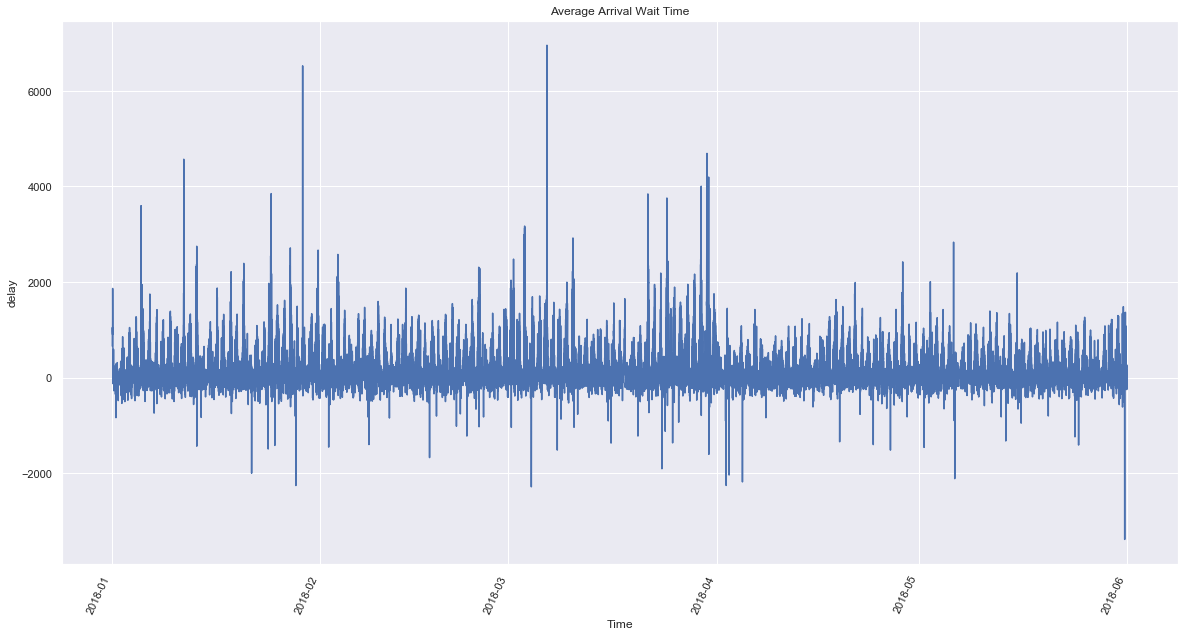

In [255]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show()

In [256]:
LineRef.head()

NumberStops  Latitude  Longitude    delay
ScheduledArrivalTime                                           
2018-01-01 02:01:00       16.0000   51.4171    -0.9643 661.0000
2018-01-01 02:01:30       16.0000   51.4185    -0.9671 685.0000
2018-01-01 02:02:00       16.0000   51.4215    -0.9692 695.0000
2018-01-01 02:03:20       16.0000   51.4266    -0.9704 761.0000
2018-01-01 02:03:40       16.0000   51.4286    -0.9695 774.0000

In [260]:
#del LineRef['NumberStops']
#del LineRef['Latitude']
#del LineRef['Longitude']

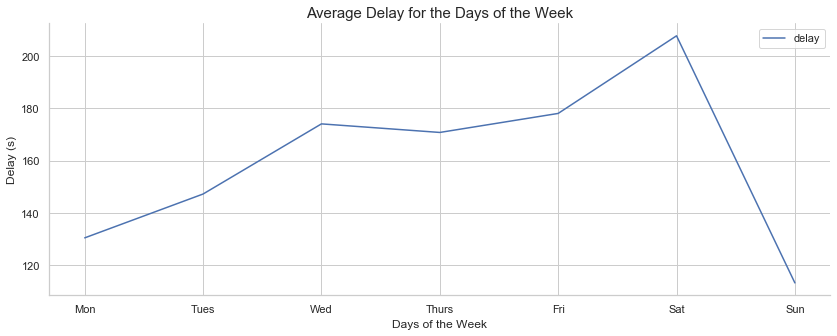

In [262]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus6_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [263]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

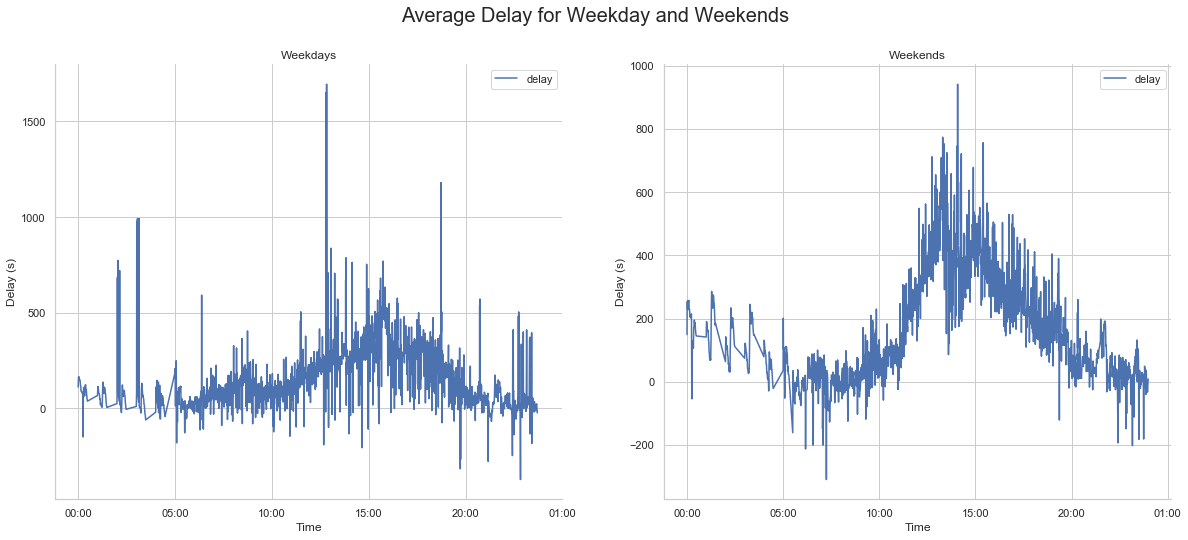

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus6_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Reading Station Bus Stop

In [194]:
bus_6 = bus_data.loc[(bus_data['LocationName'] == "Reading Station") & (bus_data['LineRef'] == '6')]

In [195]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [196]:
bus_6 = bus_6.loc[bus_6['ScheduledArrivalTime'] < date_after]

In [ ]:
#bus_6 = bus_6.loc[(bus_6['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_6['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [197]:
bus_6.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1153391       6  39028150004  Reading Station  2018-01-02 04:15:00   
1156926       6  39028150004  Reading Station  2018-01-02 22:05:00   
1156944       6  39028150004  Reading Station  2018-01-02 22:25:00   
1157002       6  39028150004  Reading Station  2018-01-02 23:00:00   
1157021       6  39028150004  Reading Station  2018-01-02 23:25:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1153391    2018-01-02 04:15:00 2018-01-02 04:15:25 2018-01-02 04:15:36   
1156926    2018-01-02 22:05:00 2018-01-02 22:06:26 2018-01-02 22:06:38   
1156944    2018-01-02 22:25:00 2018-01-02 22:25:28 2018-01-02 22:25:39   
1157002    2018-01-02 23:00:00 2018-01-02 23:00:14 2018-01-02 23:01:32   
1157021    2018-01-02 23:25:00 2018-01-02 23:17:17 2018-01-02 23:25:12   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1153391      Emerald           17  Reading Station  Engineers Court   51.4580   
1156926      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1156944      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1157002      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1157021      Emerald           19  St Mary's Butts  Engineers Court   51.4580   

         Longitude   ArrivalWaitTime DepartureWaitTime  
1153391    -0.9713          00:00:25          00:00:36  
1156926    -0.9713          00:01:26          00:01:38  
1156944    -0.9713          00:00:28          00:00:39  
1157002    -0.9713          00:00:14          00:01:32  
1157021    -0.9713 -1 days +23:52:17          00:00:12

In [198]:
bus_6.tail()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1550799       6  39028150004  Reading Station  2018-04-30 02:15:00   
1550834       6  39028150004  Reading Station  2018-04-30 03:15:00   
1550868       6  39028150004  Reading Station  2018-04-30 04:15:00   
1554561       6  39028150004  Reading Station  2018-04-30 23:00:00   
1554579       6  39028150004  Reading Station  2018-04-30 23:25:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1550799    2018-04-30 02:15:00 2018-04-30 02:15:52 2018-04-30 02:16:39   
1550834    2018-04-30 03:15:00 2018-04-30 03:14:16 2018-04-30 03:15:10   
1550868    2018-04-30 04:15:00 2018-04-30 04:14:14 2018-04-30 04:15:35   
1554561    2018-04-30 23:00:00 2018-04-30 22:57:00 2018-04-30 23:00:19   
1554579    2018-04-30 23:25:00 2018-04-30 23:18:55 2018-04-30 23:26:10   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1550799      Emerald           17  Reading Station  Engineers Court   51.4580   
1550834      Emerald           17  Reading Station  Engineers Court   51.4580   
1550868      Emerald           17  Reading Station  Engineers Court   51.4580   
1554561      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1554579      Emerald           19  St Mary's Butts  Engineers Court   51.4580   

         Longitude   ArrivalWaitTime DepartureWaitTime  
1550799    -0.9713          00:00:52          00:01:39  
1550834    -0.9713 -1 days +23:59:16          00:00:10  
1550868    -0.9713 -1 days +23:59:14          00:00:35  
1554561    -0.9713 -1 days +23:57:00          00:00:19  
1554579    -0.9713 -1 days +23:53:55          00:01:10

In [199]:
LineRef = pd.DataFrame()
LineRef = bus_6
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [200]:
LineRef.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1153391       6  39028150004  Reading Station  2018-01-02 04:15:00   
1156926       6  39028150004  Reading Station  2018-01-02 22:05:00   
1156944       6  39028150004  Reading Station  2018-01-02 22:25:00   
1157002       6  39028150004  Reading Station  2018-01-02 23:00:00   
1157021       6  39028150004  Reading Station  2018-01-02 23:25:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1153391    2018-01-02 04:15:00 2018-01-02 04:15:25 2018-01-02 04:15:36   
1156926    2018-01-02 22:05:00 2018-01-02 22:06:26 2018-01-02 22:06:38   
1156944    2018-01-02 22:25:00 2018-01-02 22:25:28 2018-01-02 22:25:39   
1157002    2018-01-02 23:00:00 2018-01-02 23:00:14 2018-01-02 23:01:32   
1157021    2018-01-02 23:25:00 2018-01-02 23:17:17 2018-01-02 23:25:12   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1153391      Emerald           17  Reading Station  Engineers Court   51.4580   
1156926      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1156944      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1157002      Emerald           19  St Mary's Butts  Engineers Court   51.4580   
1157021      Emerald           19  St Mary's Butts  Engineers Court   51.4580   

         Longitude   ArrivalWaitTime DepartureWaitTime     delay  
1153391    -0.9713          00:00:25          00:00:36   25.0000  
1156926    -0.9713          00:01:26          00:01:38   86.0000  
1156944    -0.9713          00:00:28          00:00:39   28.0000  
1157002    -0.9713          00:00:14          00:01:32   14.0000  
1157021    -0.9713 -1 days +23:52:17          00:00:12 -463.0000

In [201]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

822

In [202]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

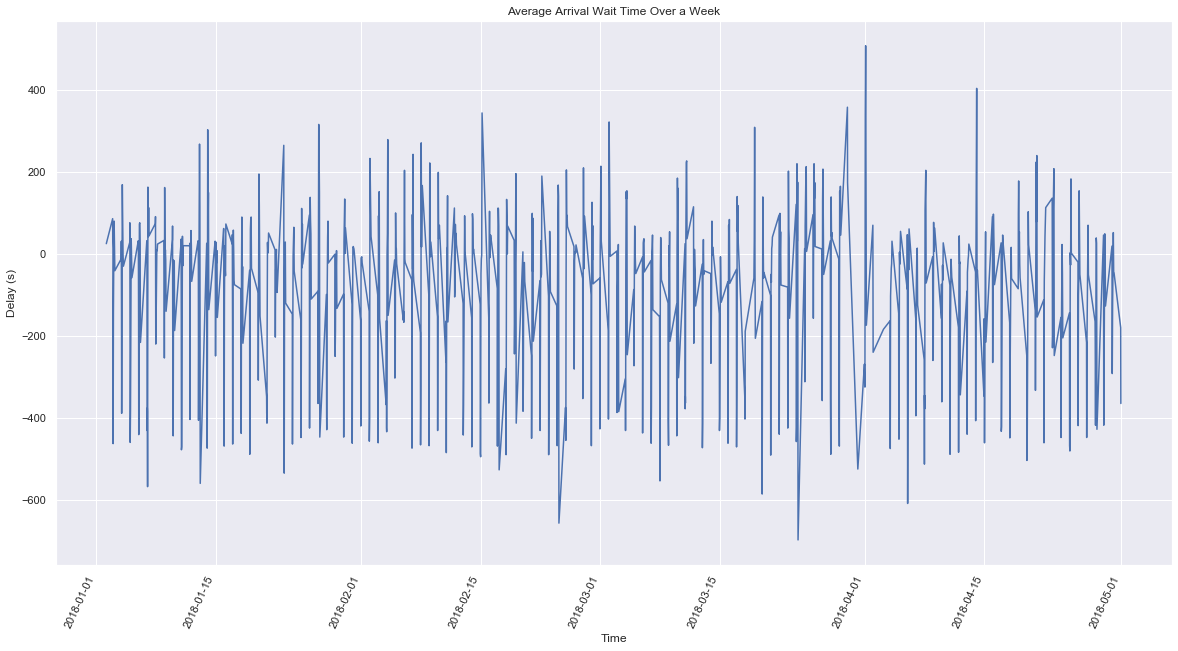

In [205]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean()
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [ ]:
#LineRef.to_csv('LSTM_6.csv')

In [206]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [207]:
bus_6.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_6.sort_index(inplace=True)
bus_6.head()

LineRef LocationCode     LocationName  \
ScheduledArrivalTime                                         
2018-01-02 04:15:00        6  39028150004  Reading Station   
2018-01-02 22:05:00        6  39028150004  Reading Station   
2018-01-02 22:25:00        6  39028150004  Reading Station   
2018-01-02 23:00:00        6  39028150004  Reading Station   
2018-01-02 23:25:00        6  39028150004  Reading Station   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-02 04:15:00     2018-01-02 04:15:00 2018-01-02 04:15:25   
2018-01-02 22:05:00     2018-01-02 22:05:00 2018-01-02 22:06:26   
2018-01-02 22:25:00     2018-01-02 22:25:00 2018-01-02 22:25:28   
2018-01-02 23:00:00     2018-01-02 23:00:00 2018-01-02 23:00:14   
2018-01-02 23:25:00     2018-01-02 23:25:00 2018-01-02 23:17:17   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-02 04:15:00  2018-01-02 04:15:36      Emerald           17   
2018-01-02 22:05:00  2018-01-02 22:06:38      Emerald           19   
2018-01-02 22:25:00  2018-01-02 22:25:39      Emerald           19   
2018-01-02 23:00:00  2018-01-02 23:01:32      Emerald           19   
2018-01-02 23:25:00  2018-01-02 23:25:12      Emerald           19   

                           StartPoint         EndPoint  Latitude  Longitude  \
ScheduledArrivalTime                                                          
2018-01-02 04:15:00   Reading Station  Engineers Court   51.4580    -0.9713   
2018-01-02 22:05:00   St Mary's Butts  Engineers Court   51.4580    -0.9713   
2018-01-02 22:25:00   St Mary's Butts  Engineers Court   51.4580    -0.9713   
2018-01-02 23:00:00   St Mary's Butts  Engineers Court   51.4580    -0.9713   
2018-01-02 23:25:00   St Mary's Butts  Engineers Court   51.4580    -0.9713   

                       ArrivalWaitTime DepartureWaitTime     delay  
ScheduledArrivalTime                                                
2018-01-02 04:15:00           00:00:25          00:00:36   25.0000  
2018-01-02 22:05:00           00:01:26          00:01:38   86.0000  
2018-01-02 22:25:00           00:00:28          00:00:39   28.0000  
2018-01-02 23:00:00           00:00:14          00:01:32   14.0000  
2018-01-02 23:25:00  -1 days +23:52:17          00:00:12 -463.0000

In [208]:
y = bus_6.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-02 04:00:00   25.0000
2018-01-02 05:00:00       nan
2018-01-02 06:00:00       nan
2018-01-02 07:00:00       nan
2018-01-02 08:00:00       nan
Freq: H, Name: delay, dtype: float64

In [ ]:
#ax = y.plot();
#ax.set_ylabel('Delay');

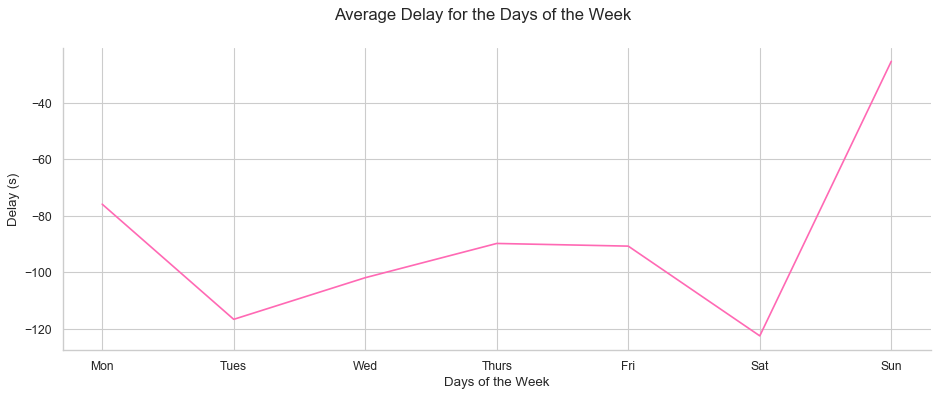

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus6_rstation_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [212]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

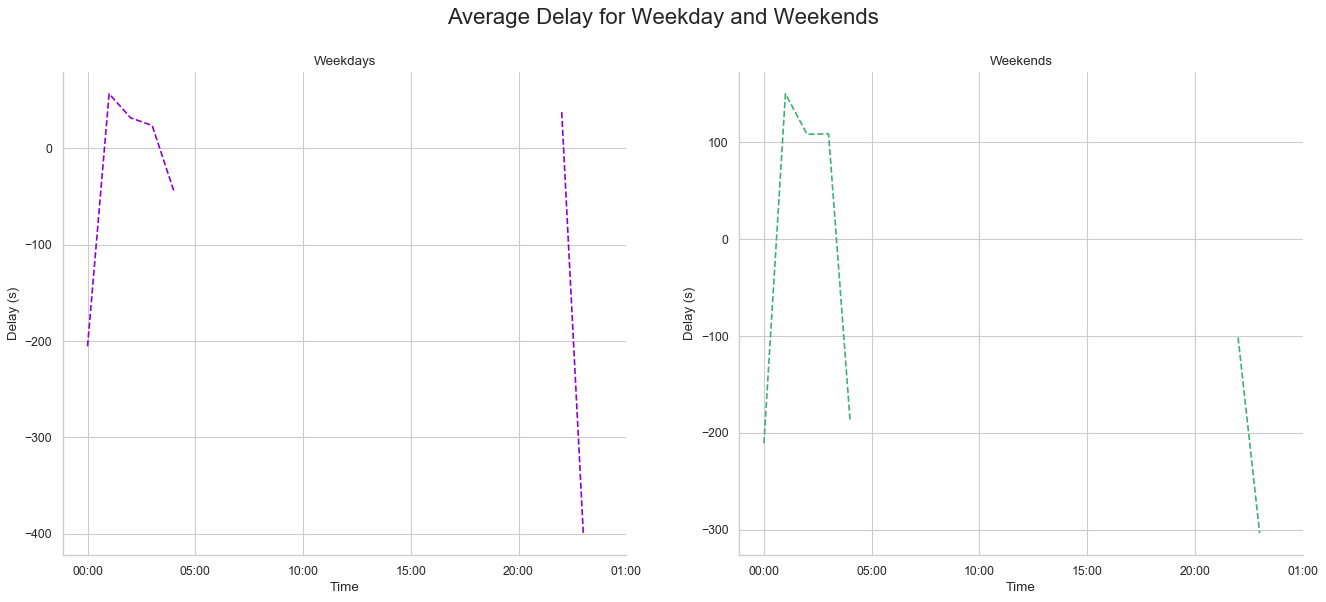

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus6_rstation_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

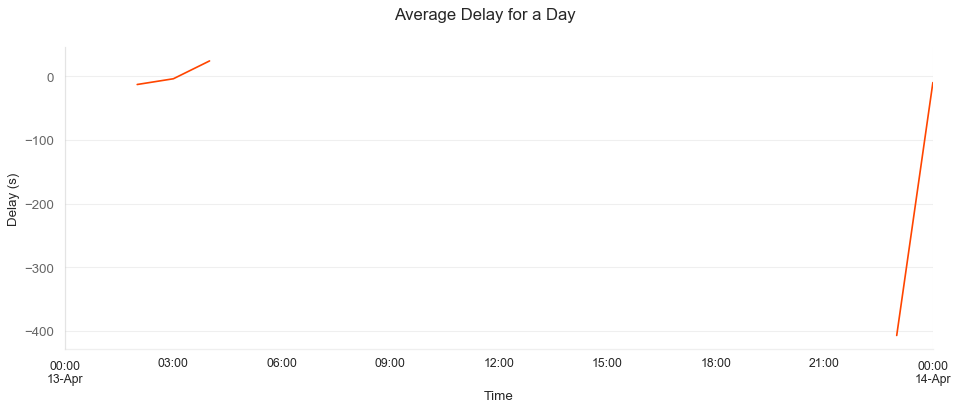

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-04-13 00:00:00':'2018-04-14 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus6_rstation_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

#### LSTM

In [ ]:
df = pd.read_csv('LSTM.csv')

In [ ]:
df.dtypes

In [ ]:
df.ScheduledArrivalTime = pd.to_datetime(df.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [ ]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

In [ ]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [ ]:
df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

In [ ]:
model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();

## Bus 10

### Dataset Months

In [307]:
bus_10 = bus_data.loc[bus_data['LineRef'] == '10']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [308]:
# For all dates and first month
date_after = pd.Timestamp(2018, 6, 1, 12)
date_after

Timestamp('2018-06-01 12:00:00')

In [309]:
bus_10 = bus_10.loc[bus_10['ScheduledArrivalTime'] < date_after]

In [310]:
# Between dates
#bus_10 = bus_10.loc[(bus_10['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_10['ScheduledArrivalTime'] <= '2018-06-01 12:00:00')]

In [311]:
bus_10.head()

LineRef LocationCode         LocationName ScheduledArrivalTime  \
1554617      10  39028140001         Station Road  2018-01-01 08:10:00   
1554618      10  39026630001         Market Place  2018-01-01 08:12:00   
1554619      10  39025920003           Kings Road  2018-01-01 08:13:00   
1554620      10  39026410003  Huntley and Palmers  2018-01-01 08:14:00   
1554621      10  39025980003           Eldon Road  2018-01-01 08:16:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1554617    2018-01-01 08:10:00 2018-01-01 08:07:18 2018-01-01 08:09:22   
1554618    2018-01-01 08:12:00 2018-01-01 08:11:27 2018-01-01 08:11:28   
1554619    2018-01-01 08:13:00 2018-01-01 08:12:03 2018-01-01 08:12:04   
1554620    2018-01-01 08:14:00 2018-01-01 08:12:40 2018-01-01 08:12:41   
1554621    2018-01-01 08:16:00 2018-01-01 08:14:42 2018-01-01 08:14:43   

        ServiceGroup  NumberStops    StartPoint      EndPoint  Latitude  \
1554617      Leopard           25  Station Road  Albert Close   51.4581   
1554618      Leopard           25  Station Road  Albert Close   51.4560   
1554619      Leopard           25  Station Road  Albert Close   51.4550   
1554620      Leopard           25  Station Road  Albert Close   51.4550   
1554621      Leopard           25  Station Road  Albert Close   51.4526   

         Longitude   ArrivalWaitTime DepartureWaitTime  
1554617    -0.9723 -1 days +23:57:18 -1 days +23:59:22  
1554618    -0.9694 -1 days +23:59:27 -1 days +23:59:28  
1554619    -0.9683 -1 days +23:59:03 -1 days +23:59:04  
1554620    -0.9635 -1 days +23:58:40 -1 days +23:58:41  
1554621    -0.9586 -1 days +23:58:42 -1 days +23:58:43

In [312]:
bus_10.tail()

LineRef LocationCode             LocationName ScheduledArrivalTime  \
2620230      10  35077040001           Weather Centre  2018-05-31 23:55:00   
2620231      10  35077060001            Ducketts Farm  2018-05-31 23:56:00   
2620232      10  35077080001            The Black Boy  2018-05-31 23:57:00   
2620233      10  35077100001  Church Lane (Shinfield)  2018-05-31 23:58:00   
2620234      10  35077120001             School Green  2018-05-31 23:59:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2620230    2018-05-31 23:55:00 2018-05-31 23:54:58 2018-05-31 23:54:59   
2620231    2018-05-31 23:56:00 2018-05-31 23:55:28 2018-05-31 23:55:34   
2620232    2018-05-31 23:57:00 2018-05-31 23:56:44 2018-05-31 23:56:45   
2620233    2018-05-31 23:58:00 2018-05-31 23:57:39 2018-05-31 23:57:49   
2620234    2018-05-31 23:59:00 2018-05-31 23:57:19 2018-05-31 23:57:19   

        ServiceGroup  NumberStops       StartPoint              EndPoint  \
2620230      Leopard           27  St Mary's Butts  Albert Close N-bound   
2620231      Leopard           27  St Mary's Butts  Albert Close N-bound   
2620232      Leopard           27  St Mary's Butts  Albert Close N-bound   
2620233      Leopard           27  St Mary's Butts  Albert Close N-bound   
2620234      Leopard           27  St Mary's Butts  Albert Close N-bound   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime  
2620230   51.4206    -0.9474 -1 days +23:59:58 -1 days +23:59:59  
2620231   51.4174    -0.9486 -1 days +23:59:28 -1 days +23:59:34  
2620232   51.4121    -0.9499 -1 days +23:59:44 -1 days +23:59:45  
2620233   51.4086    -0.9478 -1 days +23:59:39 -1 days +23:59:49  
2620234   51.4061    -0.9461 -1 days +23:58:19 -1 days +23:58:19

In [313]:
len(bus_10)

119579

In [314]:
LineRef = pd.DataFrame()
LineRef = bus_10
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [315]:
LineRef.head()

LineRef LocationCode         LocationName ScheduledArrivalTime  \
1554617      10  39028140001         Station Road  2018-01-01 08:10:00   
1554618      10  39026630001         Market Place  2018-01-01 08:12:00   
1554619      10  39025920003           Kings Road  2018-01-01 08:13:00   
1554620      10  39026410003  Huntley and Palmers  2018-01-01 08:14:00   
1554621      10  39025980003           Eldon Road  2018-01-01 08:16:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1554617    2018-01-01 08:10:00 2018-01-01 08:07:18 2018-01-01 08:09:22   
1554618    2018-01-01 08:12:00 2018-01-01 08:11:27 2018-01-01 08:11:28   
1554619    2018-01-01 08:13:00 2018-01-01 08:12:03 2018-01-01 08:12:04   
1554620    2018-01-01 08:14:00 2018-01-01 08:12:40 2018-01-01 08:12:41   
1554621    2018-01-01 08:16:00 2018-01-01 08:14:42 2018-01-01 08:14:43   

        ServiceGroup  NumberStops    StartPoint      EndPoint  Latitude  \
1554617      Leopard           25  Station Road  Albert Close   51.4581   
1554618      Leopard           25  Station Road  Albert Close   51.4560   
1554619      Leopard           25  Station Road  Albert Close   51.4550   
1554620      Leopard           25  Station Road  Albert Close   51.4550   
1554621      Leopard           25  Station Road  Albert Close   51.4526   

         Longitude   ArrivalWaitTime DepartureWaitTime     delay  
1554617    -0.9723 -1 days +23:57:18 -1 days +23:59:22 -162.0000  
1554618    -0.9694 -1 days +23:59:27 -1 days +23:59:28  -33.0000  
1554619    -0.9683 -1 days +23:59:03 -1 days +23:59:04  -57.0000  
1554620    -0.9635 -1 days +23:58:40 -1 days +23:58:41  -80.0000  
1554621    -0.9586 -1 days +23:58:42 -1 days +23:58:43  -78.0000

In [316]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

100402

In [406]:
#LineRef.to_csv('bus_10_may18.csv')

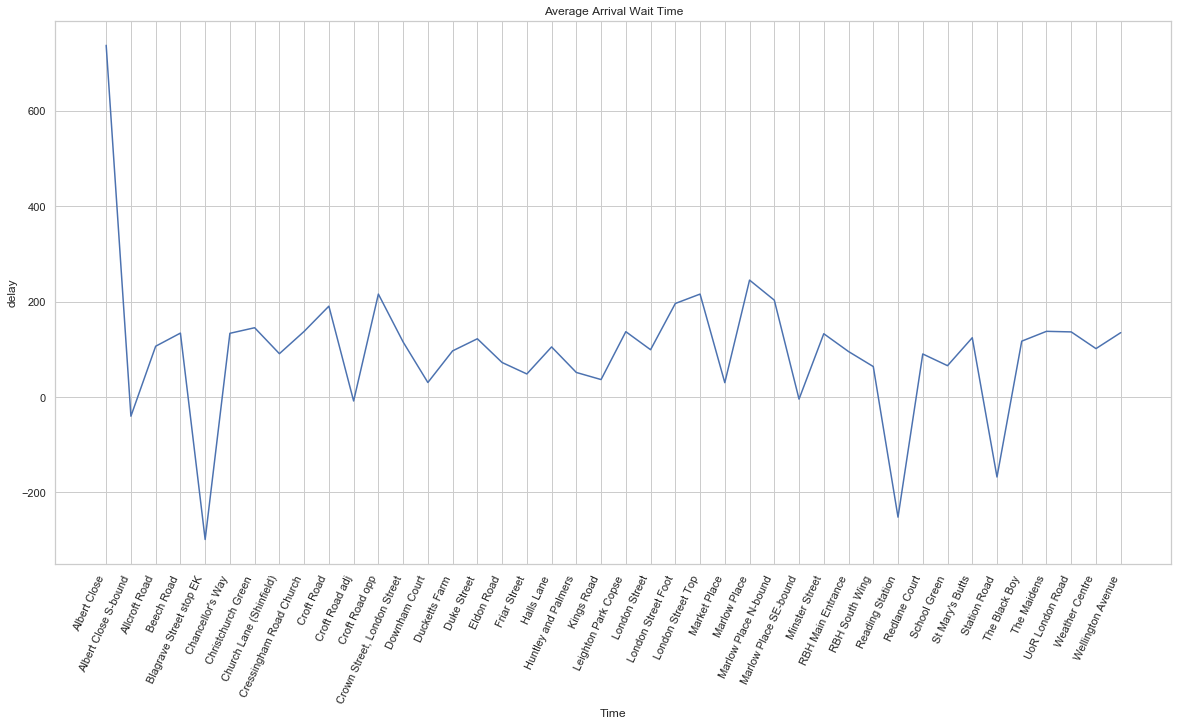

In [276]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show()

In [317]:
LineRef.head()

NumberStops  Latitude  Longitude     delay
ScheduledArrivalTime                                            
2018-01-01 08:10:00       25.0000   51.4581    -0.9723 -162.0000
2018-01-01 08:12:00       25.0000   51.4560    -0.9694  -33.0000
2018-01-01 08:13:00       25.0000   51.4550    -0.9683  -57.0000
2018-01-01 08:14:00       25.0000   51.4550    -0.9635  -80.0000
2018-01-01 08:16:00       25.0000   51.4526    -0.9586  -78.0000

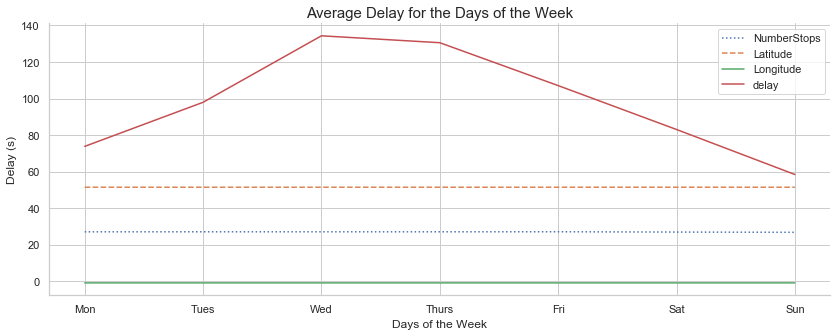

In [319]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus10_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [320]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

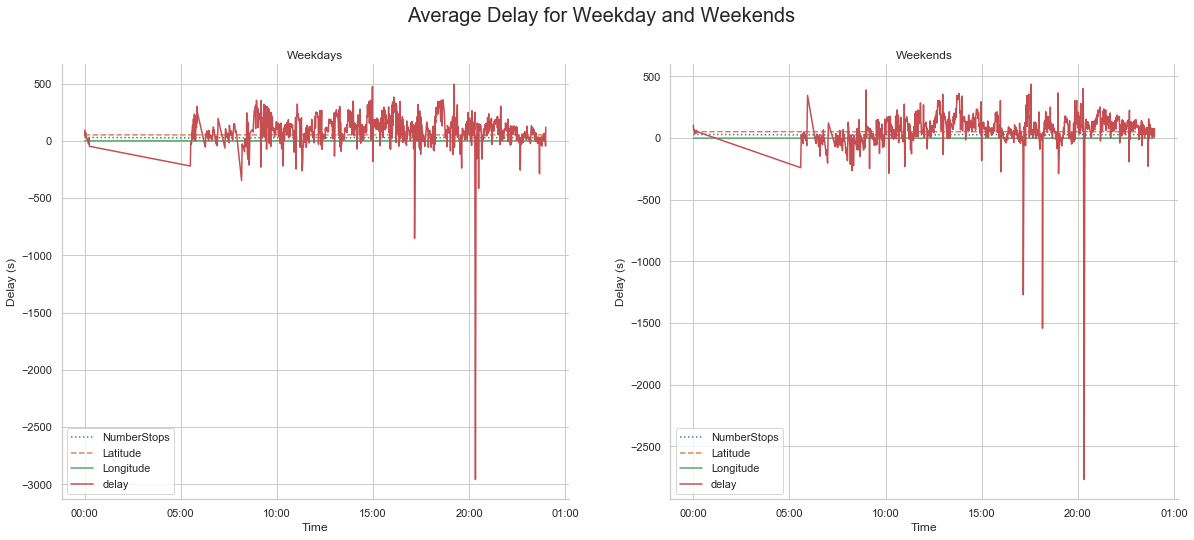

In [321]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus10_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### St Mary's Butts Bus Stop

In [281]:
bus_10 = bus_data.loc[(bus_data['LocationName'] == "St Mary's Butts") & (bus_data['LineRef'] == '10')]

In [282]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [283]:
bus_10 = bus_10.loc[bus_10['ScheduledArrivalTime'] < date_after]

In [ ]:
#bus_21 = bus_21.loc[(bus_21['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_21['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [284]:
bus_10.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1554666      10  39027320006  St Mary's Butts  2018-01-01 09:17:00   
1554715      10  39027320006  St Mary's Butts  2018-01-01 10:17:00   
1554740      10  39027320006  St Mary's Butts  2018-01-01 10:47:00   
1554791      10  39027320006  St Mary's Butts  2018-01-01 11:19:00   
1554817      10  39027320006  St Mary's Butts  2018-01-01 12:19:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1554666    2018-01-01 09:17:00 2018-01-01 09:16:55 2018-01-01 09:17:00   
1554715    2018-01-01 10:17:00 2018-01-01 10:16:45 2018-01-01 10:17:00   
1554740    2018-01-01 10:47:00 2018-01-01 10:45:19 2018-01-01 10:47:12   
1554791    2018-01-01 11:19:00 2018-01-01 11:17:52 2018-01-01 11:19:00   
1554817    2018-01-01 12:19:00 2018-01-01 12:19:11 2018-01-01 12:19:51   

        ServiceGroup  NumberStops            StartPoint         EndPoint  \
1554666      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554715      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554740      Leopard           27       St Mary's Butts     Albert Close   
1554791      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554817      Leopard           29  Albert Close S-bound     Station Road   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime  
1554666   51.4548    -0.9750 -1 days +23:59:55          00:00:00  
1554715   51.4548    -0.9750 -1 days +23:59:45          00:00:00  
1554740   51.4548    -0.9750 -1 days +23:58:19          00:00:12  
1554791   51.4548    -0.9750 -1 days +23:58:52          00:00:00  
1554817   51.4548    -0.9750          00:00:11          00:00:51

In [285]:
bus_10.tail()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
2620099      10  39027320006  St Mary's Butts  2018-05-31 21:04:00   
2620123      10  39027320006  St Mary's Butts  2018-05-31 21:31:00   
2620168      10  39027320006  St Mary's Butts  2018-05-31 22:31:00   
2620212      10  39027320006  St Mary's Butts  2018-05-31 23:31:00   
2620213      10  39027320006  St Mary's Butts  2018-05-31 23:31:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2620099    2018-05-31 21:04:00 2018-05-31 21:04:49 2018-05-31 21:04:59   
2620123    2018-05-31 21:31:00 2018-05-31 21:34:45 2018-05-31 21:36:21   
2620168    2018-05-31 22:31:00 2018-05-31 22:30:48 2018-05-31 22:32:08   
2620212    2018-05-31 23:31:00 2018-05-31 23:29:40 2018-05-31 23:31:00   
2620213    2018-05-31 23:31:00 2018-05-31 23:29:41 2018-05-31 23:31:22   

        ServiceGroup  NumberStops            StartPoint              EndPoint  \
2620099      Leopard           27  Albert Close S-bound       St Mary's Butts   
2620123      Leopard           27       St Mary's Butts  Albert Close N-bound   
2620168      Leopard           27       St Mary's Butts  Albert Close N-bound   
2620212      Leopard           27  Albert Close S-bound       St Mary's Butts   
2620213      Leopard           27       St Mary's Butts  Albert Close N-bound   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime  
2620099   51.4548    -0.9750          00:00:49          00:00:59  
2620123   51.4548    -0.9750          00:03:45          00:05:21  
2620168   51.4548    -0.9750 -1 days +23:59:48          00:01:08  
2620212   51.4548    -0.9750 -1 days +23:58:40          00:00:00  
2620213   51.4548    -0.9750 -1 days +23:58:41          00:00:22

In [287]:
LineRef = pd.DataFrame()
LineRef = bus_10
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [288]:
LineRef.head()

LineRef LocationCode     LocationName ScheduledArrivalTime  \
1554666      10  39027320006  St Mary's Butts  2018-01-01 09:17:00   
1554715      10  39027320006  St Mary's Butts  2018-01-01 10:17:00   
1554740      10  39027320006  St Mary's Butts  2018-01-01 10:47:00   
1554791      10  39027320006  St Mary's Butts  2018-01-01 11:19:00   
1554817      10  39027320006  St Mary's Butts  2018-01-01 12:19:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1554666    2018-01-01 09:17:00 2018-01-01 09:16:55 2018-01-01 09:17:00   
1554715    2018-01-01 10:17:00 2018-01-01 10:16:45 2018-01-01 10:17:00   
1554740    2018-01-01 10:47:00 2018-01-01 10:45:19 2018-01-01 10:47:12   
1554791    2018-01-01 11:19:00 2018-01-01 11:17:52 2018-01-01 11:19:00   
1554817    2018-01-01 12:19:00 2018-01-01 12:19:11 2018-01-01 12:19:51   

        ServiceGroup  NumberStops            StartPoint         EndPoint  \
1554666      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554715      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554740      Leopard           27       St Mary's Butts     Albert Close   
1554791      Leopard           27  Albert Close S-bound  St Mary's Butts   
1554817      Leopard           29  Albert Close S-bound     Station Road   

         Latitude  Longitude   ArrivalWaitTime DepartureWaitTime     delay  
1554666   51.4548    -0.9750 -1 days +23:59:55          00:00:00   -5.0000  
1554715   51.4548    -0.9750 -1 days +23:59:45          00:00:00  -15.0000  
1554740   51.4548    -0.9750 -1 days +23:58:19          00:00:12 -101.0000  
1554791   51.4548    -0.9750 -1 days +23:58:52          00:00:00  -68.0000  
1554817   51.4548    -0.9750          00:00:11          00:00:51   11.0000

In [289]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

3973

In [290]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

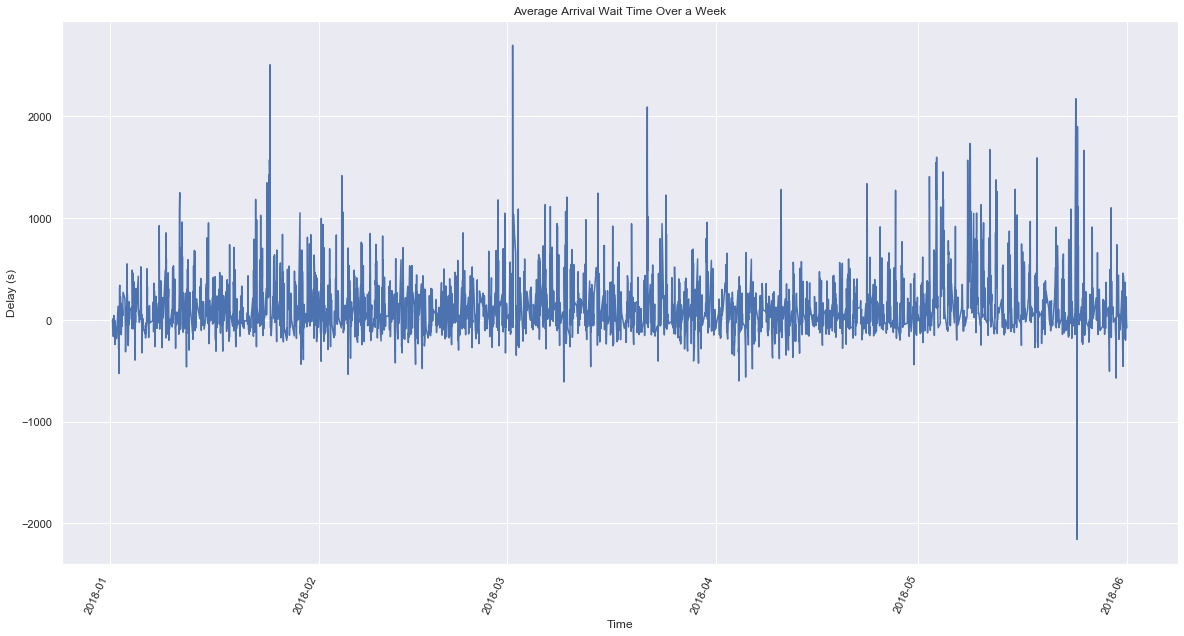

In [291]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [ ]:
#plt.savefig('output.png')

In [ ]:
#LineRef.to_csv('LSTM_test.csv')

In [292]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [293]:
bus_10.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_10.sort_index(inplace=True)
bus_10.head()

LineRef LocationCode     LocationName  \
ScheduledArrivalTime                                         
2018-01-01 09:17:00       10  39027320006  St Mary's Butts   
2018-01-01 10:17:00       10  39027320006  St Mary's Butts   
2018-01-01 10:47:00       10  39027320006  St Mary's Butts   
2018-01-01 11:19:00       10  39027320006  St Mary's Butts   
2018-01-01 12:19:00       10  39027320006  St Mary's Butts   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-01 09:17:00     2018-01-01 09:17:00 2018-01-01 09:16:55   
2018-01-01 10:17:00     2018-01-01 10:17:00 2018-01-01 10:16:45   
2018-01-01 10:47:00     2018-01-01 10:47:00 2018-01-01 10:45:19   
2018-01-01 11:19:00     2018-01-01 11:19:00 2018-01-01 11:17:52   
2018-01-01 12:19:00     2018-01-01 12:19:00 2018-01-01 12:19:11   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-01 09:17:00  2018-01-01 09:17:00      Leopard           27   
2018-01-01 10:17:00  2018-01-01 10:17:00      Leopard           27   
2018-01-01 10:47:00  2018-01-01 10:47:12      Leopard           27   
2018-01-01 11:19:00  2018-01-01 11:19:00      Leopard           27   
2018-01-01 12:19:00  2018-01-01 12:19:51      Leopard           29   

                                StartPoint         EndPoint  Latitude  \
ScheduledArrivalTime                                                    
2018-01-01 09:17:00   Albert Close S-bound  St Mary's Butts   51.4548   
2018-01-01 10:17:00   Albert Close S-bound  St Mary's Butts   51.4548   
2018-01-01 10:47:00        St Mary's Butts     Albert Close   51.4548   
2018-01-01 11:19:00   Albert Close S-bound  St Mary's Butts   51.4548   
2018-01-01 12:19:00   Albert Close S-bound     Station Road   51.4548   

                      Longitude   ArrivalWaitTime DepartureWaitTime     delay  
ScheduledArrivalTime                                                           
2018-01-01 09:17:00     -0.9750 -1 days +23:59:55          00:00:00   -5.0000  
2018-01-01 10:17:00     -0.9750 -1 days +23:59:45          00:00:00  -15.0000  
2018-01-01 10:47:00     -0.9750 -1 days +23:58:19          00:00:12 -101.0000  
2018-01-01 11:19:00     -0.9750 -1 days +23:58:52          00:00:00  -68.0000  
2018-01-01 12:19:00     -0.9750          00:00:11          00:00:51   11.0000

In [294]:
y = bus_10.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-01 09:00:00     -5.0000
2018-01-01 10:00:00   -101.0000
2018-01-01 11:00:00    -68.0000
2018-01-01 12:00:00   -164.0000
2018-01-01 13:00:00     -8.0000
Freq: H, Name: delay, dtype: float64

In [ ]:
#ax = y.plot();
#ax.set_ylabel('Delay');

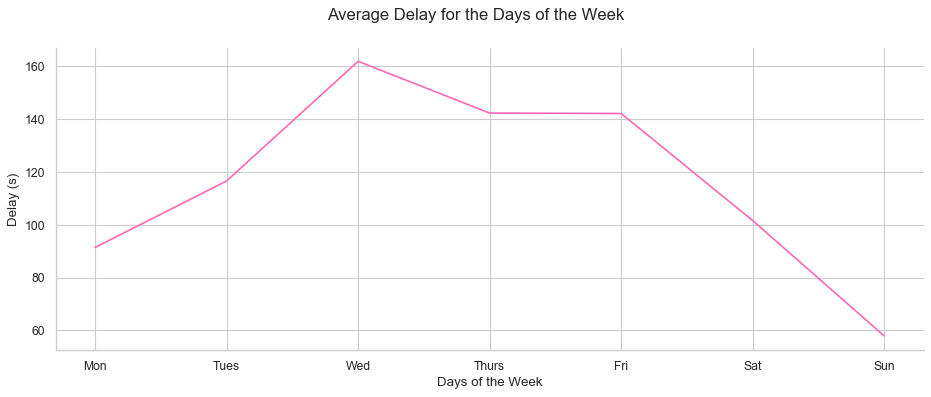

In [296]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus10_marybutt_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [297]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

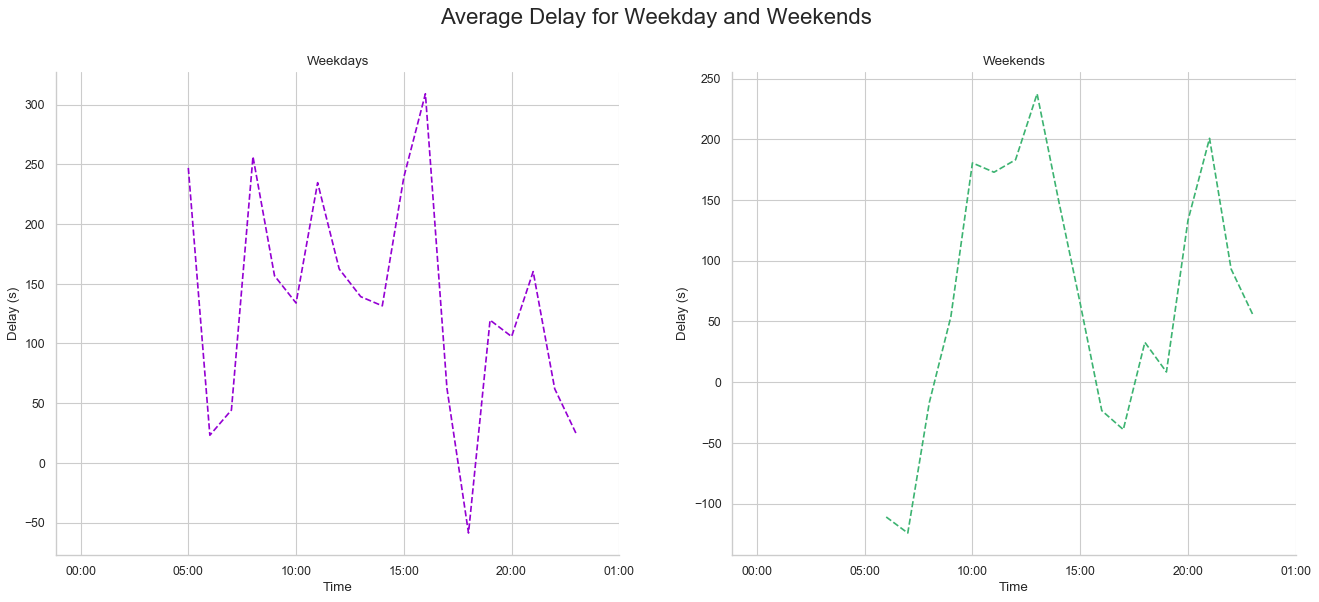

In [298]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus10_marybutt_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

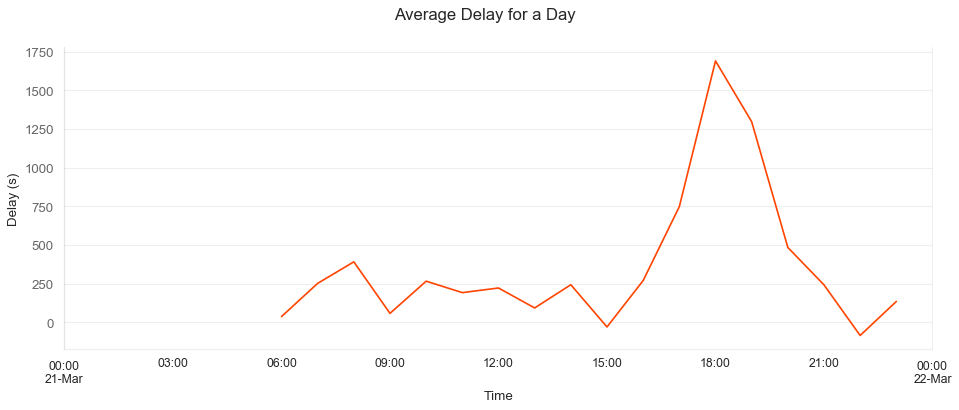

In [305]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-03-21 00:00:00':'2018-03-22 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus10_marybutt_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

#### LSTM

In [ ]:
df = pd.read_csv('LSTM.csv')

In [ ]:
df.dtypes

In [ ]:
df.ScheduledArrivalTime = pd.to_datetime(df.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [ ]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

In [ ]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [ ]:
df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

In [ ]:
model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();

## Bus 26

### Dataset Months

In [187]:
bus_26 = bus_data.loc[bus_data['LineRef'] == '26']
#bus_21 = bus_21.loc[bus_21['LocationName'] == "Reading Station"]

In [188]:
# For all dates and first month
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [189]:
bus_26 = bus_26.loc[bus_26['ScheduledArrivalTime'] < date_after]

In [190]:
# Between dates
#bus_26 = bus_26.loc[(bus_26['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_26['ScheduledArrivalTime'] <= '2018-06-01 12:00:00')]

In [191]:
bus_26.head()

LineRef LocationCode            LocationName ScheduledArrivalTime  \
1710228      26  39028170004    Friar Street stop FP  2018-01-01 04:16:00   
1710229      26  39027320007  St Marys Butts stop CA  2018-01-01 04:17:00   
1710230      26  39025430002   Castle Street stop CQ  2018-01-01 04:18:00   
1710231      26  39027180001    Russell Street opp 6  2018-01-01 04:19:00   
1710232      26  39025890002    Downshire Square opp  2018-01-01 04:19:30   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1710228    2018-01-01 04:16:00 2018-01-01 04:15:25 2018-01-01 04:15:25   
1710229    2018-01-01 04:17:00 2018-01-01 04:20:23 2018-01-01 04:20:24   
1710230    2018-01-01 04:18:00 2018-01-01 04:23:14 2018-01-01 04:23:15   
1710231    2018-01-01 04:19:00 2018-01-01 04:24:41 2018-01-01 04:24:42   
1710232    2018-01-01 04:19:30 2018-01-01 04:25:09 2018-01-01 04:25:10   

        ServiceGroup  NumberStops               StartPoint  \
1710228       Yellow           30  Blagrave Street stop EK   
1710229       Yellow           30  Blagrave Street stop EK   
1710230       Yellow           30  Blagrave Street stop EK   
1710231       Yellow           30  Blagrave Street stop EK   
1710232       Yellow           30  Blagrave Street stop EK   

                          EndPoint  Latitude  Longitude   ArrivalWaitTime  \
1710228  Calcot Sainsbury's Stop 2   51.4567    -0.9730 -1 days +23:59:25   
1710229  Calcot Sainsbury's Stop 2   51.4540    -0.9738          00:03:23   
1710230  Calcot Sainsbury's Stop 2   51.4525    -0.9767          00:05:14   
1710231  Calcot Sainsbury's Stop 2   51.4508    -0.9833          00:05:41   
1710232  Calcot Sainsbury's Stop 2   51.4496    -0.9879          00:05:39   

        DepartureWaitTime  
1710228 -1 days +23:59:25  
1710229          00:03:24  
1710230          00:05:15  
1710231          00:05:42  
1710232          00:05:40

In [192]:
bus_26.tail()

LineRef LocationCode       LocationName ScheduledArrivalTime  \
2895855      26  30053640002      Ledbury Drive  2018-06-01 00:09:00   
2895856      26  30054700001  Pemberton Gardens  2018-06-01 00:09:30   
2895857      26  30050400001   Beansheaf Stores  2018-06-01 00:10:00   
2895858      26  30056320002     Torcross Grove  2018-06-01 00:10:30   
2895859      26  30053940001    Mayfield Avenue  2018-06-01 00:11:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2895855    2018-06-01 00:09:00 2018-06-01 00:11:43 2018-06-01 00:11:43   
2895856    2018-06-01 00:09:30 2018-06-01 00:12:06 2018-06-01 00:12:06   
2895857    2018-06-01 00:10:00 2018-06-01 00:12:36 2018-06-01 00:12:36   
2895858    2018-06-01 00:10:30 2018-06-01 00:13:13 2018-06-01 00:13:13   
2895859    2018-06-01 00:11:00 2018-06-01 00:13:33 2018-06-01 00:13:33   

        ServiceGroup  NumberStops               StartPoint  \
2895855       Yellow           30  Blagrave Street stop EK   
2895856       Yellow           30  Blagrave Street stop EK   
2895857       Yellow           30  Blagrave Street stop EK   
2895858       Yellow           30  Blagrave Street stop EK   
2895859       Yellow           30  Blagrave Street stop EK   

                    EndPoint  Latitude  Longitude ArrivalWaitTime  \
2895855  Calcot, Sainsbury's   51.4403    -1.0419        00:02:43   
2895856  Calcot, Sainsbury's   51.4407    -1.0446        00:02:36   
2895857  Calcot, Sainsbury's   51.4404    -1.0477        00:02:36   
2895858  Calcot, Sainsbury's   51.4394    -1.0529        00:02:43   
2895859  Calcot, Sainsbury's   51.4409    -1.0574        00:02:33   

        DepartureWaitTime  
2895855          00:02:43  
2895856          00:02:36  
2895857          00:02:36  
2895858          00:02:43  
2895859          00:02:33

In [193]:
len(bus_26)

759032

In [194]:
LineRef = pd.DataFrame()
LineRef = bus_26
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [195]:
LineRef.head()

LineRef LocationCode            LocationName ScheduledArrivalTime  \
1710228      26  39028170004    Friar Street stop FP  2018-01-01 04:16:00   
1710229      26  39027320007  St Marys Butts stop CA  2018-01-01 04:17:00   
1710230      26  39025430002   Castle Street stop CQ  2018-01-01 04:18:00   
1710231      26  39027180001    Russell Street opp 6  2018-01-01 04:19:00   
1710232      26  39025890002    Downshire Square opp  2018-01-01 04:19:30   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1710228    2018-01-01 04:16:00 2018-01-01 04:15:25 2018-01-01 04:15:25   
1710229    2018-01-01 04:17:00 2018-01-01 04:20:23 2018-01-01 04:20:24   
1710230    2018-01-01 04:18:00 2018-01-01 04:23:14 2018-01-01 04:23:15   
1710231    2018-01-01 04:19:00 2018-01-01 04:24:41 2018-01-01 04:24:42   
1710232    2018-01-01 04:19:30 2018-01-01 04:25:09 2018-01-01 04:25:10   

        ServiceGroup  NumberStops               StartPoint  \
1710228       Yellow           30  Blagrave Street stop EK   
1710229       Yellow           30  Blagrave Street stop EK   
1710230       Yellow           30  Blagrave Street stop EK   
1710231       Yellow           30  Blagrave Street stop EK   
1710232       Yellow           30  Blagrave Street stop EK   

                          EndPoint  Latitude  Longitude   ArrivalWaitTime  \
1710228  Calcot Sainsbury's Stop 2   51.4567    -0.9730 -1 days +23:59:25   
1710229  Calcot Sainsbury's Stop 2   51.4540    -0.9738          00:03:23   
1710230  Calcot Sainsbury's Stop 2   51.4525    -0.9767          00:05:14   
1710231  Calcot Sainsbury's Stop 2   51.4508    -0.9833          00:05:41   
1710232  Calcot Sainsbury's Stop 2   51.4496    -0.9879          00:05:39   

        DepartureWaitTime    delay  
1710228 -1 days +23:59:25 -35.0000  
1710229          00:03:24 203.0000  
1710230          00:05:15 314.0000  
1710231          00:05:42 341.0000  
1710232          00:05:40 339.0000

In [197]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

261959

In [468]:
#LineRef.to_csv('bus_26_may18.csv')

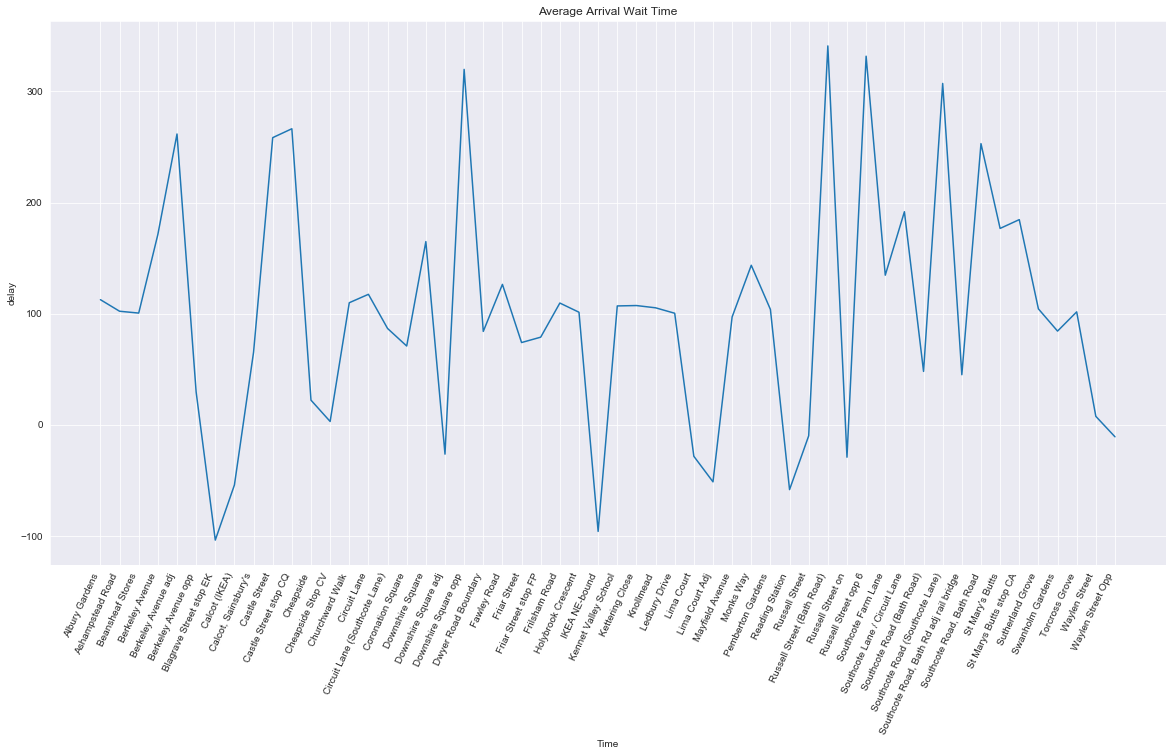

In [469]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])
plt.title("Average Arrival Wait Time")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('delay')
plt.show()

In [198]:
LineRef.head()

NumberStops  Latitude  Longitude    delay
ScheduledArrivalTime                                           
2018-01-01 04:16:00       30.0000   51.4567    -0.9730 -35.0000
2018-01-01 04:17:00       30.0000   51.4540    -0.9738 203.0000
2018-01-01 04:18:00       30.0000   51.4525    -0.9767 314.0000
2018-01-01 04:19:00       30.0000   51.4508    -0.9833 341.0000
2018-01-01 04:19:30       30.0000   51.4496    -0.9879 339.0000

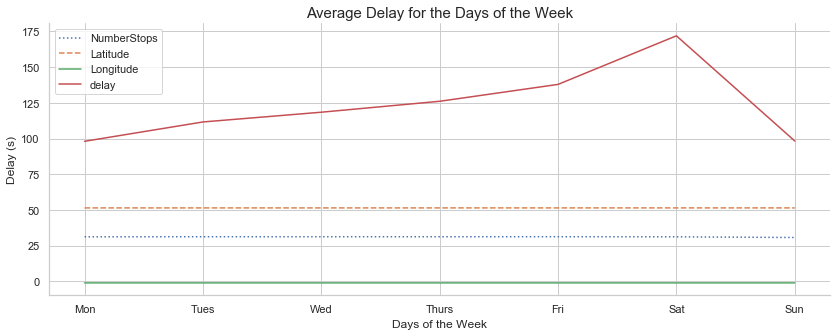

In [200]:
by_weekday = LineRef.groupby(LineRef.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-'],  figsize=(14,5));

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.title('Average Delay for the Days of the Week', fontsize="15")
plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus26_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()


In [201]:
weekend = np.where(LineRef.index.weekday < 5, 'Weekday', 'Weekend')
by_time = LineRef.groupby([weekend, LineRef.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

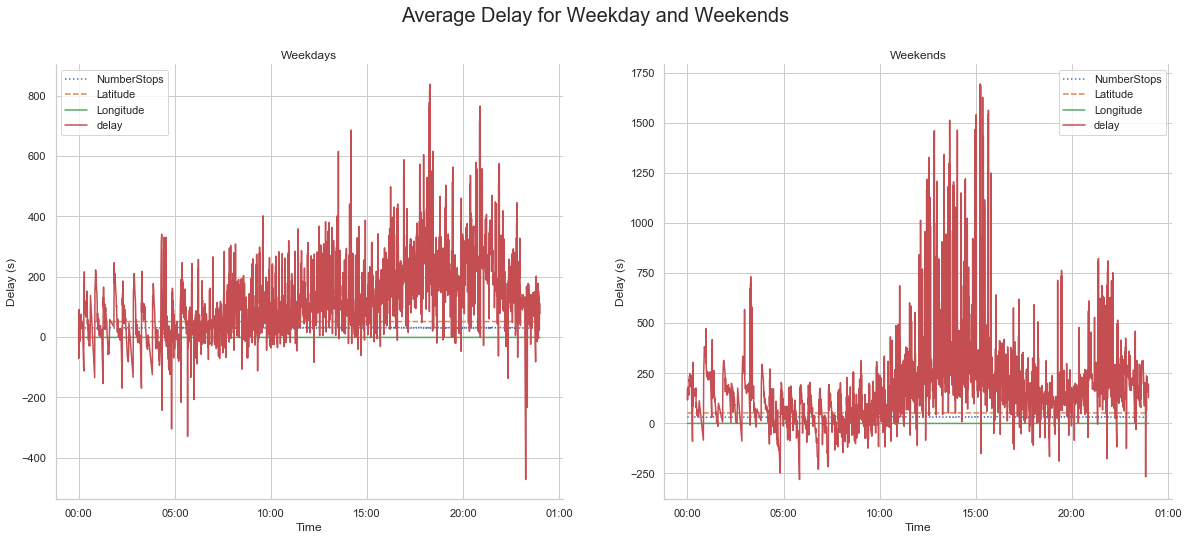

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 
    
plt.savefig('bus26_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Calcot (IKEA) Bus Stop

In [164]:
bus_26 = bus_data.loc[(bus_data['LocationName'] == "Calcot (IKEA)") & (bus_data['LineRef'] == '26')]

In [165]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

Timestamp('2018-06-01 23:00:00')

In [166]:
bus_26 = bus_26.loc[bus_26['ScheduledArrivalTime'] < date_after]

In [167]:
#bus_26 = bus_26.loc[(bus_26['ScheduledArrivalTime'] > '2018-05-01 00:00:00') & (bus_26['ScheduledArrivalTime'] <= '2018-06-01 23:00:00')]

In [168]:
bus_26.head()

LineRef LocationCode   LocationName ScheduledArrivalTime  \
1810590      26  30058790001  Calcot (IKEA)  2018-01-21 08:50:00   
1810652      26  30058790001  Calcot (IKEA)  2018-01-21 09:20:00   
1810653      26  30058790001  Calcot (IKEA)  2018-01-21 08:55:00   
1810715      26  30058790001  Calcot (IKEA)  2018-01-21 09:40:00   
1810716      26  30058790001  Calcot (IKEA)  2018-01-21 09:25:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1810590    2018-01-21 08:50:00 2018-01-21 08:45:52 2018-01-21 08:50:00   
1810652    2018-01-21 09:20:00 2018-01-21 09:20:37 2018-01-21 09:21:06   
1810653    2018-01-21 08:55:00 2018-01-21 08:46:22 2018-01-21 08:55:02   
1810715    2018-01-21 09:40:00 2018-01-21 09:40:28 2018-01-21 09:41:09   
1810716    2018-01-21 09:25:00 2018-01-21 09:21:07 2018-01-21 09:26:19   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1810590       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810652       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810653       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   
1810715       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810716       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   

         Longitude   ArrivalWaitTime DepartureWaitTime  
1810590    -1.0670 -1 days +23:55:52          00:00:00  
1810652    -1.0670          00:00:37          00:01:06  
1810653    -1.0670 -1 days +23:51:22          00:00:02  
1810715    -1.0670          00:00:28          00:01:09  
1810716    -1.0670 -1 days +23:56:07          00:01:19

In [169]:
bus_26.tail()

LineRef LocationCode   LocationName ScheduledArrivalTime  \
2309168      26  30058790001  Calcot (IKEA)  2018-05-01 20:50:00   
2309199      26  30058790001  Calcot (IKEA)  2018-05-01 21:20:00   
2309290      26  30058790001  Calcot (IKEA)  2018-05-01 22:18:00   
2309291      26  30058790001  Calcot (IKEA)  2018-05-01 21:50:00   
2309353      26  30058790001  Calcot (IKEA)  2018-05-01 22:20:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
2309168    2018-05-01 20:50:00 2018-05-01 20:50:46 2018-05-01 20:51:50   
2309199    2018-05-01 21:20:00 2018-05-01 21:21:16 2018-05-01 21:21:17   
2309290    2018-05-01 22:18:00 2018-05-01 22:17:49 2018-05-01 22:18:17   
2309291    2018-05-01 21:50:00 2018-05-01 21:48:38 2018-05-01 21:50:28   
2309353    2018-05-01 22:20:00 2018-05-01 22:18:11 2018-05-01 22:21:16   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
2309168       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   
2309199       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   
2309290       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
2309291       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   
2309353       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   

         Longitude   ArrivalWaitTime DepartureWaitTime  
2309168    -1.0670          00:00:46          00:01:50  
2309199    -1.0670          00:01:16          00:01:17  
2309290    -1.0670 -1 days +23:59:49          00:00:17  
2309291    -1.0670 -1 days +23:58:38          00:00:28  
2309353    -1.0670 -1 days +23:58:11          00:01:16

In [170]:
LineRef = pd.DataFrame()
LineRef = bus_26
#LineRef['delay'] = pd.to_datetime(LineRef['ScheduledArrivalTime'])
delay = LineRef['ArrivalWaitTime'].dt.total_seconds().tolist()
LineRef['delay'] = delay

In [171]:
LineRef.head()

LineRef LocationCode   LocationName ScheduledArrivalTime  \
1810590      26  30058790001  Calcot (IKEA)  2018-01-21 08:50:00   
1810652      26  30058790001  Calcot (IKEA)  2018-01-21 09:20:00   
1810653      26  30058790001  Calcot (IKEA)  2018-01-21 08:55:00   
1810715      26  30058790001  Calcot (IKEA)  2018-01-21 09:40:00   
1810716      26  30058790001  Calcot (IKEA)  2018-01-21 09:25:00   

        ScheduledDepartureTime         ArrivalTime       DepartureTime  \
1810590    2018-01-21 08:50:00 2018-01-21 08:45:52 2018-01-21 08:50:00   
1810652    2018-01-21 09:20:00 2018-01-21 09:20:37 2018-01-21 09:21:06   
1810653    2018-01-21 08:55:00 2018-01-21 08:46:22 2018-01-21 08:55:02   
1810715    2018-01-21 09:40:00 2018-01-21 09:40:28 2018-01-21 09:41:09   
1810716    2018-01-21 09:25:00 2018-01-21 09:21:07 2018-01-21 09:26:19   

        ServiceGroup  NumberStops       StartPoint         EndPoint  Latitude  \
1810590       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810652       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810653       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   
1810715       Yellow           31  Reading Station    Calcot (IKEA)   51.4413   
1810716       Yellow           32    Calcot (IKEA)  Reading Station   51.4413   

         Longitude   ArrivalWaitTime DepartureWaitTime     delay  
1810590    -1.0670 -1 days +23:55:52          00:00:00 -248.0000  
1810652    -1.0670          00:00:37          00:01:06   37.0000  
1810653    -1.0670 -1 days +23:51:22          00:00:02 -518.0000  
1810715    -1.0670          00:00:28          00:01:09   28.0000  
1810716    -1.0670 -1 days +23:56:07          00:01:19 -233.0000

In [172]:
LineRef = LineRef.groupby(['ScheduledArrivalTime']).mean()
#LineRef = LineRef.reset_index()
LineRef.head()
len(LineRef)

11968

In [173]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

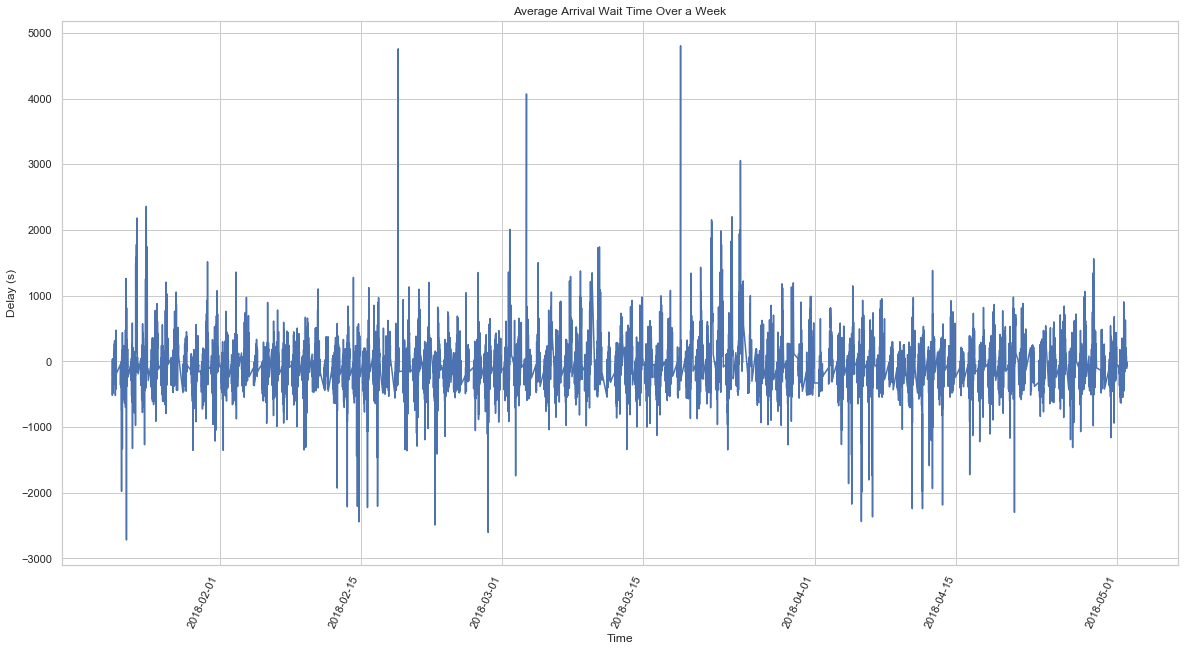

In [174]:
fig, (ax) = plt.subplots(1, 1, figsize=(20,10))
sns.set_style("darkgrid") 
plt.plot(LineRef['delay'])#.resample('M').mean())
plt.title("Average Arrival Wait Time Over a Week")
plt.xlabel('Time')
plt.xticks(rotation=65, horizontalalignment='right')
plt.ylabel('Delay (s)')
plt.show() 

In [175]:
#LineRef.to_csv('LSTM_26.csv')

In [176]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [177]:
bus_26.set_index('ScheduledArrivalTime', inplace=True)
#df.index = pd.to_datetime(df.index)
bus_26.sort_index(inplace=True)
bus_26.head()

LineRef LocationCode   LocationName  \
ScheduledArrivalTime                                       
2018-01-21 08:50:00       26  30058790001  Calcot (IKEA)   
2018-01-21 08:55:00       26  30058790001  Calcot (IKEA)   
2018-01-21 09:20:00       26  30058790001  Calcot (IKEA)   
2018-01-21 09:25:00       26  30058790001  Calcot (IKEA)   
2018-01-21 09:40:00       26  30058790001  Calcot (IKEA)   

                     ScheduledDepartureTime         ArrivalTime  \
ScheduledArrivalTime                                              
2018-01-21 08:50:00     2018-01-21 08:50:00 2018-01-21 08:45:52   
2018-01-21 08:55:00     2018-01-21 08:55:00 2018-01-21 08:46:22   
2018-01-21 09:20:00     2018-01-21 09:20:00 2018-01-21 09:20:37   
2018-01-21 09:25:00     2018-01-21 09:25:00 2018-01-21 09:21:07   
2018-01-21 09:40:00     2018-01-21 09:40:00 2018-01-21 09:40:28   

                           DepartureTime ServiceGroup  NumberStops  \
ScheduledArrivalTime                                                 
2018-01-21 08:50:00  2018-01-21 08:50:00       Yellow           31   
2018-01-21 08:55:00  2018-01-21 08:55:02       Yellow           32   
2018-01-21 09:20:00  2018-01-21 09:21:06       Yellow           31   
2018-01-21 09:25:00  2018-01-21 09:26:19       Yellow           32   
2018-01-21 09:40:00  2018-01-21 09:41:09       Yellow           31   

                           StartPoint         EndPoint  Latitude  Longitude  \
ScheduledArrivalTime                                                          
2018-01-21 08:50:00   Reading Station    Calcot (IKEA)   51.4413    -1.0670   
2018-01-21 08:55:00     Calcot (IKEA)  Reading Station   51.4413    -1.0670   
2018-01-21 09:20:00   Reading Station    Calcot (IKEA)   51.4413    -1.0670   
2018-01-21 09:25:00     Calcot (IKEA)  Reading Station   51.4413    -1.0670   
2018-01-21 09:40:00   Reading Station    Calcot (IKEA)   51.4413    -1.0670   

                       ArrivalWaitTime DepartureWaitTime     delay  
ScheduledArrivalTime                                                
2018-01-21 08:50:00  -1 days +23:55:52          00:00:00 -248.0000  
2018-01-21 08:55:00  -1 days +23:51:22          00:00:02 -518.0000  
2018-01-21 09:20:00           00:00:37          00:01:06   37.0000  
2018-01-21 09:25:00  -1 days +23:56:07          00:01:19 -233.0000  
2018-01-21 09:40:00           00:00:28          00:01:09   28.0000

In [178]:
y = bus_26.delay
y.index.name = 'Time'
y = y.resample('H').last()
y.head()

Time
2018-01-21 08:00:00   -518.0000
2018-01-21 09:00:00   -239.0000
2018-01-21 10:00:00   -485.0000
2018-01-21 11:00:00   -324.0000
2018-01-21 12:00:00   -116.0000
Freq: H, Name: delay, dtype: float64

In [ ]:
#ax = y.plot();
#ax.set_ylabel('Delay');

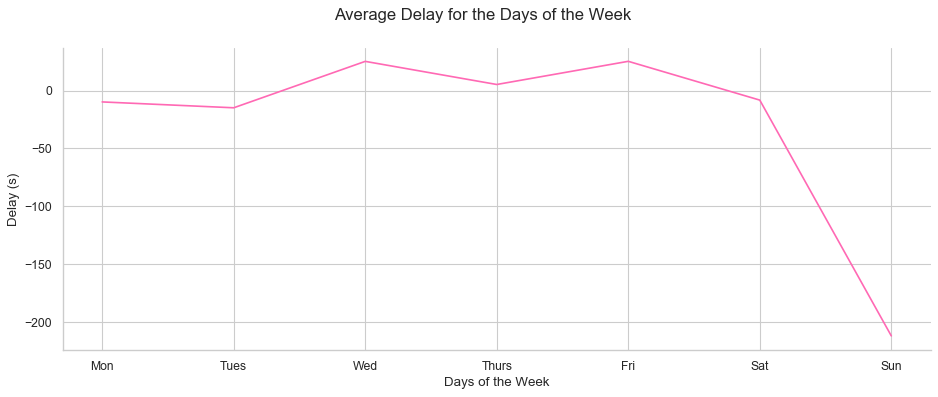

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for the Days of the Week", fontsize="15")
by_weekday = y.groupby(y.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(color='hotpink');

#style.use('ggplot')
sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

plt.ylabel('Delay (s)');
plt.xlabel('Days of the Week');

plt.savefig('bus26_ikea_dayofweek.pdf', bbox_inches='tight', transparent='true')
plt.show()

In [181]:
weekend = np.where(y.index.weekday < 5, 'Weekday', 'Weekend')
by_time = y.groupby([weekend, y.index.time]).mean()
hourly_ticks = 5 * 60 * 60 * np.arange(6)

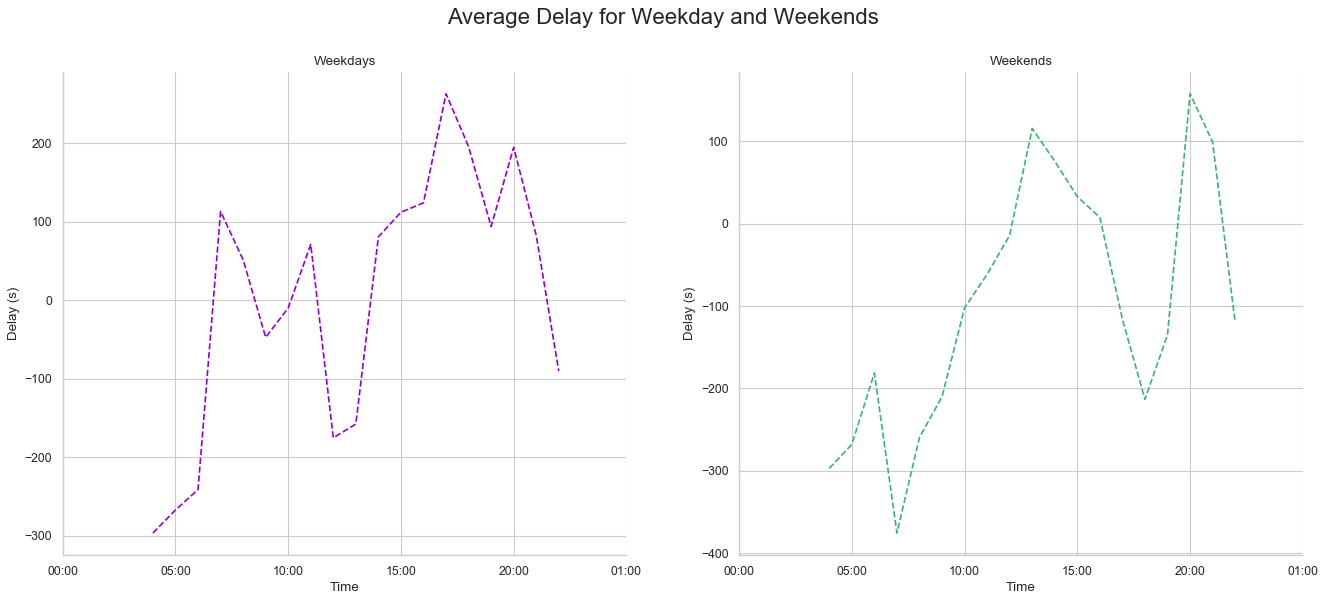

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi= 80)
fig.suptitle("Average Delay for Weekday and Weekends", fontsize="20")
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='darkviolet', linestyle='dashed')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='mediumseagreen', linestyle='dashed');

sns.despine()
sns.set_context("paper")
sns.set(style="whitegrid")

for ax in ax.flat:
    ax.set(xlabel='Time', ylabel='Delay (s)') 

plt.savefig('bus26_ikea_weekend.pdf', bbox_inches='tight', transparent='true')
plt.show()

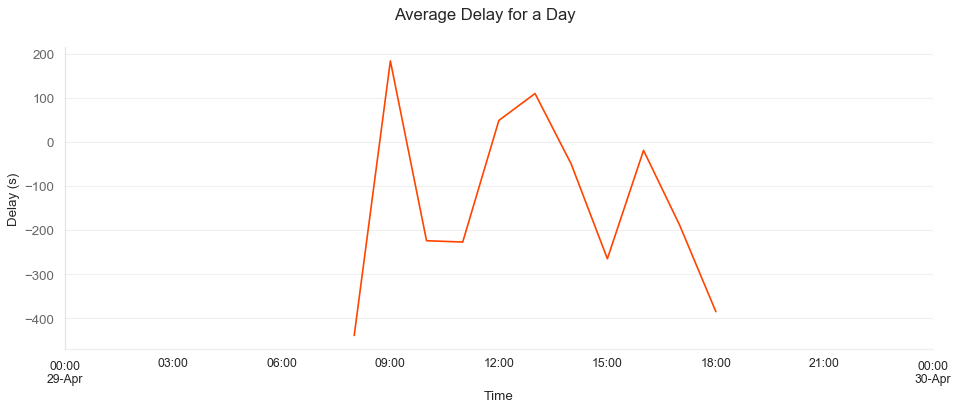

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), dpi= 80)
fig.suptitle("Average Delay for a Day", fontsize="15")
y.loc['2018-04-29 00:00:00':'2018-04-30 00:00:00'].plot(color='orangered');
plt.ylabel('Delay (s)');

# Decoration
#plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.savefig('bus26_ikea_time.pdf', bbox_inches='tight', transparent='true')
plt.show()

### Predictions

#### Linear Regression

#### LSTM

In [ ]:
df = pd.read_csv('LSTM.csv')

In [ ]:
df.dtypes

In [ ]:
df.ScheduledArrivalTime = pd.to_datetime(df.ScheduledArrivalTime)
#df = df.set_index("ScheduledArrivalTime")

In [ ]:
date_after = pd.Timestamp(2018, 6, 1, 23)
date_after

In [ ]:
df = df.loc[df['ScheduledArrivalTime'] < date_after]

In [ ]:
df = df.loc[(df['ScheduledArrivalTime'] > '2018-01-01 00:00:00') & (df['ScheduledArrivalTime'] <= '2018-02-01 00:00:00')]

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
dataset = df.delay.values #numpy.ndarray
#dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False

In [ ]:
model.summary()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
#plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Delay', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=15)
plt.show();